# Districts of Madrid Analysis

## Introduction

In this project I have: 

* Scraped demographic data from Madrid by its 21 districts, including Covid-19 contagion rate in the las 14 days.
* Then I used Foursquare API to get the most common venues of each district. 
* After that, using K-means clustering, I clustered Madrid's districts on the basis of the common venues.
* Then, I created a map where I overlap the population density and the most common venues by district.
* Finally, I did a brief analysis of the relationship between population density, Covid contagion rate, and the most common venues by district.

##### Importing libraries and resources

In [1]:
pip search geopy

ERROR: Exception:
Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pip/_internal/cli/base_command.py", line 188, in _main
    status = self.run(options, args)
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pip/_internal/commands/search.py", line 52, in run
    pypi_hits = self.search(query, options)
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pip/_internal/commands/search.py", line 71, in search
    hits = pypi.search({'name': query, 'summary': query}, 'or')
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/xmlrpc/client.py", line 1112, in __call__
    return self.__send(self.__name, args)
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/xmlrpc/client.py", line 1452, in __request
    verbose=self.__verbose
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pip/_internal/network/xmlrpc.py", line 38, in request
    return self.parse_response(response.raw)
  File "/

In [2]:
!pip install geopy

In [3]:
!pip install folium
import folium

     |████████████████████████████████| 93 kB 2.5 MB/s eta 0:00:011


In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [5]:
# The Wikipedia extension is very useful to scrap data in rhe right format
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11685 sha256=e714ee614ff147fc0091790d16db59b7c3e748244324c702153d431d724eaf58
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [6]:
import wikipedia as wp

In [7]:
# Get the html source for our data
# https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid

html = wp.page("Anexo:Distritos de Madrid").html().encode("UTF-8")
Madrid_geo = pd.read_html(html)[1]
Madrid_geo.head()

,District Number,Name,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Location,Administrative wards
0,1.0,Centro,522.82,131928,252.34,NaN,Palacio (11)Embajadores (12)Cortes (13)Justici...
1,2.0,Arganzuela,646.22,151965,235.16,NaN,Imperial (21)Acacias (22)Chopera (23)Legazpi (...
2,3.0,Retiro,546.62,118516,216.82,NaN,PacÃ­fico (31)Adelfas (32)Estrella (33)Ibiza (...
3,4.0,Salamanca,539.24,143800,266.67,NaN,Recoletos (41)Goya (42)Fuente del Berro (43)Gu...
4,5.0,ChamartÃ­n,917.55,143424,156.31,NaN,El Viso (51)Prosperidad (52)Ciudad JardÃ­n (53...


In [8]:
# Drop useless columns

Madrid_geo=Madrid_geo.drop(columns=["District Number","Location","Administrative wards"])

In [9]:
# Change the names that are wrong, this will be useful to find them with the geocoder later

Madrid_geo = Madrid_geo.replace(['ChamartÃ­n'],'Chamartín')
Madrid_geo = Madrid_geo.replace(["TetuÃ¡n"],'Tetuán')
Madrid_geo = Madrid_geo.replace(["ChamberÃ­"], 'Chamberí')
Madrid_geo = Madrid_geo.replace(["VicÃ¡lvaro"],'Vicálvaro')
Madrid_geo = Madrid_geo.replace(["Centro"],'Madrid Centro')
Madrid_geo = Madrid_geo.replace(["Barajas"],'Distrito de Barajas')
Madrid_geo = Madrid_geo.replace(["Retiro"],'Distrito del Retiro')
Madrid_geo

,Name,District area[n 1] (Ha.),Population,Population density(Hab./Ha.)
0,Madrid Centro,522.82,131928,252.34
1,Arganzuela,646.22,151965,235.16
2,Distrito del Retiro,546.62,118516,216.82
3,Salamanca,539.24,143800,266.67
4,Chamartín,917.55,143424,156.31
5,Tetuán,537.47,153789,286.13
6,Chamberí,467.92,137401,293.64
7,Fuencarral-El Pardo,23783.84,238756,10.04
8,Moncloa-Aravaca,4653.11,116903,25.12
9,Latina,2542.72,233808,91.95


#####  Finding Longitude and Latitude of the Locations

In [10]:
# Let's define a function that gets those values based on our data.

def getLatLong(row):
    #print('post :{}'.format(row[:]))
    #print('neigh :{}'.format(row[1]))
    # initialize your variable to None
    lat_lng_coords = None
    search_query = '{}, Madrid,Spain'.format(row)
    # loop until you get the coordinates
    try:
        while(lat_lng_coords is None):
            #g = geocoder.here(search_query,app_id=app_id,app_code=app_code)
            g = geocoder.arcgis(search_query)
            lat_lng_coords = g.latlng
            #print('FIRST')
    except IndexError:
        latitude = 0.0
        longitude = 0.0
        print('BACKUP')
        return [latitude,longitude]

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    print(latitude, longitude)
    return [latitude, longitude]

In [11]:
# We need to install geocoder so we can later use Nominatim to convert an address into latitude and longitude values

!pip install geocoder

     |████████████████████████████████| 98 kB 9.7 MB/s  eta 0:00:01


In [12]:
import geocoder as geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [13]:
# Now we get the coordinates in a new variable coords_list link to the Name (district) in our dataset

coords_list = Madrid_geo['Name'].apply(getLatLong).tolist()

40.418310000000076 -3.7027499999999804
40.40021000000007 -3.69617999999997
40.41317000000004 -3.6830699999999297
40.42972000000003 -3.679749999999956
40.450000000000045 -3.699999999999932
40.46667000000008 -3.716669999999965
40.43404000000004 -3.7037899999999695
40.49840000000006 -3.731399999999951
40.435470000000066 -3.7316999999999325
40.38897000000003 -3.7456899999999678
40.39094000000006 -3.7241999999999393
40.38866000000007 -3.7003499999999576
40.39235000000008 -3.65969999999993
40.41667000000007 -3.6499999999999773
40.453490000000045 -3.6543399999999338
40.47444000000007 -3.6410999999999376
40.35000000000008 -3.699999999999932
40.36695000000003 -3.6014599999999746
40.400000000000034 -3.599999999999966
40.43445000000003 -3.6098899999999503
40.47366000000005 -3.57776999999993
40.43005000000005 -3.703559999999925


In [14]:
# Merging the values in the dataframe

Madrid_geo[['Latitude','Longitude']]=pd.DataFrame(coords_list,columns=['Latitude', 'Longitude'])
Madrid_geo

,Name,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude
0,Madrid Centro,522.82,131928,252.34,40.41831,-3.70275
1,Arganzuela,646.22,151965,235.16,40.40021,-3.69618
2,Distrito del Retiro,546.62,118516,216.82,40.41317,-3.68307
3,Salamanca,539.24,143800,266.67,40.42972,-3.67975
4,Chamartín,917.55,143424,156.31,40.45000,-3.70000
5,Tetuán,537.47,153789,286.13,40.46667,-3.71667
6,Chamberí,467.92,137401,293.64,40.43404,-3.70379
7,Fuencarral-El Pardo,23783.84,238756,10.04,40.49840,-3.73140
8,Moncloa-Aravaca,4653.11,116903,25.12,40.43547,-3.73170
9,Latina,2542.72,233808,91.95,40.38897,-3.74569


In [15]:
# Let's drop the last row, 21, TOTAL

Madrid_geo = Madrid_geo.drop([21])
Madrid_geo

,Name,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude
0,Madrid Centro,522.82,131928,252.34,40.41831,-3.70275
1,Arganzuela,646.22,151965,235.16,40.40021,-3.69618
2,Distrito del Retiro,546.62,118516,216.82,40.41317,-3.68307
3,Salamanca,539.24,143800,266.67,40.42972,-3.67975
4,Chamartín,917.55,143424,156.31,40.45000,-3.70000
5,Tetuán,537.47,153789,286.13,40.46667,-3.71667
6,Chamberí,467.92,137401,293.64,40.43404,-3.70379
7,Fuencarral-El Pardo,23783.84,238756,10.04,40.49840,-3.73140
8,Moncloa-Aravaca,4653.11,116903,25.12,40.43547,-3.73170
9,Latina,2542.72,233808,91.95,40.38897,-3.74569


In [16]:
# Use geopy library to get the latitude and longitude values of Madrid.
# In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent Madrid_explorer, as shown below.

address = 'Madrid'

geolocator = Nominatim(user_agent="Madrid_explorer")
location = "Madrid"
latitude = 40.4168
longitude = 3.7038
print('The geograpical coordinate of Madrid are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid are 40.4168, 3.7038.


In [17]:
# Create a map of Madrid with districts superimposed on top.

map_Madrid = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Madrid_geo['Latitude'], Madrid_geo['Longitude'], Madrid_geo['Name'], Madrid_geo['Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=35,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Madrid)  
    
map_Madrid

In [18]:
# Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
# Define Foursquare Credentials and Version

CLIENT_ID = '5XXPJYV4O3TQRENWRRNK4Q2ZWXPHNQK50PM4EUCJX0QOF4SF' # your Foursquare ID
CLIENT_SECRET = 'EGONUMECVG03RWPKRTEG1XQICCRZSEV01SEMYAKIKUMQCRVM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5XXPJYV4O3TQRENWRRNK4Q2ZWXPHNQK50PM4EUCJX0QOF4SF
CLIENT_SECRET:EGONUMECVG03RWPKRTEG1XQICCRZSEV01SEMYAKIKUMQCRVM


In [19]:
# Let's define a function that gives us the URL for our future requests

def getBuiltUrl(neigh_lat,neigh_long,radius=2000):
   
    LIMIT=300
    #radius=2000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_lat, 
    neigh_long, 
    radius, 
    LIMIT)
    return url

In [20]:
# Let's explore the first district, Madrid Centro, in our dataframe

neigh_name, neigh_borough, neigh_post, neigh_price, neigh_lat, neigh_long = Madrid_geo.iloc[0]
print('Latitude and longitude values of {} are {}, {}.'.format(neigh_name, 
                                                               neigh_lat, 
                                                               neigh_long))
results = requests.get(getBuiltUrl(neigh_lat,neigh_long)).json()
results

Latitude and longitude values of Madrid Centro are 40.418310000000076, -3.7027499999999804.


{'meta': {'code': 200, 'requestId': '5fe752a697e49419a43b947e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Sol',
  'headerFullLocation': 'Sol, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 238,
  'suggestedBounds': {'ne': {'lat': 40.43631001800009,
    'lng': -3.6791513203352966},
   'sw': {'lat': 40.40030998200006, 'lng': -3.7263486796646643}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bddaac30ee3a59370242eb0',
       'name': 'Club del Gourmet Corte Ingles',
       'location': {'address': 'C. Preciados, 3',
        'lat': 40.41749665225322,
        'lng': -3.704686028127798,
        'labeledLatLngs': [{'label': 'display',
          'lat': 4

In [21]:
# And now, let's define a function that gets us the data we want from the lsit above, those being, categories

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
# Now,let's clean the json file and structure it into a pandas dataframe.

Madrid_venues = results['response']['groups'][0]['items']
    
nearby_Madrid_venues = json_normalize(Madrid_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_Madrid_venues =nearby_Madrid_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_Madrid_venues['venue.categories'] = nearby_Madrid_venues.apply(get_category_type, axis=1)

# clean columns
nearby_Madrid_venues.columns = [col.split(".")[-1] for col in nearby_Madrid_venues.columns]

nearby_Madrid_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,Club del Gourmet Corte Ingles,Gourmet Shop,40.417497,-3.704686
1,LUSH,Cosmetics Shop,40.419012,-3.704898
2,Puerta del Sol,Plaza,40.417034,-3.705251
3,La Pulpería de Victoria,Seafood Restaurant,40.416506,-3.701709
4,Apple Puerta del Sol,Electronics Store,40.416898,-3.702065


In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_Madrid_venues.shape[0]))

100 venues were returned by Foursquare.


### Function to repeat the same process to all the districts in Madrid

In [24]:
# Let's now define a function similar to the previous one, but for each district

def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        LIMIT=300
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_Madrid_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_Madrid_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_Madrid_venues)

##### Running our function for all districts in the dataframe

In [25]:
Madrid_venues2 = getNearbyVenues(names=Madrid_geo['Name'], 
                                   latitudes=Madrid_geo['Latitude'], 
                                   longitudes=Madrid_geo['Longitude'], 
                                   radius=2000)

Madrid Centro
Arganzuela
Distrito del Retiro
Salamanca
Chamartín
Tetuán
Chamberí
Fuencarral-El Pardo
Moncloa-Aravaca
Latina
Carabanchel
Usera
Puente de Vallecas
Moratalaz
Ciudad Lineal
Hortaleza
Villaverde
Villa de Vallecas
Vicálvaro
San Blas-Canillejas
Distrito de Barajas


In [26]:
print(Madrid_venues2.shape)
Madrid_venues2.head()

(1731, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Madrid Centro,40.41831,-3.70275,Club del Gourmet Corte Ingles,40.417497,-3.704686,Gourmet Shop
1,Madrid Centro,40.41831,-3.70275,LUSH,40.419012,-3.704898,Cosmetics Shop
2,Madrid Centro,40.41831,-3.70275,Puerta del Sol,40.417034,-3.705251,Plaza
3,Madrid Centro,40.41831,-3.70275,La Pulpería de Victoria,40.416506,-3.701709,Seafood Restaurant
4,Madrid Centro,40.41831,-3.70275,Apple Puerta del Sol,40.416898,-3.702065,Electronics Store


##### Venues returned for each district

In [27]:
Madrid_venues2.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arganzuela,100,100,100,100,100,100
Carabanchel,43,43,43,43,43,43
Chamartín,100,100,100,100,100,100
Chamberí,100,100,100,100,100,100
Ciudad Lineal,100,100,100,100,100,100
Distrito de Barajas,79,79,79,79,79,79
Distrito del Retiro,100,100,100,100,100,100
Fuencarral-El Pardo,33,33,33,33,33,33
Hortaleza,40,40,40,40,40,40


In [28]:
print('There are {} uniques categories.'.format(len(Madrid_venues2['Venue Category'].unique())))

There are 204 uniques categories.


##### Analyzing each Neighborhood Location

In [29]:
# To find clusters of venue types in the different city districts, we need to first transform the data frame with the restaurant venues, associated to city districts, by one-hot encoding (0/1).
# one hot encoding
Madrid_onehot = pd.get_dummies(Madrid_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Madrid_onehot['Neighborhood'] = Madrid_venues2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Madrid_onehot.columns[-1]] + list(Madrid_onehot.columns[:-1])
Madrid_onehot = Madrid_onehot[fixed_columns]

Madrid_onehot.head()

,Zoo,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Café,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,Food Court,Food Service,Fountain,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Other Nightlife,Paella Restaurant,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pub,Public Art,Racetrack,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Madrid Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Madrid Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Madrid Cen

In [30]:
Madrid_onehot.shape

(1731, 204)

##### Next, let's group rows by districts and by taking the mean of the frequency of occurrence of each category

In [31]:
Madrid_grouped = Madrid_onehot.groupby('Neighborhood').mean().reset_index()
Madrid_grouped.head()

,Neighborhood,Zoo,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Café,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,Food Court,Food Service,Fountain,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Other Nightlife,Paella Restaurant,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pub,Public Art,Racetrack,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Arganzuela,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.02,0.04,0.04,0.00,0.00,0.00,0.0,0.020000,0.01,0.0,0.0,0.0,0.01,0.01,0.01,0.000000,0.01,0.0,0.0,0.00,0.0,0.0,0.00,0.02,0.01,0.010000,0.0,0.00,0.000000,0.00,0.040000,0.0,0.00,0.01,0.0,0.0,0.01,0.000000,0.01,0.040000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.00,0.01,0.02,0.0,0.0,0.01,0.000000,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.02,0.010000,0.0,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.010000,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.010000,0.00,0.01,0.010000,0.0,0.020000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.01,0.0,0.03,0.02,0.000000,0.0,0.00,0.0,0.00,0.01,0.00,0.0,0.01,0.00,0.02,0.01,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.050000,0.0,0.01,0.00,0.000000,0.0,0.00,0.01,0.03,0.010000,0.050000,0.0,0.010000,0.0,0.000000,0.0,0.0,0.040000,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.010000,0.000000,0.00,0.00,0.00,0.00,0.0,0.00,0.01,0.0,0.030000,0.01,0.0,0.0,0.0,0.00,0.00,0.02,0.02,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.000000,0.00,0.0,0.01,0.0,0.0,0.0,0.00,0.01
1,Carabanchel,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0

##### Top 5 most common venues for each district

In [32]:
# Let's find the top 5 venues per district

num_top_venues = 5

for hood in Madrid_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Madrid_grouped[Madrid_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arganzuela----
         venue  freq
0         Park  0.05
1        Plaza  0.05
2         Café  0.04
3  Art Gallery  0.04
4  Coffee Shop  0.04


----Carabanchel----
            venue  freq
0            Park  0.19
1     Coffee Shop  0.07
2  Clothing Store  0.05
3      Restaurant  0.05
4           Plaza  0.05


----Chamartín----
                  venue  freq
0    Spanish Restaurant  0.09
1      Tapas Restaurant  0.06
2  Gym / Fitness Center  0.05
3                   Bar  0.04
4   Japanese Restaurant  0.04


----Chamberí----
              venue  freq
0        Restaurant  0.10
1  Tapas Restaurant  0.06
2              Café  0.06
3      Cocktail Bar  0.05
4             Plaza  0.05


----Ciudad Lineal----
                venue  freq
0  Spanish Restaurant  0.17
1               Hotel  0.06
2          Restaurant  0.05
3    Tapas Restaurant  0.05
4                Park  0.04


----Distrito de Barajas----
                venue  freq
0               Hotel  0.13
1  Spanish Restaurant  0.10
2       

##### Put in the Dataframe

In [33]:
# Let's define a function that will put the most common venues by district in a dataframe

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Create the new dataframe and display the top 10 venues for each neighborhood.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
District_venues_sorted = pd.DataFrame(columns=columns)
District_venues_sorted['Neighborhood'] = Madrid_grouped['Neighborhood']

for ind in np.arange(Madrid_grouped.shape[0]):
    District_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Madrid_grouped.iloc[ind, :], num_top_venues)

District_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Plaza,Park,Restaurant,Café,Coffee Shop,Art Gallery,Art Museum,Pizza Place,Market,Spanish Restaurant
1,Carabanchel,Park,Coffee Shop,Fast Food Restaurant,Plaza,Gastropub,Clothing Store,Restaurant,Metro Station,Seafood Restaurant,Shopping Mall
2,Chamartín,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,Pizza Place,Japanese Restaurant,Restaurant,Ice Cream Shop,Hotel,Seafood Restaurant,Bar
3,Chamberí,Restaurant,Tapas Restaurant,Café,Plaza,Italian Restaurant,Cocktail Bar,Ice Cream Shop,Bar,Burger Joint,Japanese Restaurant
4,Ciudad Lineal,Spanish Restaurant,Hotel,Tapas Restaurant,Restaurant,Park,Argentinian Restaurant,Bakery,Pub,Asian Restaurant,Chinese Restaurant
5,Distrito de Barajas,Hotel,Spanish Restaurant,Duty-free Shop,Coffee Shop,Restaurant,Airport Service,Airport Lounge,Tapas Restaurant,Rental Car Location,Mexican Restaurant
6,Distrito del Retiro,Restaurant,Spanish Restaurant,Plaza,Hotel,Art Museum,Monument / Landmark,Café,Garden,Tapas Restaurant,Mediterranean Restaurant
7,Fuencarral-El Pardo,Chinese Restaurant,Brewery,Bar,Park,Restaurant,Spanish Restaurant,Café,Food & Drink Shop,Pub,Sports Club
8,Hortaleza,Spanish Restaurant,Juice Bar,Soccer Field,Park,Music Venue,Pizza Place,Bar,Indian Restaurant,Soup Place,Beer Garden
9,Latina,Tapas Restaurant,Grocery Store,Pizza Place,Bar,Fast Food Restaurant,Italian Restaurant,Restaurant,Park,Concert Hall,Plaza


In [35]:
# We will need to merge both dataframes later on, so let's rename Neighborhood and Name to District now.

District_venues_sorted.rename(columns = {'Neighborhood':'District'}, inplace = True)

In [36]:
Madrid_geo.rename(columns = {'Name':'District'}, inplace = True)

##### Clustering The Districts with K-means clustering

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms. K-means looks for a fixed number (k) of clusters in a dataset. A cluster refers to a collection of data points aggregated together because of certain similarities.

In [37]:
# running K-means clustering for 6 clusters

kclusters = 6

Madrid_grouped_clustering = Madrid_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 2, 1, 2, 2, 1, 5, 2, 4], dtype=int32)

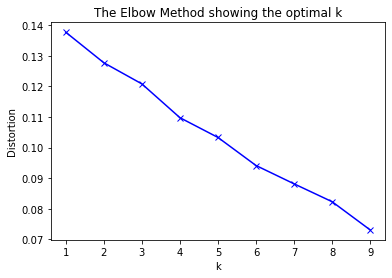

In [38]:
# We can also determine the best number of cluster "k" using the "elbow" method
# The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters. 
# By default, the distortion score is computed, the sum of square distances from each point to its assigned center.

from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Madrid_grouped_clustering)
    kmeanModel.fit(Madrid_grouped_clustering)
    distortions.append(sum(np.min(cdist(Madrid_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Madrid_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##### Create a new dataframe that includes the cluster labels as well as the top 10 venues for each neighborhood.

In [39]:
#Let's put Cluster Labels as the first ,0, column in the District_venues_sorted we created earlier.

District_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Define Madrid_merged and join the different datasets

Madrid_merged = Madrid_geo

# As we already aligned the name "District" on both datasets before, this is going to be an easy merge

Madrid_merged = Madrid_merged.join(District_venues_sorted.set_index('District'), on='District')

Madrid_merged

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Madrid Centro,522.82,131928,252.34,40.41831,-3.70275,1,Restaurant,Plaza,Hotel,Tapas Restaurant,Café,Theater,Bookstore,Mediterranean Restaurant,Cocktail Bar,Spanish Restaurant
1,Arganzuela,646.22,151965,235.16,40.40021,-3.69618,1,Plaza,Park,Restaurant,Café,Coffee Shop,Art Gallery,Art Museum,Pizza Place,Market,Spanish Restaurant
2,Distrito del Retiro,546.62,118516,216.82,40.41317,-3.68307,1,Restaurant,Spanish Restaurant,Plaza,Hotel,Art Museum,Monument / Landmark,Café,Garden,Tapas Restaurant,Mediterranean Restaurant
3,Salamanca,539.24,143800,266.67,40.42972,-3.67975,2,Spanish Restaurant,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Coffee Shop,Indian Restaurant,Bakery,Japanese Restaurant,Boutique,Burger Joint
4,Chamartín,917.55,143424,156.31,40.45000,-3.70000,2,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,Pizza Place,Japanese Restaurant,Restaurant,Ice Cream Shop,Hotel,Seafood Restaurant,Bar
5,Tetuán,537.47,153789,286.13,40.46667,-3.71667,5,Spanish Restaurant,Bar,Tapas Restaurant,Park,Seafood Restaurant,Supermarket,Gym / Fitness Center,Pizza Place,Kebab Restaurant,Bakery
6,Chamberí,467.92,137401,293.64,40.43404,-3.70379,1,Restaurant,Tapas Restaurant,Café,Plaza,Italian Restaurant,Cocktail Bar,Ice Cream Shop,Bar,Burger Joint,Japanese Restaurant
7,Fuencarral-El Pardo,23783.84,238756,10.04,40.49840,-3.73140,5,Chinese Restaurant,Brewery,Bar,Park,Restaurant,Spanish Restaurant,Café,Food & Drink Shop,Pub,Sports Club
8,Moncloa-Aravaca,4653.11,116903,25.12,40.43547,-3.73170,2,Spanish Restaurant,Tapas Restaurant,Restaurant,Park,Coffee Shop,Café,Sandwich Place,Hotel,Bar,Supermarket
9,Latina,2542.72,233808,91.95,40.38897,-3.74569,4,Tapas Restaurant,Grocery Store,Pizza Place,Bar,Fast Food Restaurant,Italian Restaurant,Restaurant,Park,Concert Hall,Plaza


In [40]:
# We need to align the district names with the geojson file that we are going to use in our map later

Madrid_merged = Madrid_merged.replace(['Madrid Centro'],'Centro')
Madrid_merged = Madrid_merged.replace(['Distrito de Barajas'],'Barajas')
Madrid_merged = Madrid_merged.replace(['Distrito del Retiro'],'Retiro')
Madrid_merged = Madrid_merged.replace(['Vicálvaro'],'Vicalvaro')
Madrid_merged = Madrid_merged.replace(['Chamartín'],'Chamartin')
Madrid_merged = Madrid_merged.replace(['Tetuán'],'Tetuan')
Madrid_merged = Madrid_merged.replace(['Chamberí'],'Chamberi')
Madrid_merged = Madrid_merged.replace(['San Blas-Canillejas'],'San Blas')

In [41]:
# Let's drop the rows with null values
Madrid_merged.dropna(inplace=True)

In [42]:
# Checking the data types after the merge
Madrid_merged.dtypes

District                         object
District area[n 1] (Ha.)        float64
Population                        int64
Population density(Hab./Ha.)    float64
Latitude                        float64
Longitude                       float64
Cluster Labels                    int32
1st Most Common Venue            object
2nd Most Common Venue            object
3rd Most Common Venue            object
4th Most Common Venue            object
5th Most Common Venue            object
6th Most Common Venue            object
7th Most Common Venue            object
8th Most Common Venue            object
9th Most Common Venue            object
10th Most Common Venue           object
dtype: object

##### Visualize the clusters

In [43]:
# Let's create a map that shows our clusters in different colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Madrid_merged['Latitude'],Madrid_merged['Longitude'],Madrid_merged['District'],Madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=35,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###### Binning

We have the interesting variables Population and "Population density(Hab./Ha.)" 

We can bin them by density into 5 distinct values.
(Very Sparse, Sparse, Normal, Dense, Very Dense)

Text(0.5, 1.0, 'Density bins')

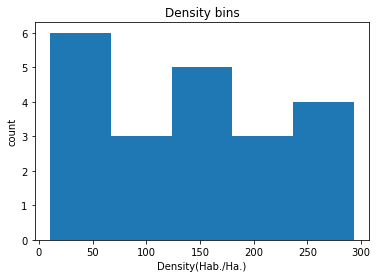

In [44]:
# Visualizing the Density(Hab./Ha.) bins

%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(Madrid_merged["Population density(Hab./Ha.)"],bins=5)

# set x/y labels and plot title
plt.pyplot.xlabel("Density(Hab./Ha.)")
plt.pyplot.ylabel("count")
plt.pyplot.title("Density bins")

Text(0.5, 1.0, 'Population bins')

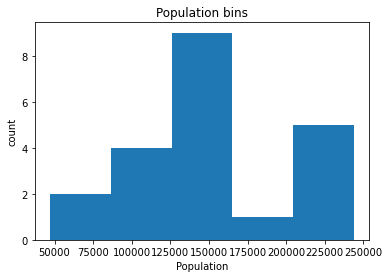

In [45]:
# Visualizing the Population bins

%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(Madrid_merged["Population"],bins=5)

# set x/y labels and plot title
plt.pyplot.xlabel("Population")
plt.pyplot.ylabel("count")
plt.pyplot.title("Population bins")

In [46]:
# Lets create the variable Pbins so we can use the data later

Pbins = np.linspace(min(Madrid_merged["Population"]), max(Madrid_merged["Population"]), 6)
Pbins

array([ 46876. ,  86300.4, 125724.8, 165149.2, 204573.6, 243998. ])

In [47]:
# Create the density value names

Pbins_names = ['Very Sparse','Sparse','Normal', 'Dense','Very Dense']

In [48]:
# Add the new variable to the Madrid_Merged dataset

Madrid_merged['Density Level'] = pd.cut(Madrid_merged['Population'], Pbins, labels=Pbins_names, include_lowest=True )
Madrid_merged[['Density Level','Population']].head()

,Density Level,Population
0,Normal,131928
1,Normal,151965
2,Sparse,118516
3,Normal,143800
4,Normal,143424


##### Cluster bins

Text(0.5, 1.0, 'Cluster Labels')

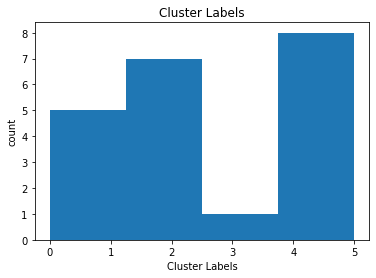

In [49]:
#Creating 4 bins for the 6 clusters we crated earlier

plt.pyplot.hist(Madrid_merged["Cluster Labels"],bins=4)

# set x/y labels and plot title
plt.pyplot.xlabel("Cluster Labels")
plt.pyplot.ylabel("count")
plt.pyplot.title("Cluster Labels")

In [50]:
# Create the variable Cbins

Cbins = np.linspace(min(Madrid_merged["Cluster Labels"]), max(Madrid_merged["Cluster Labels"]), 5)
Cbins

array([0.  , 1.25, 2.5 , 3.75, 5.  ])

In [51]:
# Create the cluster bins names

Cbins_names = ['Restaurants and traditional cuisine','Plazas and historic places','Parks and bars','Supermarkets and train stations']

In [52]:
# Add the new variable to the Madrid_Merged dataset

Madrid_merged['Cluster-Category'] = pd.cut(Madrid_merged['Cluster Labels'], Cbins, labels=Cbins_names, include_lowest=True )
Madrid_merged[['Cluster Labels','Cluster-Category']].head

<bound method NDFrame.head of     Cluster Labels                     Cluster-Category
0                1  Restaurants and traditional cuisine
1                1  Restaurants and traditional cuisine
2                1  Restaurants and traditional cuisine
3                2           Plazas and historic places
4                2           Plazas and historic places
5                5      Supermarkets and train stations
6                1  Restaurants and traditional cuisine
7                5      Supermarkets and train stations
8                2           Plazas and historic places
9                4      Supermarkets and train stations
10               0  Restaurants and traditional cuisine
11               5      Supermarkets and train stations
12               5      Supermarkets and train stations
13               5      Supermarkets and train stations
14               2           Plazas and historic places
15               2           Plazas and historic places
16               4

### Final Data Set

In [53]:
# Let's drop the less interesting columns
Madrid_merged.drop(columns=['7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue'],inplace=True)

In [54]:
# This is our final dataset
Madrid_merged

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Density Level,Cluster-Category
0,Centro,522.82,131928,252.34,40.41831,-3.70275,1,Restaurant,Plaza,Hotel,Tapas Restaurant,Café,Theater,Normal,Restaurants and traditional cuisine
1,Arganzuela,646.22,151965,235.16,40.40021,-3.69618,1,Plaza,Park,Restaurant,Café,Coffee Shop,Art Gallery,Normal,Restaurants and traditional cuisine
2,Retiro,546.62,118516,216.82,40.41317,-3.68307,1,Restaurant,Spanish Restaurant,Plaza,Hotel,Art Museum,Monument / Landmark,Sparse,Restaurants and traditional cuisine
3,Salamanca,539.24,143800,266.67,40.42972,-3.67975,2,Spanish Restaurant,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Coffee Shop,Indian Restaurant,Normal,Plazas and historic places
4,Chamartin,917.55,143424,156.31,40.45000,-3.70000,2,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,Pizza Place,Japanese Restaurant,Restaurant,Normal,Plazas and historic places
5,Tetuan,537.47,153789,286.13,40.46667,-3.71667,5,Spanish Restaurant,Bar,Tapas Restaurant,Park,Seafood Restaurant,Supermarket,Normal,Supermarkets and train stations
6,Chamberi,467.92,137401,293.64,40.43404,-3.70379,1,Restaurant,Tapas Restaurant,Café,Plaza,Italian Restaurant,Cocktail Bar,Normal,Restaurants and traditional cuisine
7,Fuencarral-El Pardo,23783.84,238756,10.04,40.49840,-3.73140,5,Chinese Restaurant,Brewery,Bar,Park,Restaurant,Spanish Restaurant,Very Dense,Supermarkets and train stations
8,Moncloa-Aravaca,4653.11,116903,25.12,40.43547,-3.73170,2,Spanish Restaurant,Tapas Restaurant,Restaurant,Park,Coffee Shop,Café,Sparse,Plazas and historic places
9,Latina,2542.72,233808,91.95,40.38897,-3.74569,4,Tapas Restaurant,Grocery Store,Pizza Place,Bar,Fast Food Restaurant,Italian Restaurant,Very Dense,Supermarkets and train stations


#### Creating Chloropleth map to visualize how Madrid is divided in terms of Density prices and cluster markers on the top

In [55]:
!pip install geopandas

     |████████████████████████████████| 962 kB 17.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 17.1 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 53.9 MB/s eta 0:00:01


In [56]:
!conda install -c anaconda xlrd --yes

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - xlrd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB  anaconda
    _py-xgboost-mutex-2.0      |            cpu_0           9 KB  anaconda
    _pytorch_select-0.1        |            cpu_0           2 KB  anaconda
    absl-py-0.10.0             |           py37_0         169 KB  anaconda
    aiohttp-3.6.3              |   py37h7b6447c_0         626 KB  anaconda
    argon2-cffi-20.1.0         |   py37h7b6447c_1          49

bleach-3.2.1         | 111 KB    | ##################################### | 100% 
krb5-1.17.1          | 1.5 MB    | ##################################### | 100% 
tqdm-4.50.2          | 55 KB     | ##################################### | 100% 
kiwisolver-1.2.0     | 91 KB     | ##################################### | 100% 
grpcio-1.31.0        | 2.2 MB    | ##################################### | 100% 
mkl_fft-1.2.0        | 164 KB    | ##################################### | 100% 
ninja-1.10.1         | 1.9 MB    | ##################################### | 100% 
idna-2.10            | 56 KB     | ##################################### | 100% 
jmespath-0.10.0      | 22 KB     | ##################################### | 100% 
ibm-wsrt-py37main-ma | 2 KB      | ##################################### | 100% 
cachetools-4.1.1     | 12 KB     | ##################################### | 100% 
retrying-1.3.3       | 15 KB     | ##################################### | 100% 
dask-core-2.30.0     | 639 K

xz-5.2.5             | 438 KB    | ##################################### | 100% 
tk-8.6.10            | 3.2 MB    | ##################################### | 100% 
pytorch-1.5.0        | 33.3 MB   | ##################################### | 100% 
snowballstemmer-2.0. | 58 KB     | ##################################### | 100% 
absl-py-0.10.0       | 169 KB    | ##################################### | 100% 
prompt-toolkit-3.0.8 | 244 KB    | ##################################### | 100% 
fontconfig-2.13.0    | 291 KB    |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/fontconfig-2.13.0-h9420a91_0/include/fontconfig/fcprivate.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/fontconfig-2.13.0-h9420a91_0/include/fontconfig/fontconfig.h.  Please rem

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/fontconfig-2.13.0-h9420a91_0/etc/fonts/conf.d/65-nonlatin.conf.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/fontconfig-2.13.0-h9420a91_0/etc/fonts/conf.d/10-scale-bitmap-fonts.conf.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/fontconfig-2.13.0-h9420a91_0/etc/fonts/conf.d/49-sansserif.conf.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/fontconfig-2.13.0-h9420a91_0/etc/fonts/conf.d/20-unhint-small-vera.conf.  Please remove this file manually (you may n

pip-20.2.4           | 2.0 MB    | ##################################### | 100% 
pymssql-2.1.5        | 228 KB    | ##################################### | 100% 
_pytorch_select-0.1  | 2 KB      | ##################################### | 100% 
certifi-2020.6.20    | 159 KB    | ##################################### | 100% 
secretstorage-3.1.2  | 23 KB     | ##################################### | 100% 
importlib-metadata-2 | 35 KB     | ##################################### | 100% 
tifffile-2020.10.1   | 260 KB    | ##################################### | 100% 
notebook-6.1.4       | 6.3 MB    | ##################################### | 100% 
bokeh-2.2.3          | 7.0 MB    | ##################################### | 100% 
libtiff-4.1.0        | 607 KB    |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libtiff-4.1.0-h2733197_1/include/tiffconf.h.  Please remove this file manually (y

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libtiff-4.1.0-h2733197_1/include/tiffio.hxx.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libtiff-4.1.0-h2733197_1/include/tiffvers.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libtiff-4.1.0-h2733197_1/include/tiff.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libtiff-4.1.0-h2733197_1/include/tiffio.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140):

prometheus_client-0. | 48 KB     | ##################################### | 100% 
click-7.1.2          | 67 KB     | ##################################### | 100% 
tabulate-0.8.7       | 40 KB     | ##################################### | 100% 
setuptools-50.3.0    | 904 KB    | ##################################### | 100% 
libpng-1.6.37        | 364 KB    |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libpng-1.6.37-hbc83047_0/include/libpng16/pngconf.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libpng-1.6.37-hbc83047_0/include/libpng16/pnglibconf.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pk

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libpng-1.6.37-hbc83047_0/include/libpng16/pnglibconf.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libpng-1.6.37-hbc83047_0/include/libpng16/png.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libpng-1.6.37-hbc83047_0/include/pngconf.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libpng-1.6.37-hbc83047_0/include/pnglibconf.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or

pandoc-2.11          | 12.5 MB   | ##################################### | 100% 
matplotlib-3.3.1     | 24 KB     | ##################################### | 100% 
bzip2-1.0.8          | 105 KB    | ##################################### | 100% 
blas-1.0             | 6 KB      | ##################################### | 100% 
jinja2-2.11.2        | 97 KB     | ##################################### | 100% 
markdown-3.3.2       | 123 KB    | ##################################### | 100% 
ptyprocess-0.6.0     | 23 KB     | ##################################### | 100% 
pcre-8.44            | 269 KB    | ##################################### | 100% 
libprotobuf-3.13.0.1 | 2.3 MB    | ##################################### | 100% 
astor-0.8.1          | 45 KB     | ##################################### | 100% 
pyjwt-1.7.1          | 32 KB     |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/pyjwt-1.7.1-py37_0/lib/python3.7/site-packages/jwt/contrib/__init__.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/pyjwt-1.7.1-py37_0/lib/python3.7/site-packages/jwt/compat.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/pyjwt-1.7.1-py37_0/lib/python3.7/site-packages/jwt/algorithms.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/pyjwt-1.7.1-py37_0/lib/python3.7/site-packages/jwt/api_jws.py.  Please remove this file manually (you may need to reboot

cytoolz-0.11.0       | 367 KB    | ##################################### | 100% 
pytest-6.1.1         | 418 KB    | ##################################### | 100% 
psycopg2-2.8.5       | 172 KB    | ##################################### | 100% 
jupyterlab-2.2.6     | 5.9 MB    | ##################################### | 100% 
ncurses-6.2          | 1.1 MB    |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/include/ncurses/nc_tparm.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/include/ncurses/eti.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/p/prism14-w.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/p/pcvt43.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/p/p14-w.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/p/p14.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rena

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/c/concept-avt.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/c/citoh-prop.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/c/c100.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/c/cit101e-132.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:u

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/s/screen4.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/s/screen.putty-m1b.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/s/scoansi-new.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/s/sbi.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/a/aaa-db.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/a/att4415+nl.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/a/aaa-rv-ctxt.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/a/aaa-24.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unli

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/d/d412+w.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/d/dw4.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/d/d470.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/d/dtc300s.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/lib/libmenu.a.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/lib/libformw.a.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/lib/libncurses.so.6.2.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/lib/libncurses++w.a.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could 

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/o/opennt-w-vt.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/o/opennt-60-nti.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/o/old-st.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/o/oconcept.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/m/megatek.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/m/mime3ax.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/m/mgr-linux.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/c/cci1.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/s/screen-s.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/s/screen+fkeys.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/s/stterm.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/s/screen-bce.konsole.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/a/avt-w-rv-s.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/a/aaa-48.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/a/aws.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/a/ampex175.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/d/d413-unix-w.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/d/dg-generic.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/d/diablo1640-m8.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/ncurses-6.2-he6710b0_1/share/terminfo/d/dec+pp.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.dele

_libgcc_mutex-0.1    | 3 KB      | ##################################### | 100% 
libxgboost-0.90      | 3.8 MB    | ##################################### | 100% 
cx_oracle-8.0.1      | 186 KB    | ##################################### | 100% 
sympy-1.6.2          | 10.5 MB   | ##################################### | 100% 
entrypoints-0.3      | 12 KB     |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/entrypoints-0.3-py37_0/info/recipe/meta.yaml.template.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/entrypoints-0.3-py37_0/info/recipe/conda_build_config.yaml.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/co

scikit-image-0.17.2  | 10.7 MB   | ##################################### | 100% 
libgcc-ng-9.1.0      | 8.1 MB    | ##################################### | 100% 
pyasn1-0.4.8         | 58 KB     | ##################################### | 100% 
cffi-1.14.3          | 224 KB    | ##################################### | 100% 
nbconvert-6.0.7      | 530 KB    | ##################################### | 100% 
blosc-1.19.0         | 81 KB     | ##################################### | 100% 
xlsxwriter-1.3.7     | 104 KB    | ##################################### | 100% 
libffi-3.3           | 54 KB     | ##################################### | 100% 
docutils-0.15.2      | 736 KB    | ##################################### | 100% 
werkzeug-1.0.1       | 243 KB    | ##################################### | 100% 
unixodbc-2.3.9       | 299 KB    | ##################################### | 100% 
mkl-service-2.3.0    | 208 KB    | ##################################### | 100% 
future-0.18.2        | 720 K

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/lz4-c-1.9.2-heb0550a_3/include/lz4hc.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/lz4-c-1.9.2-heb0550a_3/include/lz4frame_static.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/lz4-c-1.9.2-heb0550a_3/include/lz4.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/lz4-c-1.9.2-heb0550a_3/include/lz4frame.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Co

keras-applications-1 | 30 KB     | ##################################### | 100% 
mistune-0.8.4        | 53 KB     |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/mistune-0.8.4-py37h14c3975_1001/info/test/tests/fixtures/data/math.md.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/mistune-0.8.4-py37h14c3975_1001/info/test/tests/fixtures/data/math-paragraph.md.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/mistune-0.8.4-py37h14c3975_1001/info/test/tests/fixtures/data/tree.md.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_r

statsmodels-0.12.0   | 10.9 MB   | ##################################### | 100% 
jpeg-9b              | 247 KB    | ##################################### | 100% 
readline-8.0         | 428 KB    | ##################################### | 100% 
nest-asyncio-1.4.1   | 10 KB     | ##################################### | 100% 
brotlipy-0.7.0       | 348 KB    | ##################################### | 100% 
zeromq-4.3.3         | 678 KB    | ##################################### | 100% 
matplotlib-base-3.3. | 6.7 MB    | ##################################### | 100% 
jeepney-0.4.3        | 22 KB     | ##################################### | 100% 
json5-0.9.5          | 22 KB     | ##################################### | 100% 
tensorflow-base-2.1. | 166.1 MB  | ##################################### | 100% 
botocore-1.19.1      | 4.2 MB    | ##################################### | 100% 
freetds-1.00.97      | 2.4 MB    | ##################################### | 100% 
sip-4.19.24          | 297 K

mkl_random-1.1.0     | 376 KB    | ##################################### | 100% 
pysocks-1.7.1        | 27 KB     | ##################################### | 100% 
cycler-0.10.0        | 13 KB     | ##################################### | 100% 
pandocfilters-1.4.2  | 13 KB     |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/pandocfilters-1.4.2-py37_1/info/test/run_test.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/pandocfilters-1.4.2-py37_1/info/recipe/meta.yaml.template.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/pandocfilters-1.4.2-py37_1/info/recipe/conda_build_config.yaml.  Please remove

jupyter_client-6.1.7 | 76 KB     |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/jupyter_client-6.1.7-py_0/site-packages/jupyter_client-6.1.7.dist-info/COPYING.md.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/jupyter_client-6.1.7-py_0/site-packages/jupyter_client-6.1.7.dist-info/direct_url.json.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/jupyter_client-6.1.7-py_0/site-packages/jupyter_client-6.1.7.dist-info/REQUESTED.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /op

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/jupyter_client-6.1.7-py_0/site-packages/jupyter_client/channelsabc.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/jupyter_client-6.1.7-py_0/site-packages/jupyter_client/managerabc.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/jupyter_client-6.1.7-py_0/site-packages/jupyter_client/connect.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/jupyter_client-6.1.7-py_0/site-packages/jupyter_client/consoleapp.py.  Please remove this file manually (you may

threadpoolctl-2.1.0  | 16 KB     | ##################################### | 100% 
olefile-0.46         | 48 KB     | ##################################### | 100% 
python-dateutil-2.8. | 224 KB    | ##################################### | 100% 
joblib-0.17.0        | 205 KB    | ##################################### | 100% 
gmp-6.1.2            | 744 KB    | ##################################### | 100% 
requests-2.24.0      | 54 KB     | ##################################### | 100% 
networkx-2.5         | 1.2 MB    | ##################################### | 100% 
py-1.9.0             | 78 KB     | ##################################### | 100% 
dbus-1.13.18         | 586 KB    | ##################################### | 100% 
iniconfig-1.1.1      | 8 KB      | ##################################### | 100% 
multidict-4.7.6      | 69 KB     | ##################################### | 100% 
pandas-1.1.3         | 10.5 MB   | ##################################### | 100% 
gstreamer-1.14.0     | 3.8 M

ipykernel-5.3.4      | 176 KB    | ##################################### | 100% 
six-1.15.0           | 13 KB     | ##################################### | 100% 
testpath-0.4.4       | 88 KB     | ##################################### | 100% 
ca-certificates-2020 | 128 KB    | ##################################### | 100% 
ipython-7.18.1       | 1.1 MB    | ##################################### | 100% 
pyyaml-5.3.1         | 191 KB    | ##################################### | 100% 
regex-2020.10.15     | 358 KB    | ##################################### | 100% 
jupyterlab_server-1. | 24 KB     | ##################################### | 100% 
sqlite-3.33.0        | 2.0 MB    | ##################################### | 100% 
plotly-4.11.0        | 5.9 MB    | ##################################### | 100% 
google-auth-oauthlib | 21 KB     | ##################################### | 100% 
traitlets-5.0.5      | 81 KB     | ##################################### | 100% 
nbformat-5.0.8       | 101 K

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/icu-58.2-he6710b0_3/share/man/man8/gensprep.8.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/icu-58.2-he6710b0_3/share/man/man8/icupkg.8.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/icu-58.2-he6710b0_3/share/man/man8/gencmn.8.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/icu-58.2-he6710b0_3/share/man/man8/genccode.8.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_t

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/icu-58.2-he6710b0_3/info/recipe/icu4c-4_9_1-mingw-w64-mkdir-compatibility.patch.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/icu-58.2-he6710b0_3/info/recipe/CVE-2017-15422.patch.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/icu-58.2-he6710b0_3/info/recipe/CVE-2017-7867_CVE-2017-7868.patch.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/icu-58.2-he6710b0_3/info/recipe/bld.bat.  Please remove this file manually (you may need to reboot to free file handle

jupyter_core-4.6.3   | 75 KB     | ##################################### | 100% 
parso-0.7.0          | 71 KB     | ##################################### | 100% 
pyodbc-4.0.30        | 72 KB     | ##################################### | 100% 
libxcb-1.14          | 610 KB    |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxcb-1.14-h7b6447c_0/include/xcb/xv.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxcb-1.14-h7b6447c_0/include/xcb/xinput.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxcb-1.14-h7b6447c_0/include/xcb/glx.h.  Please remove this file manually (you may need to reboot t

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxcb-1.14-h7b6447c_0/lib/libxcb-xfixes.so.0.0.0.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxcb-1.14-h7b6447c_0/lib/libxcb-dri2.so.0.0.0.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxcb-1.14-h7b6447c_0/lib/libxcb-xv.so.0.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxcb-1.14-h7b6447c_0/lib/libxcb-dri3.so.0.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_

pytz-2020.1          | 239 KB    | ##################################### | 100% 
google-auth-1.22.1   | 62 KB     | ##################################### | 100% 
astropy-4.0.2        | 7.6 MB    | ##################################### | 100% 
backcall-0.2.0       | 14 KB     | ##################################### | 100% 
pyshp-2.1.0          | 34 KB     | ##################################### | 100% 
imageio-2.9.0        | 3.1 MB    | ##################################### | 100% 
chardet-3.0.4        | 173 KB    | ##################################### | 100% 
openssl-1.1.1h       | 3.8 MB    | ##################################### | 100% 
pygments-2.7.1       | 704 KB    | ##################################### | 100% 
tornado-6.0.4        | 649 KB    | ##################################### | 100% 
pyqt-5.9.2           | 5.6 MB    | ##################################### | 100% 
scipy-1.5.2          | 18.5 MB   | ##################################### | 100% 
libsodium-1.0.18     | 387 K

yarl-1.6.2           | 139 KB    | ##################################### | 100% 
lxml-4.6.1           | 1.3 MB    | ##################################### | 100% 
zlib-1.2.11          | 120 KB    | ##################################### | 100% 
intel-openmp-2020.2  | 947 KB    | ##################################### | 100% 
ipython_genutils-0.2 | 39 KB     | ##################################### | 100% 
more-itertools-8.5.0 | 42 KB     | ##################################### | 100% 
dill-0.3.2           | 65 KB     | ##################################### | 100% 
qt-5.9.7             | 85.9 MB   | ##################################### | 100% 
hdf5-1.10.4          | 5.3 MB    | ##################################### | 100% 
cryptography-3.1.1   | 625 KB    | ##################################### | 100% 
wheel-0.35.1         | 36 KB     | ##################################### | 100% 
libgfortran-ng-7.3.0 | 1.3 MB    | ##################################### | 100% 
mock-4.0.2           | 31 KB

pyopenssl-19.1.0     | 47 KB     | ##################################### | 100% 
gast-0.2.2           | 137 KB    | ##################################### | 100% 
libxml2-2.9.10       | 1.3 MB    | 4                                     |   1% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxml2-2.9.10-hb55368b_3/include/libxml2/libxml/parserInternals.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxml2-2.9.10-hb55368b_3/include/libxml2/libxml/SAX.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxml2-2.9.10-hb55368b_3/include/libxml2/libxml/xinclude.h.  Please remove this file manually (you may need to reboot to free file handles)
WAR

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxml2-2.9.10-hb55368b_3/include/libxml2/libxml/parserInternals.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxml2-2.9.10-hb55368b_3/include/libxml2/libxml/SAX.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxml2-2.9.10-hb55368b_3/include/libxml2/libxml/xinclude.h.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/libxml2-2.9.10-hb55368b_3/include/libxml2/libxml/HTMLtree.h.  Please remove this file manually (you may need to reboot to free file han

pluggy-0.13.1        | 32 KB     | ##################################### | 100% 
freetype-2.10.4      | 901 KB    | ##################################### | 100% 
async_generator-1.10 | 38 KB     | ##################################### | 100% 
pycparser-2.20       | 94 KB     | ##################################### | 100% 
nltk-3.5             | 1.1 MB    | ##################################### | 100% 
ld_impl_linux-64-2.3 | 645 KB    | ##################################### | 100% 
markupsafe-1.1.1     | 26 KB     |                                       |   0% WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/markupsafe-1.1.1-py37h14c3975_1/info/test/run_test.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/conda/pkgs/markupsafe-1.1.1-py37h14c3975_1/info/recipe/meta.yaml.template.  Please remove 

google-pasta-0.2.0   | 44 KB     | ##################################### | 100% 
lcms2-2.11           | 419 KB    | ##################################### | 100% 

InvalidArchiveError('Error with archive /opt/conda/pkgs/pyparsing-2.4.7-py_0.tar.bz2.  You probably need to delete and re-download or re-create this file.  Message from libarchive was:\n\nCould not unlink')
InvalidArchiveError('Error with archive /opt/conda/pkgs/fontconfig-2.13.0-h9420a91_0.tar.bz2.  You probably need to delete and re-download or re-create this file.  Message from libarchive was:\n\nCould not unlink')
InvalidArchiveError('Error with archive /opt/conda/pkgs/libtiff-4.1.0-h2733197_1.tar.bz2.  You probably need to delete and re-download or re-create this file.  Message from libarchive was:\n\nCould not unlink')
InvalidArchiveError('Error with archive /opt/conda/pkgs/defusedxml-0.6.0-py_0.tar.bz2.  You probably need to delete and re-download or re-create this file.  Message from libarchive was:\n\nCould not unlin

In [57]:
# Let's fine a suitable map of Madrid, some browsing on GitHub provided this:
# https://github.com/codeforamerica/click_that_hood/blob/master/public/data/madrid-districts.geojson
# I created the variable ext that defines the coordinates and names of our final map
ext = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{"name":"Centro","cartodb_id":1,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.691853,40.408527],[-3.691893,40.408377],[-3.691919,40.408167],[-3.692368,40.408309],[-3.692541,40.408438],[-3.692594,40.408467],[-3.692657,40.408475],[-3.692796,40.408454],[-3.69398,40.408134],[-3.694102,40.408179],[-3.696566,40.407529],[-3.696634,40.407509],[-3.698068,40.40711],[-3.698772,40.406915],[-3.699676,40.406683],[-3.701244,40.40625],[-3.701663,40.406245],[-3.702577,40.406379],[-3.705198,40.40686],[-3.707094,40.40725],[-3.708229,40.407459],[-3.708605,40.407511],[-3.709974,40.407743],[-3.710369,40.407846],[-3.710739,40.407926],[-3.712384,40.408625],[-3.713922,40.409264],[-3.715461,40.409879],[-3.717029,40.412294],[-3.716542,40.413259],[-3.71563,40.415097],[-3.71723,40.415095],[-3.718123,40.415116],[-3.718328,40.415121],[-3.719186,40.415134],[-3.721644,40.415171],[-3.721541,40.416513],[-3.72107,40.418356],[-3.720851,40.419217],[-3.720744,40.419641],[-3.720533,40.419762],[-3.7202,40.419952],[-3.719757,40.4203],[-3.71939,40.420651],[-3.71909,40.421076],[-3.718989,40.42125],[-3.718886,40.421426],[-3.71888,40.421436],[-3.716751,40.421506],[-3.715493,40.421523],[-3.71467,40.421535],[-3.714195,40.421584],[-3.714195,40.421584],[-3.712587,40.422659],[-3.712072,40.423003],[-3.712022,40.423086],[-3.711865,40.42324],[-3.711734,40.423369],[-3.710413,40.424145],[-3.709853,40.424473],[-3.709608,40.424603],[-3.709585,40.424615],[-3.710398,40.425485],[-3.711148,40.426541],[-3.711864,40.427588],[-3.712587,40.428644],[-3.712823,40.428965],[-3.713218,40.429502],[-3.714286,40.430955],[-3.714886,40.431784],[-3.714919,40.431829],[-3.713324,40.431649],[-3.712214,40.431542],[-3.710552,40.431375],[-3.709194,40.431236],[-3.707519,40.431061],[-3.706824,40.430989],[-3.706821,40.430988],[-3.706408,40.430945],[-3.706187,40.430929],[-3.706104,40.430923],[-3.704497,40.430786],[-3.702336,40.430422],[-3.701097,40.43024],[-3.700637,40.430156],[-3.698101,40.429607],[-3.695819,40.429122],[-3.694453,40.428823],[-3.693812,40.428525],[-3.692527,40.427906],[-3.690084,40.426667],[-3.689146,40.426443],[-3.68991,40.424304],[-3.69178,40.420516],[-3.691663,40.420062],[-3.691857,40.419659],[-3.692172,40.418123],[-3.692295,40.417526],[-3.69233,40.417064],[-3.692133,40.416316],[-3.691893,40.415215],[-3.691588,40.413819],[-3.691341,40.41265],[-3.691058,40.411382],[-3.690909,40.410889],[-3.690631,40.410263],[-3.690716,40.409878],[-3.690547,40.409617],[-3.691252,40.409184],[-3.691526,40.408957],[-3.69166,40.4088],[-3.69166,40.4088],[-3.691702,40.408752],[-3.691853,40.408527]]]]}},{"type":"Feature","properties":{"name":"Arganzuela","cartodb_id":2,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.702577,40.406379],[-3.701663,40.406245],[-3.701244,40.40625],[-3.699676,40.406683],[-3.698772,40.406915],[-3.698068,40.40711],[-3.696634,40.407509],[-3.696566,40.407529],[-3.694102,40.408179],[-3.69398,40.408134],[-3.692796,40.408454],[-3.692657,40.408475],[-3.692594,40.408467],[-3.692541,40.408438],[-3.692368,40.408309],[-3.691919,40.408167],[-3.691893,40.408377],[-3.691853,40.408527],[-3.691702,40.408752],[-3.69166,40.4088],[-3.69166,40.4088],[-3.691526,40.408957],[-3.691252,40.409184],[-3.690547,40.409617],[-3.690198,40.409331],[-3.690088,40.409292],[-3.689869,40.409168],[-3.689515,40.408937],[-3.688943,40.408512],[-3.688905,40.408537],[-3.68857,40.408302],[-3.687853,40.407903],[-3.687561,40.407723],[-3.687308,40.407567],[-3.68648,40.406811],[-3.685388,40.405816],[-3.683358,40.404409],[-3.683327,40.404398],[-3.681291,40.403572],[-3.681213,40.40354],[-3.681203,40.403539],[-3.681154,40.403531],[-3.68106,40.403533],[-3.680984,40.403552],[-3.680767,40.403451],[-3.679905,40.40305],[-3.679302,40.402769],[-3.678768,40.40252],[-3.678326,40.402238],[-3.678294,40.402218],[-3.677734,40.40198],[-3.675487,40.400136],[-3.674986,40.399848],[-3.674642,40.399589],[-3.674391,40.3994],[-3.673743,40.39872],[-3.673647,40.398569],[-3.673123,40.397755],[-3.672213,40.395499],[-3.672212,40.395496],[-3.673233,40.394931],[-3.673949,40.394445],[-3.675123,40.393502],[-3.676257,40.392666],[-3.67698,40.392091],[-3.67741,40.391682],[-3.677841,40.391175],[-3.6814,40.38579],[-3.681545,40.385627],[-3.681775,40.385449],[-3.681803,40.385427],[-3.682078,40.385276],[-3.682516,40.385087],[-3.682884,40.385],[-3.683003,40.384972],[-3.683556,40.384882],[-3.685713,40.384533],[-3.685985,40.384458],[-3.686927,40.384199],[-3.687235,40.384102],[-3.687337,40.38407],[-3.687377,40.384055],[-3.68759,40.383973],[-3.687855,40.383878],[-3.688022,40.383819],[-3.688814,40.383384],[-3.691002,40.385335],[-3.69431,40.388165],[-3.696782,40.390278],[-3.698248,40.391828],[-3.701085,40.394827],[-3.702068,40.395635],[-3.703091,40.396267],[-3.703332,40.396416],[-3.706035,40.397077],[-3.70692,40.397291],[-3.707477,40.397459],[-3.708389,40.397734],[-3.708985,40.397983],[-3.709495,40.398195],[-3.710078,40.398513],[-3.710856,40.399073],[-3.711428,40.399538],[-3.711875,40.399926],[-3.712138,40.400141],[-3.712744,40.400528],[-3.71359,40.40085],[-3.714592,40.401101],[-3.715111,40.401167],[-3.715465,40.401179],[-3.715765,40.401163],[-3.716001,40.40114],[-3.717654,40.401015],[-3.717698,40.401012],[-3.718007,40.401017],[-3.718425,40.401077],[-3.71868,40.401131],[-3.719045,40.401267],[-3.719822,40.401693],[-3.720399,40.402127],[-3.720526,40.402332],[-3.720639,40.402515],[-3.72091,40.403145],[-3.720942,40.403255],[-3.721088,40.403748],[-3.721272,40.404987],[-3.721348,40.405365],[-3.721411,40.405727],[-3.721434,40.406399],[-3.721339,40.407008],[-3.721057,40.407924],[-3.720952,40.408232],[-3.720909,40.408355],[-3.720513,40.409687],[-3.721302,40.41256],[-3.721456,40.412895],[-3.721562,40.413089],[-3.721591,40.413154],[-3.721609,40.413194],[-3.721615,40.413547],[-3.721615,40.413557],[-3.721644,40.415171],[-3.719186,40.415134],[-3.718328,40.415121],[-3.718123,40.415116],[-3.71723,40.415095],[-3.71563,40.415097],[-3.716542,40.413259],[-3.717029,40.412294],[-3.715461,40.409879],[-3.713922,40.409264],[-3.712384,40.408625],[-3.710739,40.407926],[-3.710369,40.407846],[-3.709974,40.407743],[-3.708605,40.407511],[-3.708229,40.407459],[-3.707094,40.40725],[-3.705198,40.40686],[-3.702577,40.406379]]]]}},{"type":"Feature","properties":{"name":"Retiro","cartodb_id":3,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.662786,40.409705],[-3.663843,40.407637],[-3.663902,40.407522],[-3.664257,40.406738],[-3.665022,40.405046],[-3.665386,40.404074],[-3.665477,40.403804],[-3.666968,40.400817],[-3.667949,40.399505],[-3.668319,40.399012],[-3.668747,40.398571],[-3.669088,40.398254],[-3.669655,40.397755],[-3.670735,40.39649],[-3.671616,40.395853],[-3.672212,40.395496],[-3.672213,40.395499],[-3.673123,40.397755],[-3.673647,40.398569],[-3.673743,40.39872],[-3.674391,40.3994],[-3.674642,40.399589],[-3.674986,40.399848],[-3.675487,40.400136],[-3.677734,40.40198],[-3.678294,40.402218],[-3.678326,40.402238],[-3.678768,40.40252],[-3.679302,40.402769],[-3.679905,40.40305],[-3.680767,40.403451],[-3.680984,40.403552],[-3.68106,40.403533],[-3.681154,40.403531],[-3.681203,40.403539],[-3.681213,40.40354],[-3.681291,40.403572],[-3.683327,40.404398],[-3.683358,40.404409],[-3.685388,40.405816],[-3.68648,40.406811],[-3.687308,40.407567],[-3.687561,40.407723],[-3.687853,40.407903],[-3.68857,40.408302],[-3.688905,40.408537],[-3.688943,40.408512],[-3.689515,40.408937],[-3.689869,40.409168],[-3.690088,40.409292],[-3.690198,40.409331],[-3.690547,40.409617],[-3.690716,40.409878],[-3.690631,40.410263],[-3.690909,40.410889],[-3.691058,40.411382],[-3.691341,40.41265],[-3.691588,40.413819],[-3.691893,40.415215],[-3.692133,40.416316],[-3.69233,40.417064],[-3.692295,40.417526],[-3.692172,40.418123],[-3.691857,40.419659],[-3.691663,40.420062],[-3.69178,40.420516],[-3.690882,40.420693],[-3.687407,40.421177],[-3.684615,40.42176],[-3.684564,40.421771],[-3.683886,40.421894],[-3.683443,40.421974],[-3.683277,40.422001],[-3.683153,40.422021],[-3.681789,40.422243],[-3.681134,40.422349],[-3.679906,40.422605],[-3.678652,40.422844],[-3.678121,40.422863],[-3.67766,40.422856],[-3.677623,40.422854],[-3.676211,40.422783],[-3.674689,40.422707],[-3.673081,40.422637],[-3.671526,40.422549],[-3.667688,40.422372],[-3.663716,40.421389],[-3.661608,40.420844],[-3.657387,40.419855],[-3.657663,40.418624],[-3.658134,40.417728],[-3.659277,40.415877],[-3.659746,40.415119],[-3.659851,40.41495],[-3.660174,40.414435],[-3.661179,40.41283],[-3.661226,40.412756],[-3.661609,40.412145],[-3.661609,40.412144],[-3.662082,40.411082],[-3.662455,40.410352],[-3.662786,40.409705]]]]}},{"type":"Feature","properties":{"name":"Salamanca","cartodb_id":4,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.658091,40.439454],[-3.658283,40.438163],[-3.658293,40.438101],[-3.658382,40.437569],[-3.658406,40.437424],[-3.658517,40.436766],[-3.658595,40.436299],[-3.65871,40.435836],[-3.658885,40.435119],[-3.659502,40.432602],[-3.659281,40.430639],[-3.658804,40.428119],[-3.658344,40.425692],[-3.658232,40.42501],[-3.657844,40.422643],[-3.657387,40.419855],[-3.661608,40.420844],[-3.663716,40.421389],[-3.667688,40.422372],[-3.671526,40.422549],[-3.673081,40.422637],[-3.674689,40.422707],[-3.676211,40.422783],[-3.677623,40.422854],[-3.67766,40.422856],[-3.678121,40.422863],[-3.678652,40.422844],[-3.679906,40.422605],[-3.681134,40.422349],[-3.681789,40.422243],[-3.683153,40.422021],[-3.683277,40.422001],[-3.683443,40.421974],[-3.683886,40.421894],[-3.684564,40.421771],[-3.684615,40.42176],[-3.687407,40.421177],[-3.690882,40.420693],[-3.69178,40.420516],[-3.68991,40.424304],[-3.689146,40.426443],[-3.688756,40.427807],[-3.688401,40.429179],[-3.688041,40.430568],[-3.687728,40.4318],[-3.687146,40.434085],[-3.687104,40.434234],[-3.687449,40.436354],[-3.687469,40.436385],[-3.688078,40.43728],[-3.689393,40.43913],[-3.684949,40.43898],[-3.683885,40.43893],[-3.682885,40.438883],[-3.681807,40.438832],[-3.680462,40.438769],[-3.679198,40.43871],[-3.677785,40.438643],[-3.676324,40.4386],[-3.676116,40.438593],[-3.675648,40.438804],[-3.673991,40.439779],[-3.673624,40.43993],[-3.67325,40.440015],[-3.672076,40.440226],[-3.671968,40.440241],[-3.671009,40.440381],[-3.67035,40.440535],[-3.669732,40.440755],[-3.669137,40.440992],[-3.668628,40.441239],[-3.667721,40.441788],[-3.66714,40.442185],[-3.66551,40.443138],[-3.664806,40.443554],[-3.663968,40.444023],[-3.662995,40.444479],[-3.662961,40.444491],[-3.661357,40.445074],[-3.659293,40.445787],[-3.658812,40.445125],[-3.658443,40.444465],[-3.658177,40.443804],[-3.658046,40.443317],[-3.658002,40.44292],[-3.657937,40.442009],[-3.65793,40.441861],[-3.657923,40.441683],[-3.657979,40.440424],[-3.657993,40.440111],[-3.658091,40.439454]]]]}},{"type":"Feature","properties":{"name":"Chamartin","cartodb_id":5,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.672307,40.483884],[-3.672373,40.48337],[-3.6724,40.483231],[-3.67257,40.482379],[-3.672768,40.481417],[-3.672858,40.480939],[-3.67289,40.480746],[-3.672923,40.480552],[-3.67305,40.479913],[-3.673081,40.479537],[-3.673129,40.478964],[-3.673123,40.478384],[-3.673079,40.477785],[-3.673058,40.477597],[-3.673058,40.477596],[-3.673024,40.477291],[-3.672917,40.47676],[-3.672873,40.476627],[-3.672773,40.476326],[-3.672434,40.475312],[-3.672256,40.474926],[-3.671939,40.474242],[-3.67069,40.472601],[-3.669797,40.471429],[-3.667098,40.467884],[-3.666919,40.467539],[-3.666412,40.46656],[-3.663628,40.46121],[-3.663542,40.461004],[-3.663046,40.459715],[-3.662497,40.457996],[-3.66211,40.456263],[-3.661992,40.455483],[-3.661819,40.454342],[-3.661589,40.452907],[-3.661532,40.452551],[-3.661273,40.451325],[-3.661029,40.450287],[-3.660984,40.450133],[-3.660846,40.449652],[-3.660575,40.448859],[-3.66038,40.448165],[-3.660168,40.447564],[-3.659886,40.446851],[-3.659293,40.445787],[-3.661357,40.445074],[-3.662961,40.444491],[-3.662995,40.444479],[-3.663968,40.444023],[-3.664806,40.443554],[-3.66551,40.443138],[-3.66714,40.442185],[-3.667721,40.441788],[-3.668628,40.441239],[-3.669137,40.440992],[-3.669732,40.440755],[-3.67035,40.440535],[-3.671009,40.440381],[-3.671968,40.440241],[-3.672076,40.440226],[-3.67325,40.440015],[-3.673624,40.43993],[-3.673991,40.439779],[-3.675648,40.438804],[-3.676116,40.438593],[-3.676324,40.4386],[-3.677785,40.438643],[-3.679198,40.43871],[-3.680462,40.438769],[-3.681807,40.438832],[-3.682885,40.438883],[-3.683885,40.43893],[-3.684949,40.43898],[-3.689393,40.43913],[-3.689807,40.440394],[-3.690477,40.44244],[-3.689913,40.447371],[-3.689848,40.448651],[-3.689335,40.453306],[-3.688906,40.457301],[-3.68866,40.460205],[-3.688525,40.461758],[-3.688403,40.463167],[-3.688279,40.464598],[-3.688035,40.467218],[-3.687756,40.46832],[-3.687241,40.470208],[-3.687,40.471092],[-3.686638,40.472423],[-3.686237,40.473838],[-3.685813,40.475332],[-3.685786,40.475427],[-3.685089,40.477868],[-3.684452,40.480031],[-3.684247,40.480899],[-3.68401,40.481703],[-3.683911,40.482038],[-3.683889,40.48218],[-3.683866,40.482335],[-3.683819,40.482525],[-3.683799,40.48261],[-3.683769,40.482876],[-3.68379,40.483124],[-3.683801,40.483166],[-3.683842,40.483329],[-3.683919,40.483472],[-3.683788,40.483465],[-3.683558,40.483453],[-3.683516,40.483455],[-3.683407,40.483461],[-3.683217,40.48347],[-3.682945,40.483512],[-3.682633,40.483579],[-3.682311,40.483665],[-3.68202,40.483758],[-3.680846,40.484163],[-3.6806,40.484232],[-3.680118,40.484368],[-3.679847,40.484444],[-3.679632,40.484504],[-3.679489,40.484543],[-3.679164,40.484632],[-3.678916,40.48469],[-3.678755,40.484728],[-3.678046,40.484886],[-3.677684,40.484952],[-3.67737,40.484998],[-3.677212,40.48502],[-3.677041,40.485041],[-3.676985,40.485047],[-3.676864,40.485058],[-3.676719,40.485072],[-3.676692,40.485073],[-3.676468,40.48509],[-3.676086,40.48511],[-3.676034,40.485112],[-3.675977,40.485115],[-3.67533,40.485143],[-3.675054,40.485153],[-3.674606,40.485169],[-3.673638,40.48519],[-3.673159,40.485203],[-3.672152,40.485235],[-3.672216,40.484597],[-3.672307,40.483884]]]]}},{"type":"Feature","properties":{"name":"Tetuan","cartodb_id":6,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.696327,40.475718],[-3.696186,40.475715],[-3.695947,40.47572],[-3.695731,40.47575],[-3.695541,40.475793],[-3.69539,40.475835],[-3.695228,40.475882],[-3.695071,40.475924],[-3.694888,40.475956],[-3.694692,40.475968],[-3.694396,40.475954],[-3.694065,40.475897],[-3.693727,40.475818],[-3.693375,40.475761],[-3.693044,40.475736],[-3.692721,40.475722],[-3.692432,40.475745],[-3.692166,40.47579],[-3.691843,40.475851],[-3.691534,40.475901],[-3.691281,40.475908],[-3.691028,40.475899],[-3.690718,40.475842],[-3.690457,40.475773],[-3.690218,40.47571],[-3.689964,40.475653],[-3.689682,40.475628],[-3.689408,40.475656],[-3.688924,40.47574],[-3.688482,40.475823],[-3.688131,40.475873],[-3.68792,40.475869],[-3.687772,40.475789],[-3.687644,40.475683],[-3.687553,40.475608],[-3.685813,40.475332],[-3.686237,40.473838],[-3.686638,40.472423],[-3.687,40.471092],[-3.687241,40.470208],[-3.687756,40.46832],[-3.688035,40.467218],[-3.688279,40.464598],[-3.688403,40.463167],[-3.688525,40.461758],[-3.68866,40.460205],[-3.688906,40.457301],[-3.689335,40.453306],[-3.689848,40.448651],[-3.689913,40.447371],[-3.693748,40.447564],[-3.694271,40.44758],[-3.69581,40.447626],[-3.697369,40.447705],[-3.698033,40.447742],[-3.699017,40.447798],[-3.699634,40.447833],[-3.702578,40.448003],[-3.704779,40.448134],[-3.705465,40.448176],[-3.706998,40.448271],[-3.70758,40.449139],[-3.70766,40.449266],[-3.708561,40.450698],[-3.708877,40.451201],[-3.70898,40.45125],[-3.709029,40.451274],[-3.70968,40.452301],[-3.71042,40.45347],[-3.710632,40.453576],[-3.711962,40.454219],[-3.711368,40.455098],[-3.711479,40.455358],[-3.71159,40.455566],[-3.711712,40.455793],[-3.711817,40.456076],[-3.711557,40.456646],[-3.710886,40.457643],[-3.710192,40.458674],[-3.709204,40.460198],[-3.708507,40.461267],[-3.707722,40.462471],[-3.707293,40.463238],[-3.707229,40.463351],[-3.70721,40.463397],[-3.707174,40.463481],[-3.707165,40.463587],[-3.707181,40.463685],[-3.707201,40.463739],[-3.707213,40.463771],[-3.707797,40.464666],[-3.707959,40.465217],[-3.708035,40.465337],[-3.708112,40.46546],[-3.708491,40.466007],[-3.709612,40.467184],[-3.709703,40.467247],[-3.709861,40.46732],[-3.710079,40.467445],[-3.711462,40.469193],[-3.711968,40.469694],[-3.711899,40.469788],[-3.711857,40.469845],[-3.71175,40.470018],[-3.711727,40.47005],[-3.711648,40.470167],[-3.711564,40.470344],[-3.711499,40.470507],[-3.71148,40.470549],[-3.711434,40.470652],[-3.71141,40.470745],[-3.71141,40.470747],[-3.711393,40.470815],[-3.711367,40.470918],[-3.711329,40.471071],[-3.711293,40.471192],[-3.711198,40.471402],[-3.711113,40.471529],[-3.71106,40.471607],[-3.710862,40.471836],[-3.710777,40.471906],[-3.710639,40.472019],[-3.710354,40.472197],[-3.710314,40.472215],[-3.710082,40.472315],[-3.709821,40.472396],[-3.709402,40.472487],[-3.707236,40.472679],[-3.706116,40.472777],[-3.706014,40.472786],[-3.703903,40.472988],[-3.703568,40.47302],[-3.703352,40.473054],[-3.7033,40.473068],[-3.703076,40.473126],[-3.702683,40.473284],[-3.702438,40.473432],[-3.702161,40.473663],[-3.702126,40.473692],[-3.701882,40.473921],[-3.701876,40.473927],[-3.700782,40.474952],[-3.700511,40.475197],[-3.700511,40.475197],[-3.700324,40.475367],[-3.700173,40.475504],[-3.700087,40.475579],[-3.700033,40.475625],[-3.699946,40.475689],[-3.699851,40.475759],[-3.699759,40.475816],[-3.699603,40.475913],[-3.699414,40.475993],[-3.699367,40.476009],[-3.699203,40.476065],[-3.698976,40.47612],[-3.698684,40.476155],[-3.698407,40.476157],[-3.698236,40.47615],[-3.698236,40.47615],[-3.698131,40.476146],[-3.697919,40.476114],[-3.697729,40.476082],[-3.697679,40.476065],[-3.697571,40.476029],[-3.697408,40.475964],[-3.697196,40.475874],[-3.69706,40.475829],[-3.696858,40.475773],[-3.69669,40.475741],[-3.696569,40.475728],[-3.696506,40.475721],[-3.696327,40.475718]]]]}},{"type":"Feature","properties":{"name":"Chamberi","cartodb_id":7,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.689913,40.447371],[-3.690477,40.44244],[-3.689807,40.440394],[-3.689393,40.43913],[-3.688078,40.43728],[-3.687469,40.436385],[-3.687449,40.436354],[-3.687104,40.434234],[-3.687146,40.434085],[-3.687728,40.4318],[-3.688041,40.430568],[-3.688401,40.429179],[-3.688756,40.427807],[-3.689146,40.426443],[-3.690084,40.426667],[-3.692527,40.427906],[-3.693812,40.428525],[-3.694453,40.428823],[-3.695819,40.429122],[-3.698101,40.429607],[-3.700637,40.430156],[-3.701097,40.43024],[-3.702336,40.430422],[-3.704497,40.430786],[-3.706104,40.430923],[-3.706187,40.430929],[-3.706408,40.430945],[-3.706821,40.430988],[-3.706824,40.430989],[-3.707519,40.431061],[-3.709194,40.431236],[-3.710552,40.431375],[-3.712214,40.431542],[-3.713324,40.431649],[-3.714919,40.431829],[-3.715683,40.432861],[-3.71586,40.433103],[-3.716171,40.433526],[-3.716299,40.433702],[-3.716649,40.434179],[-3.716303,40.434273],[-3.71596,40.434281],[-3.715924,40.434282],[-3.717097,40.435959],[-3.716961,40.436722],[-3.716813,40.437551],[-3.716765,40.43782],[-3.716325,40.440414],[-3.716299,40.440612],[-3.71629,40.44068],[-3.716287,40.440817],[-3.716308,40.441037],[-3.71633,40.441117],[-3.716342,40.441159],[-3.716573,40.441611],[-3.716848,40.442148],[-3.717855,40.444031],[-3.718279,40.444646],[-3.718479,40.444936],[-3.718616,40.446124],[-3.718611,40.446173],[-3.718606,40.446215],[-3.718576,40.446274],[-3.718546,40.446322],[-3.718471,40.446391],[-3.718273,40.446575],[-3.717678,40.44712],[-3.716881,40.447849],[-3.716691,40.447877],[-3.716358,40.447907],[-3.716127,40.447894],[-3.715961,40.44786],[-3.715812,40.447812],[-3.7144,40.447274],[-3.71421,40.447199],[-3.713442,40.446952],[-3.710979,40.447577],[-3.709137,40.448044],[-3.707899,40.448314],[-3.706998,40.448271],[-3.705465,40.448176],[-3.704779,40.448134],[-3.702578,40.448003],[-3.699634,40.447833],[-3.699017,40.447798],[-3.698033,40.447742],[-3.697369,40.447705],[-3.69581,40.447626],[-3.694271,40.44758],[-3.693748,40.447564],[-3.689913,40.447371]]]]}},{"type":"Feature","properties":{"name":"Fuencarral-El Pardo","cartodb_id":8,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.641311,40.639219],[-3.641175,40.639212],[-3.640704,40.639287],[-3.640062,40.639398],[-3.640002,40.639408],[-3.639573,40.639481],[-3.638787,40.639619],[-3.638392,40.639601],[-3.638004,40.639589],[-3.637773,40.639583],[-3.63754,40.639577],[-3.637461,40.639541],[-3.637199,40.639387],[-3.636518,40.63899],[-3.636324,40.638876],[-3.635959,40.638459],[-3.635527,40.637964],[-3.635388,40.637953],[-3.635307,40.637631],[-3.635274,40.637495],[-3.635265,40.637453],[-3.635209,40.637248],[-3.635065,40.636785],[-3.634927,40.63634],[-3.634927,40.636302],[-3.6346,40.635918],[-3.634528,40.635844],[-3.634495,40.635811],[-3.634222,40.635548],[-3.633968,40.63531],[-3.633545,40.634903],[-3.633274,40.634641],[-3.633116,40.634381],[-3.63294,40.634083],[-3.632839,40.633912],[-3.632507,40.633348],[-3.63242,40.633204],[-3.632183,40.632814],[-3.631777,40.632132],[-3.631747,40.632082],[-3.63162,40.631866],[-3.631069,40.631369],[-3.630565,40.630909],[-3.630376,40.630738],[-3.630342,40.630707],[-3.630028,40.630418],[-3.629742,40.630156],[-3.629552,40.63001],[-3.629397,40.629891],[-3.62909,40.629656],[-3.629,40.629587],[-3.628879,40.629495],[-3.628839,40.629464],[-3.628633,40.629027],[-3.628495,40.628731],[-3.628431,40.628593],[-3.628398,40.628526],[-3.628363,40.628181],[-3.628354,40.628067],[-3.628347,40.627989],[-3.628407,40.627882],[-3.628465,40.627779],[-3.628524,40.627673],[-3.628619,40.627502],[-3.62872,40.627319],[-3.62874,40.627283],[-3.628904,40.626988],[-3.628737,40.626584],[-3.628573,40.626173],[-3.628472,40.625923],[-3.628395,40.625734],[-3.628217,40.625291],[-3.628163,40.625153],[-3.628051,40.624863],[-3.628,40.624723],[-3.627918,40.624507],[-3.627902,40.624465],[-3.627882,40.624414],[-3.627714,40.623976],[-3.627541,40.623533],[-3.627683,40.623139],[-3.627809,40.62279],[-3.627842,40.622699],[-3.627903,40.622535],[-3.627996,40.622285],[-3.628151,40.621849],[-3.628181,40.621766],[-3.628183,40.621759],[-3.628186,40.621751],[-3.628184,40.621748],[-3.62797,40.621448],[-3.627952,40.621421],[-3.627752,40.621142],[-3.627435,40.620702],[-3.627354,40.620589],[-3.627353,40.620569],[-3.62734,40.62029],[-3.627332,40.620123],[-3.627319,40.61986],[-3.627303,40.619413],[-3.627298,40.619319],[-3.627297,40.619316],[-3.627296,40.619316],[-3.627121,40.619041],[-3.626976,40.618818],[-3.626709,40.618673],[-3.626562,40.618592],[-3.626,40.618284],[-3.625866,40.618212],[-3.625625,40.618078],[-3.62479,40.617967],[-3.624493,40.617931],[-3.624072,40.617873],[-3.623987,40.617861],[-3.623344,40.617776],[-3.622609,40.617678],[-3.621886,40.61735],[-3.621301,40.617086],[-3.621189,40.616954],[-3.620489,40.616127],[-3.619665,40.614614],[-3.619234,40.613806],[-3.618566,40.613073],[-3.616716,40.61244],[-3.61664,40.611942],[-3.616543,40.61144],[-3.616525,40.611349],[-3.616566,40.611261],[-3.617089,40.610135],[-3.616136,40.608947],[-3.615503,40.608149],[-3.615595,40.607902],[-3.615611,40.607859],[-3.615852,40.607211],[-3.615834,40.606927],[-3.615802,40.606336],[-3.615566,40.605804],[-3.615478,40.605642],[-3.615141,40.605041],[-3.614797,40.604223],[-3.615,40.603714],[-3.615094,40.603473],[-3.615183,40.60325],[-3.615099,40.602847],[-3.615068,40.602698],[-3.614825,40.602514],[-3.614591,40.602337],[-3.614226,40.602061],[-3.614011,40.601897],[-3.612977,40.601767],[-3.611946,40.601239],[-3.611647,40.601083],[-3.610743,40.600786],[-3.610324,40.600644],[-3.609665,40.600206],[-3.609269,40.599941],[-3.608438,40.599802],[-3.607434,40.599629],[-3.607171,40.599356],[-3.606836,40.599009],[-3.606662,40.59883],[-3.606585,40.598758],[-3.606549,40.598727],[-3.606285,40.598528],[-3.605863,40.598199],[-3.60571,40.598078],[-3.605633,40.598018],[-3.604525,40.597771],[-3.603906,40.597635],[-3.603637,40.597261],[-3.60343,40.596982],[-3.603427,40.596978],[-3.603448,40.596847],[-3.60349,40.596595],[-3.603531,40.596325],[-3.6035,40.595944],[-3.603468,40.595495],[-3.603467,40.595473],[-3.602824,40.594825],[-3.6027,40.594717],[-3.602473,40.594531],[-3.60238,40.594453],[-3.602283,40.59439],[-3.602133,40.594274],[-3.602057,40.594216],[-3.60204,40.594203],[-3.602032,40.594199],[-3.602009,40.594186],[-3.601969,40.59416],[-3.601886,40.594122],[-3.601772,40.594074],[-3.601613,40.594011],[-3.601463,40.593954],[-3.601379,40.593914],[-3.601244,40.593854],[-3.601135,40.593811],[-3.600972,40.59374],[-3.600781,40.593665],[-3.600706,40.593636],[-3.600676,40.593624],[-3.600603,40.593591],[-3.600551,40.593564],[-3.600544,40.593551],[-3.6005,40.593355],[-3.60049,40.593304],[-3.600486,40.593248],[-3.600489,40.593205],[-3.600495,40.593152],[-3.600504,40.593078],[-3.600507,40.593047],[-3.600511,40.593012],[-3.600513,40.593003],[-3.600517,40.592972],[-3.600527,40.592903],[-3.600553,40.592674],[-3.600591,40.5924],[-3.600609,40.592269],[-3.600618,40.592197],[-3.600623,40.592162],[-3.600826,40.591588],[-3.60085,40.591527],[-3.600895,40.59141],[-3.600903,40.591378],[-3.600918,40.591346],[-3.600931,40.591309],[-3.601183,40.590932],[-3.601344,40.590694],[-3.601362,40.590668],[-3.601399,40.59062],[-3.601514,40.590446],[-3.601684,40.590195],[-3.601923,40.59003],[-3.601995,40.58998],[-3.602031,40.589957],[-3.602059,40.589938],[-3.602072,40.589927],[-3.60209,40.589912],[-3.602105,40.589899],[-3.60221,40.589862],[-3.602288,40.589827],[-3.602456,40.589758],[-3.602832,40.589609],[-3.602938,40.589568],[-3.603197,40.589353],[-3.603394,40.589196],[-3.603514,40.589101],[-3.603717,40.588945],[-3.603952,40.588459],[-3.604149,40.588076],[-3.604288,40.587803],[-3.604527,40.587325],[-3.604617,40.587154],[-3.604675,40.587044],[-3.604775,40.586846],[-3.604885,40.586614],[-3.604902,40.58658],[-3.604945,40.586524],[-3.60507,40.586361],[-3.605098,40.58633],[-3.605127,40.586296],[-3.605864,40.585859],[-3.606227,40.585633],[-3.606445,40.585502],[-3.60709,40.585114],[-3.607527,40.585066],[-3.607556,40.585023],[-3.60775,40.58474],[-3.607927,40.584662],[-3.608074,40.584597],[-3.608292,40.584444],[-3.608374,40.584441],[-3.608413,40.584369],[-3.608551,40.584306],[-3.60898,40.584042],[-3.609166,40.58393],[-3.60928,40.583861],[-3.609411,40.583781],[-3.609446,40.58376],[-3.609746,40.583578],[-3.610255,40.583284],[-3.610309,40.583253],[-3.610606,40.583083],[-3.611005,40.582963],[-3.611293,40.582876],[-3.611581,40.58279],[-3.611767,40.582735],[-3.611955,40.582678],[-3.61205,40.582649],[-3.612436,40.58253],[-3.612696,40.582452],[-3.612991,40.582361],[-3.613039,40.582347],[-3.613093,40.58233],[-3.613529,40.582198],[-3.613532,40.582189],[-3.613574,40.582179],[-3.613596,40.582173],[-3.613624,40.582166],[-3.613636,40.582163],[-3.613761,40.582117],[-3.614118,40.581997],[-3.614169,40.58198],[-3.614183,40.581975],[-3.614404,40.581899],[-3.61504,40.581679],[-3.615072,40.581668],[-3.615467,40.58135],[-3.615752,40.58112],[-3.615965,40.580949],[-3.616278,40.580702],[-3.616387,40.580615],[-3.616678,40.580383],[-3.616707,40.58036],[-3.616995,40.58013],[-3.61737,40.579836],[-3.617754,40.579532],[-3.618098,40.579261],[-3.618381,40.579037],[-3.618379,40.579037],[-3.618744,40.578752],[-3.618789,40.578717],[-3.618894,40.578632],[-3.619037,40.578516],[-3.619158,40.578419],[-3.619304,40.578302],[-3.61957,40.578088],[-3.619942,40.577795],[-3.620091,40.577673],[-3.620211,40.577553],[-3.620287,40.577477],[-3.620304,40.57746],[-3.620405,40.57736],[-3.620594,40.577172],[-3.620616,40.57715],[-3.620628,40.577139],[-3.620835,40.576932],[-3.620878,40.576897],[-3.620902,40.576877],[-3.620961,40.576834],[-3.621146,40.576702],[-3.621281,40.576607],[-3.621358,40.57655],[-3.621392,40.576525],[-3.621543,40.576413],[-3.622135,40.575992],[-3.622432,40.575776],[-3.622512,40.575717],[-3.622935,40.575407],[-3.623439,40.575007],[-3.623477,40.574977],[-3.623559,40.574912],[-3.623706,40.574795],[-3.624273,40.574753],[-3.624639,40.574723],[-3.62489,40.574705],[-3.624986,40.574697],[-3.625124,40.574703],[-3.625253,40.574709],[-3.625698,40.574727],[-3.625877,40.574734],[-3.625921,40.574736],[-3.626149,40.574745],[-3.626689,40.574773],[-3.626879,40.574814],[-3.627037,40.574848],[-3.627293,40.574904],[-3.627347,40.574914],[-3.627425,40.57493],[-3.62833,40.575402],[-3.628468,40.575472],[-3.628475,40.575475],[-3.628504,40.575485],[-3.628764,40.575578],[-3.628981,40.575656],[-3.629177,40.575728],[-3.629262,40.57576],[-3.629814,40.576039],[-3.630228,40.575922],[-3.630447,40.575864],[-3.630565,40.575832],[-3.6306,40.575824],[-3.630618,40.575819],[-3.63111,40.575683],[-3.631148,40.575673],[-3.631181,40.575672],[-3.631809,40.575648],[-3.632188,40.575635],[-3.632289,40.57563],[-3.632358,40.575627],[-3.632487,40.57563],[-3.632578,40.575631],[-3.632824,40.575634],[-3.633352,40.575638],[-3.63337,40.575638],[-3.634206,40.57573],[-3.634334,40.575742],[-3.634886,40.57579],[-3.6352,40.575831],[-3.635426,40.575866],[-3.635461,40.575873],[-3.635484,40.575877],[-3.635731,40.575909],[-3.635991,40.575943],[-3.636068,40.575953],[-3.636404,40.575995],[-3.637149,40.576102],[-3.637933,40.576212],[-3.638075,40.576232],[-3.638197,40.576249],[-3.638298,40.576265],[-3.638418,40.576284],[-3.639321,40.576627],[-3.6394,40.576658],[-3.639555,40.576718],[-3.64005,40.576909],[-3.640137,40.576943],[-3.64025,40.576988],[-3.640495,40.577125],[-3.640795,40.577294],[-3.640975,40.577395],[-3.641159,40.577498],[-3.641338,40.577597],[-3.642005,40.577736],[-3.642469,40.577833],[-3.643278,40.578001],[-3.643478,40.578042],[-3.643479,40.578042],[-3.644798,40.578088],[-3.64604,40.578133],[-3.646242,40.57814],[-3.647363,40.578263],[-3.64828,40.578359],[-3.648717,40.578506],[-3.649009,40.578606],[-3.649528,40.579081],[-3.649607,40.579145],[-3.649828,40.579525],[-3.650114,40.580029],[-3.650531,40.580758],[-3.650711,40.581084],[-3.650937,40.581465],[-3.651195,40.581889],[-3.651327,40.582105],[-3.651409,40.582243],[-3.65163,40.582852],[-3.651699,40.583039],[-3.6519,40.583582],[-3.652132,40.584209],[-3.652288,40.584639],[-3.652388,40.584915],[-3.652511,40.585251],[-3.652519,40.585272],[-3.652649,40.585624],[-3.652681,40.585708],[-3.652804,40.586026],[-3.652818,40.586068],[-3.65285,40.58615],[-3.652904,40.586344],[-3.652959,40.586534],[-3.653014,40.586694],[-3.653081,40.586897],[-3.653126,40.587042],[-3.653149,40.587122],[-3.653184,40.587228],[-3.653304,40.587463],[-3.653349,40.587549],[-3.653377,40.587594],[-3.653407,40.587642],[-3.653459,40.587758],[-3.653548,40.587954],[-3.653654,40.588185],[-3.653759,40.588404],[-3.653779,40.588448],[-3.653804,40.588503],[-3.653806,40.588508],[-3.65382,40.588535],[-3.653852,40.588607],[-3.653901,40.588693],[-3.653921,40.588747],[-3.653932,40.588772],[-3.653958,40.588823],[-3.653959,40.588825],[-3.653959,40.588826],[-3.653974,40.588863],[-3.654032,40.588937],[-3.654037,40.588942],[-3.654544,40.589576],[-3.654931,40.5901],[-3.654966,40.590135],[-3.654989,40.590165],[-3.655084,40.590219],[-3.655396,40.590382],[-3.656132,40.590775],[-3.656313,40.590867],[-3.656424,40.590934],[-3.657079,40.591328],[-3.657237,40.59143],[-3.657357,40.5915],[-3.657489,40.591579],[-3.657525,40.591608],[-3.65763,40.591665],[-3.657737,40.591746],[-3.657807,40.591804],[-3.657888,40.591873],[-3.65814,40.592065],[-3.658336,40.592227],[-3.658528,40.592405],[-3.658667,40.592534],[-3.659,40.592845],[-3.659417,40.592956],[-3.659736,40.593039],[-3.660455,40.593235],[-3.660578,40.593263],[-3.661036,40.593368],[-3.66138,40.593404],[-3.66178,40.593445],[-3.662023,40.593473],[-3.662421,40.593509],[-3.662839,40.593514],[-3.663152,40.593517],[-3.663398,40.593515],[-3.663875,40.593506],[-3.663901,40.593504],[-3.664079,40.593492],[-3.664367,40.593462],[-3.665169,40.59338],[-3.665422,40.593349],[-3.665528,40.593336],[-3.665693,40.593316],[-3.66577,40.593318],[-3.665831,40.593319],[-3.665864,40.593304],[-3.666119,40.593184],[-3.66623,40.593137],[-3.666276,40.593118],[-3.666697,40.592923],[-3.666812,40.592868],[-3.666971,40.592797],[-3.667231,40.592682],[-3.667612,40.592496],[-3.667782,40.592415],[-3.668063,40.592282],[-3.668406,40.592126],[-3.668664,40.592],[-3.668694,40.591987],[-3.669535,40.591599],[-3.669842,40.591454],[-3.67055,40.591125],[-3.671011,40.590905],[-3.671189,40.590824],[-3.671562,40.590655],[-3.672405,40.59025],[-3.672469,40.59022],[-3.672567,40.590169],[-3.672829,40.590036],[-3.672833,40.590037],[-3.673559,40.589688],[-3.676714,40.588124],[-3.680841,40.586148],[-3.682583,40.585077],[-3.682967,40.584833],[-3.684556,40.584093],[-3.685317,40.583913],[-3.685947,40.583761],[-3.687295,40.583793],[-3.687602,40.583585],[-3.688016,40.583312],[-3.688599,40.582816],[-3.689386,40.582153],[-3.689665,40.582037],[-3.690529,40.581651],[-3.691132,40.581484],[-3.691546,40.58136],[-3.692008,40.581239],[-3.692082,40.581212],[-3.692537,40.581145],[-3.692638,40.581125],[-3.692985,40.581056],[-3.693532,40.580974],[-3.694394,40.58086],[-3.694539,40.580841],[-3.695744,40.580495],[-3.696607,40.580249],[-3.697093,40.580111],[-3.698125,40.579816],[-3.699926,40.579829],[-3.700278,40.579816],[-3.700282,40.579709],[-3.700291,40.579491],[-3.700291,40.57949],[-3.700291,40.579489],[-3.700288,40.579489],[-3.69914,40.579483],[-3.699005,40.579483],[-3.69899,40.579479],[-3.698978,40.579476],[-3.69889,40.579446],[-3.698865,40.579436],[-3.698809,40.579415],[-3.69876,40.579396],[-3.698752,40.579393],[-3.698697,40.579369],[-3.698632,40.579326],[-3.698554,40.579283],[-3.698397,40.579176],[-3.698168,40.579022],[-3.698043,40.578935],[-3.697919,40.578839],[-3.697797,40.578743],[-3.697661,40.578605],[-3.697638,40.578581],[-3.697579,40.578521],[-3.697507,40.578447],[-3.697469,40.578407],[-3.697271,40.578286],[-3.697073,40.578169],[-3.696945,40.578105],[-3.696876,40.578055],[-3.696826,40.578006],[-3.696795,40.577965],[-3.696748,40.577902],[-3.696616,40.577727],[-3.696532,40.577625],[-3.696284,40.577433],[-3.696222,40.577386],[-3.696097,40.577289],[-3.695993,40.577189],[-3.695992,40.57706],[-3.69599,40.576944],[-3.69599,40.576934],[-3.695986,40.576815],[-3.695969,40.5767],[-3.695946,40.576551],[-3.695933,40.57649],[-3.695877,40.576344],[-3.695784,40.576149],[-3.695756,40.576088],[-3.695727,40.576038],[-3.695691,40.575991],[-3.695536,40.575873],[-3.695175,40.5756],[-3.695074,40.575523],[-3.694989,40.575476],[-3.694953,40.575447],[-3.694813,40.575376],[-3.69427,40.575137],[-3.693635,40.574865],[-3.693608,40.574834],[-3.693236,40.57441],[-3.692877,40.574],[-3.692735,40.573834],[-3.692617,40.573705],[-3.692367,40.573418],[-3.692014,40.573088],[-3.691978,40.57306],[-3.691943,40.573032],[-3.691904,40.573002],[-3.691846,40.572967],[-3.691801,40.57294],[-3.691773,40.572926],[-3.691755,40.572916],[-3.691742,40.572909],[-3.691712,40.572894],[-3.691694,40.572884],[-3.691461,40.572754],[-3.691409,40.572715],[-3.69135,40.572756],[-3.69129,40.572754],[-3.69128,40.57265],[-3.691241,40.572223],[-3.691224,40.572138],[-3.691201,40.572077],[-3.691162,40.571991],[-3.691054,40.571827],[-3.690905,40.571642],[-3.690856,40.57158],[-3.690801,40.571517],[-3.690757,40.571465],[-3.690735,40.57144],[-3.690695,40.571398],[-3.690642,40.571332],[-3.690612,40.571294],[-3.690515,40.571141],[-3.690439,40.571042],[-3.690349,40.570968],[-3.690231,40.57093],[-3.690134,40.570901],[-3.690016,40.570866],[-3.68989,40.570823],[-3.689883,40.57082],[-3.689849,40.570796],[-3.68979,40.570755],[-3.689671,40.570615],[-3.689668,40.570611],[-3.689518,40.570429],[-3.689397,40.570361],[-3.689344,40.570339],[-3.68934,40.57034],[-3.689256,40.570365],[-3.689198,40.570472],[-3.689159,40.570544],[-3.689081,40.570735],[-3.689031,40.570871],[-3.689017,40.570909],[-3.688981,40.570993],[-3.688942,40.571049],[-3.688922,40.571076],[-3.688863,40.571152],[-3.688804,40.571212],[-3.68875,40.571267],[-3.688652,40.571333],[-3.688416,40.571457],[-3.688386,40.571473],[-3.688087,40.571534],[-3.688086,40.571534],[-3.688145,40.571418],[-3.688214,40.571278],[-3.688267,40.571139],[-3.688284,40.570961],[-3.688281,40.570882],[-3.688259,40.570581],[-3.688255,40.570427],[-3.688254,40.570366],[-3.688251,40.570314],[-3.688246,40.570196],[-3.688235,40.569883],[-3.688237,40.56986],[-3.68824,40.569812],[-3.688237,40.569794],[-3.688234,40.569783],[-3.68823,40.569772],[-3.688221,40.569752],[-3.688205,40.569734],[-3.688185,40.569713],[-3.688152,40.569674],[-3.688123,40.569642],[-3.688099,40.569607],[-3.688091,40.569595],[-3.688082,40.569578],[-3.688055,40.569527],[-3.687976,40.569351],[-3.687974,40.569348],[-3.687972,40.569342],[-3.687899,40.56916],[-3.687733,40.568773],[-3.687696,40.568685],[-3.68766,40.568599],[-3.687629,40.568491],[-3.687628,40.568454],[-3.687627,40.568432],[-3.687632,40.568416],[-3.687635,40.568405],[-3.687658,40.568336],[-3.687594,40.568323],[-3.686946,40.566876],[-3.686612,40.56613],[-3.685658,40.564325],[-3.685654,40.564314],[-3.685348,40.563573],[-3.684463,40.56089],[-3.684441,40.560823],[-3.683621,40.559271],[-3.6816,40.555855],[-3.681098,40.555008],[-3.680841,40.554085],[-3.680812,40.553988],[-3.680887,40.553939],[-3.681054,40.553831],[-3.681273,40.553733],[-3.681367,40.553661],[-3.681397,40.553634],[-3.681429,40.553607],[-3.681426,40.553452],[-3.681526,40.553103],[-3.681325,40.552731],[-3.681282,40.552652],[-3.680862,40.551873],[-3.680702,40.551646],[-3.680675,40.551592],[-3.680646,40.551532],[-3.680624,40.551471],[-3.680606,40.551419],[-3.680589,40.551293],[-3.680572,40.551173],[-3.680558,40.551143],[-3.680543,40.551111],[-3.680538,40.5511],[-3.680465,40.551013],[-3.680423,40.550962],[-3.680374,40.55091],[-3.680297,40.550828],[-3.680177,40.550703],[-3.680073,40.550596],[-3.680004,40.550526],[-3.679847,40.550373],[-3.679612,40.550228],[-3.679435,40.550142],[-3.679351,40.550103],[-3.679217,40.550041],[-3.679113,40.550015],[-3.679061,40.550002],[-3.679031,40.549986],[-3.678941,40.549939],[-3.678905,40.549912],[-3.678903,40.549908],[-3.678901,40.549903],[-3.678873,40.549841],[-3.678836,40.549766],[-3.67876,40.549662],[-3.678605,40.549443],[-3.678568,40.54939],[-3.678533,40.549338],[-3.678473,40.549251],[-3.678378,40.549113],[-3.678353,40.549078],[-3.678242,40.548924],[-3.678127,40.548794],[-3.677985,40.548649],[-3.677969,40.548635],[-3.677839,40.548531],[-3.677671,40.548384],[-3.677651,40.548366],[-3.67763,40.548345],[-3.677468,40.548181],[-3.677351,40.547909],[-3.677266,40.547756],[-3.677261,40.547748],[-3.67724,40.547705],[-3.677313,40.547683],[-3.677339,40.547432],[-3.677431,40.546559],[-3.677012,40.545158],[-3.676915,40.544835],[-3.676853,40.544628],[-3.676853,40.544627],[-3.676848,40.544615],[-3.676625,40.544126],[-3.676589,40.544077],[-3.676526,40.543991],[-3.676439,40.543905],[-3.67643,40.543894],[-3.676363,40.543819],[-3.676259,40.5437],[-3.676128,40.54354],[-3.675931,40.543295],[-3.675707,40.543016],[-3.675702,40.543011],[-3.675647,40.542946],[-3.675518,40.542849],[-3.675495,40.542832],[-3.675446,40.542787],[-3.675402,40.542746],[-3.675391,40.542738],[-3.675288,40.542669],[-3.675169,40.542587],[-3.675101,40.542545],[-3.675,40.542481],[-3.674929,40.542431],[-3.674924,40.542428],[-3.674915,40.542424],[-3.674821,40.542387],[-3.674642,40.542284],[-3.67464,40.542283],[-3.674566,40.542241],[-3.674511,40.542194],[-3.674463,40.542155],[-3.674403,40.542077],[-3.674395,40.542067],[-3.674383,40.542049],[-3.674321,40.541962],[-3.674129,40.541659],[-3.673981,40.541466],[-3.673937,40.541404],[-3.673872,40.541315],[-3.673648,40.540999],[-3.673538,40.540847],[-3.673445,40.540671],[-3.673382,40.540551],[-3.673368,40.540523],[-3.673296,40.540388],[-3.67323,40.540273],[-3.673207,40.540224],[-3.673181,40.540166],[-3.673157,40.540097],[-3.673153,40.540084],[-3.673134,40.540036],[-3.673075,40.539887],[-3.673025,40.539705],[-3.673019,40.539696],[-3.672959,40.539604],[-3.672914,40.539541],[-3.672855,40.53946],[-3.67273,40.539317],[-3.672566,40.539194],[-3.672322,40.539047],[-3.672133,40.538958],[-3.672018,40.538905],[-3.671921,40.53886],[-3.671828,40.538824],[-3.671775,40.538804],[-3.671586,40.538768],[-3.671235,40.538712],[-3.671072,40.538672],[-3.671054,40.538666],[-3.670948,40.538632],[-3.670872,40.538593],[-3.67085,40.538583],[-3.670747,40.538522],[-3.670655,40.538469],[-3.670525,40.538375],[-3.670405,40.538252],[-3.670317,40.538131],[-3.670273,40.538072],[-3.670124,40.537884],[-3.669995,40.537723],[-3.669947,40.537665],[-3.669847,40.537543],[-3.669798,40.537483],[-3.669797,40.537482],[-3.669797,40.537481],[-3.669727,40.537338],[-3.669677,40.537274],[-3.669617,40.537199],[-3.66953,40.537063],[-3.669486,40.537002],[-3.669469,40.536887],[-3.669456,40.536862],[-3.669414,40.53678],[-3.66936,40.536718],[-3.66919,40.536518],[-3.669032,40.536342],[-3.668912,40.536203],[-3.668886,40.536171],[-3.66883,40.5361],[-3.668759,40.536055],[-3.66864,40.535978],[-3.668457,40.535866],[-3.668379,40.535819],[-3.668108,40.535639],[-3.668084,40.535628],[-3.667983,40.535578],[-3.668039,40.535519],[-3.6681,40.535435],[-3.669693,40.533241],[-3.670957,40.532109],[-3.671027,40.532047],[-3.674414,40.529559],[-3.675218,40.528423],[-3.675897,40.52817],[-3.674272,40.527296],[-3.673757,40.526753],[-3.672308,40.526176],[-3.670719,40.525544],[-3.67025,40.525628],[-3.668738,40.525898],[-3.66759,40.526036],[-3.666341,40.526185],[-3.665621,40.525958],[-3.664668,40.525657],[-3.664652,40.525529],[-3.664649,40.525275],[-3.664648,40.525154],[-3.664642,40.525126],[-3.66463,40.525069],[-3.66457,40.52494],[-3.664568,40.524937],[-3.664498,40.524802],[-3.664462,40.524703],[-3.664432,40.52462],[-3.664378,40.524513],[-3.664336,40.524388],[-3.664324,40.524322],[-3.664311,40.524188],[-3.664316,40.524148],[-3.664327,40.524072],[-3.664352,40.523972],[-3.664372,40.523893],[-3.664417,40.52371],[-3.66448,40.523513],[-3.664497,40.523461],[-3.664537,40.523343],[-3.664588,40.523178],[-3.664621,40.523039],[-3.664652,40.522917],[-3.664661,40.522881],[-3.664688,40.522769],[-3.664893,40.522291],[-3.66254,40.521529],[-3.661638,40.521236],[-3.661561,40.521211],[-3.660613,40.519342],[-3.660158,40.518444],[-3.660015,40.518216],[-3.657849,40.514771],[-3.657817,40.514663],[-3.657289,40.512847],[-3.656575,40.512639],[-3.656305,40.512897],[-3.656305,40.512896],[-3.656443,40.512645],[-3.656558,40.512407],[-3.656644,40.512196],[-3.656702,40.512046],[-3.656765,40.511856],[-3.656831,40.511624],[-3.656865,40.511481],[-3.656907,40.511274],[-3.656934,40.511098],[-3.656957,40.510935],[-3.656973,40.510774],[-3.656987,40.510633],[-3.656989,40.510555],[-3.656991,40.510495],[-3.656995,40.510304],[-3.656999,40.510162],[-3.656993,40.509938],[-3.656991,40.509759],[-3.656982,40.509564],[-3.656971,40.509365],[-3.656959,40.509176],[-3.656941,40.508942],[-3.656928,40.50875],[-3.656915,40.508577],[-3.656891,40.508169],[-3.656865,40.507763],[-3.656851,40.507364],[-3.656845,40.507004],[-3.656854,40.506672],[-3.656883,40.506396],[-3.656926,40.506135],[-3.657019,40.505784],[-3.657083,40.505578],[-3.657153,40.505398],[-3.657248,40.505193],[-3.657331,40.505027],[-3.657425,40.504851],[-3.657518,40.504693],[-3.657624,40.504527],[-3.657803,40.504272],[-3.657896,40.504144],[-3.658266,40.503666],[-3.658741,40.503091],[-3.659164,40.502594],[-3.659214,40.502535],[-3.659768,40.501876],[-3.660214,40.501362],[-3.660468,40.501079],[-3.660958,40.50055],[-3.661577,40.499965],[-3.662156,40.499468],[-3.662807,40.49893],[-3.663555,40.498311],[-3.664702,40.497384],[-3.665191,40.496991],[-3.665805,40.496501],[-3.666271,40.496133],[-3.666584,40.495886],[-3.667229,40.49538],[-3.667937,40.494826],[-3.66871,40.494207],[-3.668883,40.494073],[-3.669165,40.493836],[-3.669342,40.493686],[-3.669677,40.493379],[-3.669874,40.493175],[-3.670131,40.492894],[-3.670322,40.492658],[-3.670496,40.492428],[-3.67065,40.492203],[-3.670797,40.491965],[-3.670911,40.491755],[-3.67104,40.491498],[-3.671156,40.491249],[-3.671291,40.49091],[-3.671399,40.490598],[-3.671486,40.490316],[-3.671528,40.490177],[-3.671584,40.489944],[-3.671673,40.489553],[-3.671753,40.48912],[-3.671829,40.488599],[-3.671859,40.488382],[-3.671911,40.487917],[-3.672018,40.486785],[-3.672044,40.48643],[-3.672109,40.48573],[-3.672152,40.485235],[-3.673159,40.485203],[-3.673638,40.48519],[-3.674606,40.485169],[-3.675054,40.485153],[-3.67533,40.485143],[-3.675977,40.485115],[-3.676034,40.485112],[-3.676086,40.48511],[-3.676468,40.48509],[-3.676692,40.485073],[-3.676719,40.485072],[-3.676864,40.485058],[-3.676985,40.485047],[-3.677041,40.485041],[-3.677212,40.48502],[-3.67737,40.484998],[-3.677684,40.484952],[-3.678046,40.484886],[-3.678755,40.484728],[-3.678916,40.48469],[-3.679164,40.484632],[-3.679489,40.484543],[-3.679632,40.484504],[-3.679847,40.484444],[-3.680118,40.484368],[-3.6806,40.484232],[-3.680846,40.484163],[-3.68202,40.483758],[-3.682311,40.483665],[-3.682633,40.483579],[-3.682945,40.483512],[-3.683217,40.48347],[-3.683407,40.483461],[-3.683516,40.483455],[-3.683558,40.483453],[-3.683788,40.483465],[-3.683919,40.483472],[-3.683842,40.483329],[-3.683801,40.483166],[-3.68379,40.483124],[-3.683769,40.482876],[-3.683799,40.48261],[-3.683819,40.482525],[-3.683866,40.482335],[-3.683889,40.48218],[-3.683911,40.482038],[-3.68401,40.481703],[-3.684247,40.480899],[-3.684452,40.480031],[-3.685089,40.477868],[-3.685786,40.475427],[-3.685813,40.475332],[-3.687553,40.475608],[-3.687644,40.475683],[-3.687772,40.475789],[-3.68792,40.475869],[-3.688131,40.475873],[-3.688482,40.475823],[-3.688924,40.47574],[-3.689408,40.475656],[-3.689682,40.475628],[-3.689964,40.475653],[-3.690218,40.47571],[-3.690457,40.475773],[-3.690718,40.475842],[-3.691028,40.475899],[-3.691281,40.475908],[-3.691534,40.475901],[-3.691843,40.475851],[-3.692166,40.47579],[-3.692432,40.475745],[-3.692721,40.475722],[-3.693044,40.475736],[-3.693375,40.475761],[-3.693727,40.475818],[-3.694065,40.475897],[-3.694396,40.475954],[-3.694692,40.475968],[-3.694888,40.475956],[-3.695071,40.475924],[-3.695228,40.475882],[-3.69539,40.475835],[-3.695541,40.475793],[-3.695731,40.47575],[-3.695947,40.47572],[-3.696186,40.475715],[-3.696327,40.475718],[-3.696506,40.475721],[-3.696569,40.475728],[-3.69669,40.475741],[-3.696858,40.475773],[-3.69706,40.475829],[-3.697196,40.475874],[-3.697408,40.475964],[-3.697571,40.476029],[-3.697679,40.476065],[-3.697729,40.476082],[-3.697919,40.476114],[-3.698131,40.476146],[-3.698236,40.47615],[-3.698236,40.47615],[-3.698407,40.476157],[-3.698684,40.476155],[-3.698976,40.47612],[-3.699203,40.476065],[-3.699367,40.476009],[-3.699414,40.475993],[-3.699603,40.475913],[-3.699759,40.475816],[-3.699851,40.475759],[-3.699946,40.475689],[-3.700033,40.475625],[-3.700087,40.475579],[-3.700173,40.475504],[-3.700324,40.475367],[-3.700511,40.475197],[-3.700511,40.475197],[-3.700782,40.474952],[-3.701876,40.473927],[-3.701882,40.473921],[-3.702126,40.473692],[-3.702161,40.473663],[-3.702438,40.473432],[-3.702683,40.473284],[-3.703076,40.473126],[-3.7033,40.473068],[-3.703352,40.473054],[-3.703568,40.47302],[-3.703903,40.472988],[-3.706014,40.472786],[-3.706116,40.472777],[-3.707236,40.472679],[-3.709402,40.472487],[-3.709821,40.472396],[-3.710082,40.472315],[-3.710314,40.472215],[-3.710354,40.472197],[-3.710639,40.472019],[-3.710777,40.471906],[-3.710862,40.471836],[-3.71106,40.471607],[-3.711113,40.471529],[-3.711198,40.471402],[-3.711293,40.471192],[-3.711329,40.471071],[-3.711367,40.470918],[-3.711393,40.470815],[-3.71141,40.470747],[-3.71141,40.470745],[-3.711434,40.470652],[-3.71148,40.470549],[-3.711499,40.470507],[-3.711564,40.470344],[-3.711648,40.470167],[-3.711727,40.47005],[-3.71175,40.470018],[-3.711857,40.469845],[-3.711899,40.469788],[-3.711968,40.469694],[-3.712058,40.469783],[-3.71221,40.469941],[-3.712336,40.470073],[-3.712481,40.470224],[-3.712725,40.4705],[-3.712841,40.470714],[-3.713971,40.470998],[-3.717006,40.471761],[-3.718389,40.472109],[-3.718955,40.472251],[-3.719118,40.472291],[-3.726691,40.47414],[-3.72722,40.474057],[-3.727939,40.473959],[-3.728277,40.473912],[-3.729077,40.473838],[-3.730078,40.47381],[-3.730621,40.473825],[-3.730922,40.473833],[-3.731108,40.473838],[-3.731897,40.473886],[-3.732106,40.473908],[-3.732253,40.473924],[-3.732633,40.473972],[-3.733055,40.474038],[-3.733321,40.47408],[-3.733585,40.474133],[-3.734356,40.474289],[-3.734643,40.474357],[-3.736251,40.474737],[-3.738063,40.47516],[-3.738975,40.475373],[-3.739523,40.475482],[-3.739993,40.475538],[-3.740106,40.475544],[-3.74016,40.475546],[-3.740948,40.475586],[-3.741916,40.475606],[-3.742335,40.475615],[-3.743376,40.475632],[-3.744392,40.475646],[-3.74495,40.475652],[-3.745306,40.47566],[-3.745983,40.475662],[-3.746157,40.475655],[-3.746577,40.475599],[-3.746826,40.47556],[-3.747042,40.475524],[-3.747294,40.475462],[-3.747541,40.475373],[-3.747691,40.475311],[-3.74788,40.475221],[-3.748007,40.475155],[-3.748128,40.475082],[-3.74826,40.474999],[-3.748407,40.474892],[-3.748535,40.474787],[-3.74865,40.474684],[-3.748743,40.47459],[-3.748874,40.474443],[-3.748959,40.474335],[-3.749064,40.474184],[-3.749158,40.474023],[-3.749255,40.473799],[-3.749351,40.473495],[-3.749377,40.473257],[-3.749379,40.473022],[-3.749347,40.472734],[-3.749115,40.471761],[-3.749051,40.471492],[-3.749005,40.471298],[-3.749276,40.471832],[-3.749406,40.472257],[-3.750036,40.474313],[-3.75016,40.474836],[-3.750188,40.474987],[-3.75021,40.475105],[-3.750247,40.475318],[-3.750316,40.475722],[-3.750437,40.47679],[-3.750476,40.477352],[-3.750448,40.477778],[-3.750413,40.478034],[-3.750201,40.479599],[-3.750199,40.479639],[-3.752248,40.479419],[-3.752243,40.47939],[-3.75223,40.479326],[-3.752774,40.479278],[-3.753057,40.479248],[-3.753138,40.47924],[-3.753188,40.479368],[-3.753177,40.47949],[-3.753176,40.479503],[-3.753173,40.4797],[-3.753103,40.479837],[-3.753028,40.480036],[-3.753017,40.480087],[-3.752975,40.480271],[-3.752937,40.480437],[-3.752934,40.480556],[-3.752948,40.480562],[-3.753001,40.480583],[-3.753036,40.480588],[-3.753054,40.48059],[-3.75308,40.480594],[-3.753106,40.480599],[-3.753136,40.480608],[-3.753155,40.480614],[-3.75316,40.480619],[-3.753175,40.480635],[-3.753195,40.480643],[-3.75322,40.480654],[-3.75328,40.480672],[-3.753322,40.480685],[-3.75349,40.480729],[-3.753579,40.480773],[-3.753637,40.480799],[-3.753737,40.480841],[-3.75377,40.480851],[-3.753806,40.48086],[-3.753858,40.480866],[-3.754003,40.480854],[-3.754042,40.480855],[-3.7541,40.480871],[-3.75416,40.48089],[-3.754179,40.480893],[-3.754207,40.480897],[-3.754218,40.480897],[-3.754238,40.480898],[-3.754279,40.480898],[-3.754289,40.480898],[-3.754303,40.480897],[-3.754357,40.48089],[-3.754452,40.480877],[-3.754466,40.480875],[-3.754522,40.480863],[-3.754543,40.480853],[-3.754567,40.480841],[-3.754597,40.480809],[-3.754601,40.480781],[-3.754599,40.480703],[-3.754599,40.48069],[-3.754655,40.480649],[-3.754732,40.480628],[-3.754743,40.480625],[-3.754793,40.480627],[-3.754822,40.480628],[-3.754885,40.480647],[-3.754917,40.480659],[-3.754929,40.480664],[-3.755062,40.480777],[-3.755201,40.480894],[-3.755253,40.480907],[-3.755348,40.480906],[-3.755439,40.480894],[-3.755458,40.480892],[-3.755528,40.480895],[-3.75556,40.480896],[-3.755632,40.480897],[-3.755723,40.480914],[-3.755744,40.48093],[-3.755748,40.480933],[-3.755772,40.48094],[-3.755809,40.480951],[-3.755827,40.480953],[-3.755873,40.48096],[-3.756033,40.480945],[-3.756038,40.480944],[-3.75611,40.480928],[-3.756264,40.480892],[-3.756142,40.480485],[-3.756162,40.480311],[-3.756189,40.480216],[-3.7562,40.480178],[-3.756286,40.480041],[-3.756386,40.479881],[-3.756422,40.479798],[-3.756451,40.479731],[-3.756455,40.479715],[-3.756491,40.479547],[-3.756843,40.475831],[-3.756874,40.475738],[-3.756893,40.475683],[-3.756947,40.475586],[-3.756964,40.475555],[-3.756993,40.475521],[-3.757056,40.475447],[-3.757088,40.475424],[-3.757145,40.475382],[-3.757251,40.475329],[-3.757261,40.475324],[-3.757381,40.475283],[-3.757539,40.475263],[-3.757675,40.475262],[-3.757863,40.475283],[-3.757878,40.475284],[-3.757793,40.475246],[-3.757284,40.475013],[-3.757141,40.47493],[-3.757061,40.474849],[-3.75698,40.474713],[-3.756951,40.474533],[-3.756977,40.473749],[-3.75708,40.473739],[-3.757114,40.473736],[-3.757302,40.473746],[-3.757403,40.473789],[-3.757462,40.473807],[-3.757488,40.473815],[-3.757549,40.473814],[-3.757584,40.473813],[-3.757699,40.473789],[-3.757735,40.473778],[-3.757788,40.473762],[-3.757864,40.473732],[-3.757919,40.47371],[-3.75802,40.473662],[-3.758123,40.473653],[-3.758163,40.473636],[-3.758188,40.473626],[-3.758194,40.473621],[-3.75829,40.473545],[-3.758352,40.473516],[-3.758417,40.473486],[-3.758527,40.473467],[-3.75856,40.473461],[-3.758592,40.473459],[-3.75865,40.473456],[-3.758785,40.473478],[-3.7589,40.473483],[-3.758929,40.473485],[-3.75894,40.473487],[-3.759079,40.473507],[-3.75917,40.473509],[-3.759496,40.473492],[-3.759754,40.473488],[-3.76025,40.473481],[-3.760661,40.473473],[-3.760958,40.473468],[-3.7611,40.473469],[-3.761202,40.473485],[-3.761279,40.473497],[-3.761461,40.473538],[-3.76172,40.473596],[-3.761824,40.473602],[-3.761899,40.473606],[-3.762052,40.473603],[-3.762102,40.473602],[-3.762165,40.473618],[-3.762284,40.473697],[-3.762238,40.47457],[-3.762322,40.474582],[-3.764557,40.475107],[-3.764604,40.475119],[-3.76512,40.47524],[-3.76514,40.475255],[-3.765149,40.475258],[-3.765162,40.475262],[-3.765553,40.475297],[-3.766309,40.475367],[-3.766782,40.475411],[-3.766797,40.475413],[-3.767017,40.475435],[-3.767244,40.475458],[-3.767427,40.475468],[-3.767607,40.475486],[-3.767739,40.475499],[-3.768033,40.475512],[-3.768135,40.475526],[-3.768272,40.475544],[-3.769018,40.475608],[-3.769544,40.475657],[-3.769751,40.475677],[-3.770156,40.475688],[-3.77024,40.475689],[-3.7704,40.475692],[-3.770715,40.475696],[-3.770937,40.475699],[-3.77104,40.475698],[-3.77116,40.475698],[-3.771435,40.475703],[-3.774374,40.475747],[-3.775424,40.475763],[-3.775478,40.475764],[-3.775558,40.475764],[-3.775686,40.475765],[-3.776027,40.475766],[-3.776435,40.475771],[-3.77657,40.475772],[-3.776817,40.475775],[-3.776905,40.475776],[-3.777088,40.475777],[-3.777426,40.47578],[-3.777531,40.475781],[-3.777643,40.475782],[-3.777806,40.475782],[-3.778592,40.475793],[-3.778951,40.4758],[-3.779655,40.475813],[-3.780632,40.475491],[-3.781365,40.475203],[-3.781554,40.475129],[-3.781917,40.474987],[-3.782697,40.474793],[-3.784169,40.474426],[-3.78473,40.474289],[-3.785442,40.474092],[-3.785934,40.473958],[-3.786145,40.473896],[-3.786158,40.473892],[-3.786234,40.473871],[-3.786351,40.473839],[-3.786801,40.473708],[-3.786937,40.473669],[-3.787188,40.473594],[-3.787507,40.473494],[-3.787987,40.473338],[-3.788594,40.47314],[-3.78963,40.472745],[-3.789685,40.472719],[-3.789694,40.472714],[-3.789768,40.472671],[-3.790188,40.472424],[-3.790405,40.472302],[-3.790587,40.472199],[-3.790816,40.472095],[-3.790861,40.472074],[-3.790876,40.472067],[-3.790953,40.472029],[-3.790989,40.472014],[-3.791031,40.471998],[-3.791089,40.47198],[-3.791132,40.471966],[-3.791188,40.47195],[-3.792012,40.471684],[-3.792068,40.471663],[-3.792083,40.471658],[-3.793047,40.471344],[-3.793146,40.471315],[-3.79328,40.471276],[-3.79369,40.471178],[-3.793835,40.471144],[-3.793961,40.471115],[-3.794117,40.471078],[-3.794195,40.471057],[-3.794212,40.471053],[-3.794315,40.471034],[-3.794323,40.471032],[-3.794788,40.470945],[-3.79495,40.47091],[-3.795502,40.470809],[-3.796333,40.470656],[-3.797026,40.470616],[-3.797576,40.470585],[-3.797848,40.470569],[-3.797922,40.470564],[-3.798052,40.470557],[-3.798074,40.470555],[-3.798096,40.470552],[-3.798692,40.470439],[-3.798825,40.470395],[-3.798867,40.470382],[-3.799728,40.470628],[-3.80051,40.470852],[-3.800781,40.470928],[-3.801047,40.471003],[-3.801316,40.471079],[-3.801555,40.471148],[-3.801758,40.471206],[-3.802489,40.471415],[-3.803744,40.471775],[-3.804233,40.471915],[-3.804745,40.472061],[-3.808942,40.473257],[-3.809415,40.473391],[-3.81063,40.473737],[-3.811022,40.473844],[-3.811075,40.47386],[-3.811176,40.473888],[-3.811234,40.473905],[-3.81127,40.473916],[-3.81134,40.473936],[-3.811446,40.473965],[-3.811605,40.474009],[-3.811775,40.474057],[-3.811938,40.474103],[-3.812211,40.47418],[-3.812328,40.474214],[-3.812428,40.474244],[-3.812828,40.474359],[-3.813138,40.474447],[-3.813251,40.47448],[-3.813421,40.474527],[-3.814322,40.474786],[-3.814563,40.474853],[-3.814666,40.474882],[-3.814836,40.47493],[-3.815146,40.475021],[-3.8155,40.475123],[-3.816004,40.475267],[-3.816178,40.475314],[-3.816292,40.475344],[-3.816343,40.475359],[-3.816529,40.475412],[-3.81699,40.475546],[-3.817399,40.475663],[-3.817567,40.475711],[-3.817853,40.475792],[-3.817935,40.475815],[-3.818016,40.475839],[-3.818396,40.475947],[-3.818788,40.476056],[-3.818902,40.476089],[-3.818905,40.476089],[-3.819255,40.476188],[-3.819555,40.476274],[-3.819935,40.476383],[-3.820425,40.476523],[-3.82062,40.476579],[-3.821189,40.476742],[-3.821383,40.476798],[-3.821644,40.476872],[-3.822012,40.476978],[-3.822071,40.476995],[-3.822194,40.47703],[-3.822515,40.47712],[-3.823255,40.477331],[-3.823377,40.477366],[-3.823873,40.477507],[-3.824366,40.477647],[-3.824814,40.477774],[-3.825192,40.477882],[-3.82528,40.477907],[-3.825388,40.477938],[-3.825799,40.478055],[-3.826203,40.47817],[-3.826431,40.478233],[-3.826511,40.478256],[-3.826888,40.47836],[-3.827159,40.478438],[-3.827169,40.478441],[-3.827214,40.478454],[-3.827392,40.478506],[-3.827418,40.478514],[-3.82755,40.478551],[-3.827933,40.478658],[-3.827959,40.478666],[-3.828262,40.47875],[-3.828472,40.478811],[-3.828652,40.478863],[-3.828939,40.478943],[-3.829262,40.479037],[-3.829376,40.479071],[-3.829567,40.479125],[-3.829942,40.479231],[-3.830416,40.479366],[-3.830526,40.479397],[-3.830921,40.479514],[-3.831357,40.479632],[-3.831405,40.479646],[-3.831415,40.479649],[-3.831447,40.479657],[-3.831769,40.479741],[-3.832056,40.479825],[-3.832287,40.479892],[-3.83281,40.480043],[-3.8329,40.480069],[-3.833355,40.480199],[-3.833577,40.480262],[-3.833879,40.480348],[-3.834428,40.480504],[-3.835337,40.480761],[-3.835337,40.480763],[-3.835336,40.480765],[-3.83517,40.481729],[-3.835153,40.48177],[-3.835163,40.481795],[-3.835169,40.48181],[-3.835384,40.482004],[-3.835229,40.482172],[-3.835228,40.482173],[-3.835031,40.482382],[-3.835023,40.482441],[-3.835023,40.482477],[-3.835019,40.482488],[-3.835017,40.482495],[-3.835011,40.48251],[-3.835006,40.482519],[-3.834999,40.482532],[-3.834964,40.482741],[-3.834958,40.482777],[-3.834935,40.482903],[-3.834814,40.483069],[-3.834702,40.483223],[-3.834696,40.483232],[-3.834599,40.483284],[-3.834322,40.483429],[-3.833934,40.483642],[-3.83378,40.483726],[-3.833387,40.484372],[-3.832916,40.485184],[-3.832908,40.4852],[-3.832871,40.485276],[-3.832868,40.485288],[-3.832866,40.485297],[-3.832805,40.485449],[-3.832605,40.485964],[-3.832548,40.486115],[-3.832499,40.486245],[-3.832444,40.486389],[-3.832379,40.486495],[-3.83227,40.486672],[-3.832226,40.486742],[-3.831979,40.487149],[-3.832004,40.487331],[-3.831934,40.488068],[-3.831861,40.488769],[-3.83184,40.488994],[-3.831838,40.489014],[-3.831839,40.489021],[-3.831879,40.489339],[-3.831918,40.489613],[-3.831982,40.490072],[-3.83207,40.490752],[-3.832078,40.49084],[-3.83208,40.49085],[-3.832083,40.49086],[-3.832089,40.490916],[-3.832101,40.491018],[-3.832246,40.491443],[-3.832376,40.491824],[-3.832731,40.49277],[-3.832877,40.493151],[-3.83295,40.49386],[-3.833006,40.494356],[-3.83304,40.494662],[-3.833058,40.494741],[-3.833059,40.494746],[-3.833068,40.49481],[-3.833068,40.494815],[-3.833069,40.494819],[-3.833125,40.495242],[-3.833276,40.495441],[-3.8334,40.495605],[-3.834367,40.496457],[-3.834517,40.496629],[-3.835486,40.497745],[-3.836057,40.498424],[-3.83635,40.49877],[-3.836479,40.498912],[-3.837289,40.499737],[-3.838088,40.500564],[-3.838083,40.50059],[-3.83783,40.5018],[-3.837735,40.502197],[-3.837654,40.502538],[-3.837556,40.502979],[-3.837337,40.503961],[-3.837297,40.504023],[-3.836604,40.505106],[-3.83653,40.505223],[-3.836456,40.505338],[-3.836385,40.50548],[-3.836348,40.505555],[-3.836264,40.50579],[-3.83622,40.505914],[-3.83617,40.506055],[-3.835796,40.507071],[-3.837156,40.507427],[-3.837215,40.507443],[-3.837469,40.50751],[-3.837487,40.507517],[-3.837496,40.507521],[-3.837524,40.507543],[-3.837527,40.507545],[-3.837548,40.507562],[-3.837577,40.507569],[-3.837592,40.507572],[-3.837619,40.507576],[-3.837654,40.507581],[-3.837658,40.507581],[-3.837676,40.507574],[-3.8377,40.50758],[-3.837731,40.507584],[-3.837735,40.507584],[-3.837739,40.507585],[-3.837768,40.507589],[-3.83799,40.507649],[-3.838079,40.507673],[-3.838637,40.507818],[-3.839625,40.508075],[-3.840722,40.508362],[-3.841691,40.508607],[-3.842714,40.508877],[-3.843787,40.509153],[-3.845378,40.509574],[-3.846373,40.509831],[-3.846974,40.509988],[-3.847856,40.510218],[-3.848417,40.510011],[-3.84842,40.51001],[-3.849329,40.510292],[-3.850006,40.510509],[-3.850761,40.510726],[-3.850913,40.510778],[-3.851103,40.510893],[-3.851225,40.510967],[-3.851266,40.511114],[-3.851272,40.51116],[-3.851269,40.511169],[-3.851262,40.511191],[-3.851263,40.511261],[-3.85128,40.511356],[-3.851331,40.511421],[-3.85141,40.511468],[-3.85152,40.511568],[-3.85162,40.511663],[-3.85162,40.511664],[-3.852011,40.512145],[-3.852127,40.512287],[-3.852243,40.512435],[-3.852304,40.512518],[-3.852434,40.512741],[-3.852539,40.512913],[-3.852681,40.513147],[-3.852699,40.513177],[-3.852629,40.513445],[-3.852533,40.51381],[-3.85231,40.514642],[-3.852122,40.5154],[-3.852041,40.515718],[-3.851725,40.515996],[-3.851383,40.51626],[-3.850915,40.516648],[-3.850803,40.517053],[-3.850692,40.517463],[-3.850657,40.517591],[-3.850577,40.517857],[-3.850573,40.517905],[-3.850426,40.518087],[-3.850425,40.518088],[-3.850412,40.518105],[-3.850244,40.518317],[-3.849978,40.518836],[-3.850248,40.51922],[-3.850433,40.519469],[-3.850489,40.519515],[-3.850605,40.519611],[-3.851095,40.519988],[-3.851377,40.520205],[-3.851977,40.520671],[-3.852015,40.520701],[-3.852124,40.520892],[-3.852234,40.521086],[-3.852626,40.521771],[-3.852724,40.521942],[-3.85306,40.522534],[-3.853055,40.522838],[-3.853055,40.523751],[-3.852519,40.525244],[-3.85248,40.525345],[-3.852384,40.525594],[-3.853111,40.526341],[-3.853459,40.526699],[-3.853741,40.526808],[-3.854362,40.527558],[-3.854812,40.528102],[-3.855353,40.528429],[-3.855404,40.52846],[-3.855625,40.528593],[-3.856079,40.528864],[-3.856207,40.52894],[-3.856316,40.528998],[-3.856415,40.529058],[-3.856504,40.529527],[-3.856517,40.529558],[-3.856583,40.52968],[-3.85673,40.529963],[-3.85678,40.53006],[-3.856877,40.530249],[-3.856926,40.530334],[-3.856953,40.53046],[-3.856956,40.530472],[-3.857029,40.530898],[-3.857039,40.530953],[-3.856854,40.531232],[-3.856807,40.531298],[-3.85683,40.531329],[-3.857058,40.531439],[-3.857091,40.531459],[-3.857164,40.531505],[-3.857263,40.531565],[-3.857324,40.531615],[-3.857612,40.53188],[-3.85807,40.53231],[-3.858225,40.532469],[-3.85829,40.532569],[-3.85855,40.532968],[-3.858649,40.533143],[-3.859115,40.533825],[-3.859223,40.533982],[-3.859288,40.534089],[-3.859335,40.534112],[-3.859553,40.534219],[-3.859698,40.534295],[-3.859755,40.534325],[-3.859795,40.534345],[-3.859966,40.534452],[-3.860047,40.53451],[-3.860143,40.534611],[-3.860263,40.534727],[-3.860317,40.534779],[-3.86067,40.53512],[-3.860844,40.535272],[-3.861027,40.535407],[-3.861207,40.535513],[-3.861436,40.53567],[-3.861639,40.535803],[-3.861695,40.535843],[-3.861791,40.536157],[-3.861899,40.536503],[-3.861993,40.536825],[-3.862015,40.536901],[-3.862084,40.53713],[-3.862169,40.537453],[-3.862177,40.537483],[-3.862294,40.53784],[-3.86232,40.537934],[-3.862372,40.538119],[-3.862424,40.538286],[-3.86248,40.53847],[-3.862557,40.538726],[-3.862564,40.538798],[-3.862563,40.53886],[-3.862562,40.538899],[-3.862557,40.539096],[-3.862542,40.539495],[-3.862534,40.539866],[-3.862537,40.540147],[-3.862565,40.540416],[-3.862802,40.540652],[-3.862904,40.540754],[-3.862945,40.540795],[-3.862973,40.540877],[-3.863075,40.541181],[-3.863083,40.541205],[-3.863124,40.541341],[-3.863171,40.541476],[-3.863188,40.541526],[-3.863196,40.541549],[-3.863301,40.541875],[-3.86337,40.542073],[-3.86342,40.542216],[-3.863539,40.542565],[-3.863585,40.542696],[-3.863697,40.543015],[-3.863828,40.543178],[-3.863829,40.543179],[-3.864001,40.543365],[-3.864159,40.543536],[-3.864188,40.543567],[-3.86419,40.543579],[-3.864209,40.543703],[-3.864214,40.543741],[-3.86422,40.543787],[-3.864224,40.543823],[-3.864228,40.543846],[-3.864243,40.543954],[-3.864268,40.544114],[-3.864278,40.544208],[-3.864285,40.544237],[-3.864294,40.544275],[-3.864314,40.544388],[-3.864315,40.544398],[-3.864351,40.544583],[-3.8645,40.544777],[-3.864506,40.544784],[-3.864629,40.544938],[-3.865056,40.545485],[-3.86506,40.545491],[-3.865165,40.545629],[-3.865435,40.545972],[-3.865491,40.546044],[-3.865655,40.546252],[-3.865754,40.546365],[-3.865875,40.546531],[-3.865901,40.546563],[-3.866022,40.546709],[-3.866058,40.546742],[-3.866067,40.54675],[-3.866121,40.546797],[-3.866243,40.546902],[-3.8664,40.547041],[-3.866697,40.547298],[-3.866944,40.547506],[-3.867016,40.547567],[-3.867138,40.547672],[-3.86733,40.547829],[-3.867399,40.547885],[-3.867407,40.547892],[-3.867444,40.547924],[-3.867606,40.54806],[-3.867618,40.54807],[-3.867621,40.548073],[-3.867689,40.548139],[-3.86779,40.548247],[-3.867837,40.548298],[-3.868119,40.548592],[-3.868122,40.548598],[-3.868125,40.548602],[-3.868107,40.548642],[-3.868064,40.548737],[-3.8678,40.5493],[-3.867762,40.549345],[-3.867748,40.549361],[-3.86785,40.549545],[-3.867884,40.549605],[-3.868052,40.549905],[-3.8683,40.550344],[-3.868442,40.550593],[-3.868698,40.551041],[-3.868777,40.551189],[-3.868853,40.551315],[-3.869078,40.551688],[-3.869274,40.552001],[-3.869461,40.552317],[-3.869705,40.552522],[-3.869842,40.552627],[-3.869843,40.552628],[-3.869844,40.552629],[-3.870076,40.552813],[-3.870196,40.552912],[-3.870346,40.553035],[-3.870416,40.553092],[-3.870542,40.553195],[-3.870685,40.553317],[-3.87076,40.553379],[-3.870793,40.553406],[-3.870836,40.553445],[-3.870849,40.553456],[-3.870851,40.553459],[-3.870875,40.553502],[-3.871067,40.553852],[-3.871195,40.554072],[-3.871368,40.554381],[-3.871444,40.554515],[-3.871487,40.554589],[-3.871552,40.554897],[-3.871635,40.55526],[-3.871658,40.555359],[-3.871673,40.555426],[-3.871696,40.55555],[-3.871726,40.555711],[-3.87174,40.55578],[-3.87176,40.555872],[-3.871669,40.556315],[-3.871646,40.556411],[-3.871714,40.556584],[-3.871774,40.556737],[-3.871862,40.556943],[-3.871862,40.556944],[-3.871892,40.557128],[-3.871899,40.557161],[-3.871904,40.557185],[-3.871905,40.557193],[-3.871969,40.557328],[-3.872029,40.557459],[-3.872058,40.557524],[-3.872094,40.557601],[-3.872142,40.557707],[-3.872164,40.557755],[-3.872255,40.557952],[-3.872257,40.557957],[-3.8723,40.558073],[-3.872345,40.558207],[-3.872376,40.5583],[-3.872407,40.558399],[-3.872438,40.558506],[-3.872439,40.558508],[-3.87244,40.558512],[-3.872467,40.55859],[-3.872498,40.558686],[-3.872499,40.558689],[-3.872521,40.55875],[-3.872606,40.558824],[-3.872644,40.558857],[-3.872647,40.558858],[-3.872654,40.558861],[-3.872665,40.55888],[-3.872683,40.558911],[-3.872711,40.558926],[-3.872716,40.55893],[-3.872914,40.558996],[-3.87309,40.559051],[-3.873784,40.559288],[-3.873799,40.559296],[-3.873808,40.559301],[-3.873985,40.559696],[-3.874114,40.559984],[-3.874362,40.560033],[-3.874808,40.560123],[-3.875154,40.560192],[-3.875495,40.560266],[-3.875848,40.560342],[-3.876239,40.560467],[-3.876241,40.560468],[-3.876473,40.560548],[-3.876719,40.560594],[-3.876923,40.560633],[-3.876975,40.560641],[-3.877362,40.560708],[-3.877627,40.560755],[-3.878572,40.560766],[-3.87914,40.560782],[-3.879398,40.560785],[-3.879554,40.560789],[-3.879677,40.560792],[-3.879872,40.560797],[-3.879939,40.560798],[-3.880011,40.560799],[-3.880014,40.560799],[-3.880015,40.560799],[-3.880778,40.560816],[-3.881146,40.560964],[-3.88138,40.561059],[-3.881773,40.561212],[-3.881783,40.561216],[-3.881993,40.561297],[-3.882189,40.561374],[-3.882882,40.561644],[-3.883042,40.561744],[-3.883136,40.561803],[-3.883307,40.561908],[-3.883486,40.562016],[-3.883497,40.562023],[-3.883672,40.562205],[-3.883622,40.56293],[-3.883562,40.562998],[-3.883561,40.562999],[-3.883404,40.563216],[-3.883182,40.563524],[-3.883093,40.563647],[-3.882828,40.564004],[-3.882781,40.564067],[-3.882627,40.564273],[-3.882591,40.564321],[-3.882573,40.564468],[-3.882525,40.564874],[-3.882508,40.565017],[-3.882594,40.565101],[-3.882754,40.565256],[-3.882952,40.565438],[-3.882955,40.565442],[-3.882986,40.565466],[-3.883271,40.565698],[-3.883405,40.565803],[-3.88376,40.566083],[-3.883929,40.566219],[-3.883949,40.566235],[-3.884118,40.566366],[-3.884356,40.56655],[-3.884612,40.566741],[-3.884764,40.566847],[-3.884789,40.566861],[-3.884827,40.566882],[-3.88514,40.567084],[-3.885318,40.567191],[-3.885478,40.567288],[-3.885495,40.567301],[-3.885697,40.567546],[-3.88577,40.567636],[-3.885823,40.567764],[-3.885868,40.567875],[-3.885978,40.568139],[-3.885979,40.568141],[-3.886156,40.568551],[-3.886285,40.56883],[-3.886372,40.569018],[-3.886484,40.569267],[-3.886545,40.569401],[-3.886573,40.569464],[-3.886588,40.569534],[-3.886593,40.569637],[-3.886596,40.569709],[-3.886636,40.569884],[-3.886703,40.570184],[-3.886906,40.570491],[-3.886931,40.570517],[-3.887095,40.570854],[-3.88711,40.570885],[-3.887213,40.5711],[-3.887359,40.571411],[-3.887592,40.571903],[-3.887615,40.571959],[-3.887647,40.572035],[-3.88751,40.572452],[-3.887378,40.572826],[-3.887134,40.573319],[-3.887097,40.5734],[-3.886814,40.573604],[-3.8861,40.574116],[-3.885796,40.574327],[-3.885722,40.574378],[-3.885625,40.574448],[-3.885373,40.574629],[-3.884543,40.575225],[-3.884439,40.575301],[-3.884261,40.575633],[-3.884005,40.576132],[-3.883841,40.576544],[-3.883753,40.576762],[-3.883736,40.576807],[-3.88346,40.577525],[-3.883012,40.578714],[-3.883006,40.57873],[-3.883003,40.578739],[-3.882547,40.579952],[-3.882545,40.579957],[-3.882457,40.580187],[-3.88243,40.580273],[-3.882444,40.580866],[-3.882457,40.58139],[-3.882461,40.581429],[-3.882469,40.581501],[-3.88261,40.581708],[-3.882661,40.581783],[-3.882806,40.58214],[-3.882824,40.582186],[-3.882861,40.582452],[-3.882672,40.582774],[-3.882114,40.583717],[-3.882499,40.584552],[-3.882374,40.586395],[-3.88237,40.586453],[-3.882356,40.586453],[-3.882216,40.586447],[-3.882169,40.586445],[-3.881941,40.586562],[-3.881581,40.586743],[-3.881492,40.586788],[-3.880865,40.587104],[-3.880423,40.587328],[-3.879954,40.587563],[-3.879373,40.587857],[-3.879025,40.588033],[-3.878804,40.588163],[-3.8787,40.588224],[-3.878498,40.588342],[-3.878496,40.588343],[-3.878381,40.588406],[-3.878136,40.588554],[-3.877944,40.588669],[-3.877534,40.588908],[-3.876996,40.589225],[-3.876592,40.589388],[-3.876307,40.589498],[-3.876121,40.589577],[-3.875991,40.589633],[-3.875964,40.589645],[-3.875957,40.589648],[-3.875563,40.589805],[-3.875537,40.589815],[-3.875068,40.590232],[-3.875045,40.590251],[-3.874958,40.590322],[-3.874809,40.590444],[-3.874811,40.590444],[-3.874878,40.59083],[-3.874855,40.591154],[-3.874632,40.591316],[-3.874588,40.591347],[-3.874526,40.591373],[-3.874466,40.591399],[-3.87438,40.591435],[-3.874084,40.591559],[-3.87359,40.591764],[-3.873526,40.591791],[-3.873189,40.591984],[-3.873075,40.592049],[-3.872588,40.592321],[-3.872095,40.592357],[-3.871772,40.59238],[-3.871668,40.592391],[-3.871611,40.592397],[-3.871217,40.592446],[-3.871001,40.592473],[-3.87092,40.592484],[-3.870764,40.592507],[-3.870536,40.592542],[-3.870381,40.592566],[-3.870334,40.592571],[-3.870088,40.592628],[-3.869728,40.592711],[-3.86933,40.5928],[-3.868942,40.592887],[-3.868328,40.593025],[-3.868145,40.593065],[-3.868125,40.593069],[-3.868029,40.593088],[-3.867923,40.593109],[-3.867865,40.59312],[-3.867837,40.593125],[-3.867786,40.593134],[-3.86771,40.593149],[-3.867592,40.59317],[-3.867457,40.593194],[-3.867354,40.593211],[-3.86728,40.593218],[-3.86722,40.593224],[-3.86713,40.593234],[-3.867102,40.593237],[-3.867012,40.593247],[-3.866907,40.593259],[-3.86674,40.593275],[-3.866553,40.593292],[-3.866551,40.593292],[-3.866379,40.593307],[-3.866282,40.593315],[-3.866052,40.593335],[-3.865987,40.593312],[-3.865986,40.593312],[-3.865575,40.59314],[-3.865227,40.593072],[-3.864663,40.592961],[-3.864655,40.59296],[-3.864633,40.592937],[-3.864552,40.592855],[-3.864525,40.592829],[-3.864489,40.592793],[-3.864231,40.592535],[-3.864155,40.592459],[-3.864066,40.592321],[-3.863871,40.592019],[-3.863712,40.591771],[-3.863592,40.591585],[-3.863263,40.591365],[-3.862941,40.591152],[-3.862847,40.59109],[-3.862623,40.590941],[-3.862292,40.590721],[-3.862222,40.590675],[-3.861868,40.590581],[-3.861458,40.59047],[-3.861059,40.590363],[-3.860918,40.590324],[-3.860599,40.590237],[-3.860184,40.590122],[-3.859998,40.590072],[-3.859993,40.59007],[-3.859992,40.59007],[-3.859766,40.589953],[-3.85958,40.589857],[-3.859477,40.589804],[-3.859389,40.58976],[-3.859235,40.589682],[-3.858793,40.589452],[-3.858614,40.589358],[-3.85844,40.589324],[-3.857974,40.589231],[-3.857503,40.58914],[-3.85719,40.589077],[-3.856949,40.589089],[-3.856402,40.58913],[-3.855795,40.589195],[-3.855257,40.589253],[-3.854944,40.589286],[-3.85468,40.589314],[-3.854096,40.589387],[-3.853655,40.58917],[-3.853525,40.589192],[-3.853465,40.589221],[-3.853239,40.589371],[-3.85292,40.589599],[-3.852848,40.58964],[-3.852813,40.589671],[-3.852763,40.589715],[-3.852387,40.59001],[-3.852138,40.59009],[-3.851696,40.59023],[-3.851605,40.590262],[-3.851441,40.590345],[-3.85144,40.590346],[-3.851277,40.590423],[-3.851109,40.590507],[-3.851079,40.590522],[-3.850964,40.59058],[-3.850937,40.590593],[-3.850827,40.59065],[-3.850822,40.590653],[-3.850715,40.590708],[-3.850356,40.590893],[-3.850084,40.591033],[-3.849634,40.591257],[-3.849212,40.591468],[-3.848909,40.591589],[-3.848694,40.591674],[-3.848166,40.591887],[-3.847925,40.591977],[-3.847722,40.592052],[-3.847564,40.59209],[-3.847163,40.59209],[-3.846983,40.592106],[-3.846831,40.592118],[-3.84617,40.59224],[-3.846082,40.592253],[-3.845959,40.592272],[-3.845636,40.592326],[-3.845143,40.592398],[-3.844686,40.592469],[-3.844497,40.592505],[-3.844408,40.59253],[-3.844395,40.592533],[-3.84431,40.592569],[-3.844287,40.592579],[-3.844008,40.592723],[-3.843992,40.592731],[-3.843981,40.592738],[-3.843471,40.593023],[-3.843387,40.593068],[-3.843303,40.593113],[-3.84323,40.59314],[-3.843179,40.59316],[-3.842432,40.59343],[-3.842228,40.593503],[-3.842102,40.593548],[-3.841879,40.593586],[-3.841563,40.59364],[-3.841379,40.593673],[-3.841124,40.593718],[-3.840361,40.593838],[-3.840305,40.593825],[-3.839572,40.593654],[-3.839297,40.593592],[-3.839229,40.593576],[-3.839225,40.593575],[-3.839142,40.593545],[-3.839039,40.593507],[-3.838683,40.593376],[-3.838501,40.593312],[-3.838361,40.593262],[-3.838235,40.593217],[-3.838119,40.593176],[-3.837843,40.593071],[-3.83783,40.593066],[-3.837741,40.593032],[-3.837616,40.592986],[-3.83753,40.59295],[-3.837483,40.592931],[-3.837409,40.592902],[-3.837207,40.592822],[-3.836871,40.592688],[-3.836765,40.592645],[-3.836598,40.592578],[-3.836418,40.592506],[-3.83611,40.592579],[-3.836,40.592605],[-3.835965,40.592613],[-3.835501,40.592719],[-3.835367,40.592743],[-3.834939,40.592924],[-3.834792,40.592986],[-3.834682,40.593033],[-3.834455,40.593128],[-3.834314,40.593191],[-3.834136,40.593269],[-3.834131,40.593271],[-3.834129,40.593272],[-3.834093,40.593286],[-3.834083,40.59329],[-3.834024,40.59333],[-3.833841,40.593454],[-3.8336,40.593617],[-3.833532,40.593663],[-3.833488,40.593692],[-3.833307,40.593814],[-3.833002,40.594021],[-3.83297,40.594043],[-3.832643,40.594263],[-3.832572,40.594311],[-3.832402,40.594426],[-3.832142,40.594603],[-3.832027,40.594676],[-3.832011,40.594685],[-3.831794,40.594742],[-3.831681,40.59477],[-3.831653,40.594777],[-3.831557,40.5948],[-3.831101,40.594905],[-3.83097,40.594936],[-3.830722,40.594994],[-3.830543,40.595036],[-3.830542,40.595036],[-3.829937,40.595096],[-3.829754,40.595114],[-3.829195,40.59517],[-3.828806,40.595208],[-3.828416,40.595309],[-3.827578,40.595533],[-3.82754,40.595543],[-3.827494,40.595554],[-3.827393,40.59558],[-3.827248,40.595617],[-3.826869,40.595717],[-3.826756,40.595747],[-3.826742,40.595753],[-3.826664,40.595783],[-3.826483,40.595814],[-3.826274,40.595855],[-3.826118,40.595863],[-3.825855,40.595876],[-3.825574,40.595888],[-3.825242,40.595903],[-3.825231,40.595904],[-3.825143,40.595907],[-3.825127,40.595906],[-3.824974,40.595902],[-3.824691,40.595872],[-3.824589,40.595861],[-3.824501,40.595853],[-3.824321,40.595838],[-3.823751,40.595785],[-3.823123,40.595727],[-3.822955,40.595712],[-3.822486,40.595668],[-3.822306,40.595652],[-3.821829,40.595604],[-3.821581,40.595579],[-3.821442,40.595566],[-3.820948,40.595686],[-3.820343,40.595841],[-3.820188,40.595881],[-3.820066,40.595911],[-3.819536,40.596045],[-3.819146,40.596139],[-3.819068,40.596155],[-3.819051,40.596159],[-3.818997,40.596171],[-3.818649,40.596167],[-3.818347,40.596164],[-3.81764,40.596159],[-3.817638,40.59616],[-3.816874,40.596155],[-3.816186,40.596148],[-3.816072,40.596147],[-3.816026,40.596147],[-3.815909,40.596147],[-3.815437,40.596145],[-3.814869,40.596139],[-3.814359,40.596262],[-3.813612,40.596442],[-3.81313,40.596561],[-3.812967,40.596799],[-3.812804,40.597037],[-3.812711,40.597169],[-3.812624,40.597294],[-3.811411,40.597947],[-3.81077,40.598251],[-3.810051,40.598526],[-3.809483,40.598794],[-3.808396,40.599301],[-3.807753,40.599601],[-3.806141,40.600349],[-3.804826,40.600976],[-3.804781,40.600997],[-3.804688,40.601041],[-3.80473,40.601106],[-3.804756,40.601148],[-3.805163,40.601782],[-3.805503,40.602305],[-3.805652,40.602527],[-3.805777,40.602717],[-3.806131,40.603255],[-3.806274,40.603473],[-3.806412,40.603685],[-3.806831,40.604326],[-3.806889,40.604416],[-3.80717,40.604848],[-3.80751,40.605366],[-3.807593,40.605493],[-3.807899,40.605966],[-3.808028,40.606159],[-3.808059,40.606207],[-3.808063,40.606215],[-3.808151,40.606414],[-3.808216,40.606565],[-3.808274,40.606681],[-3.808348,40.606827],[-3.80838,40.606915],[-3.808385,40.606931],[-3.808372,40.606974],[-3.808376,40.607067],[-3.808494,40.606985],[-3.808556,40.607109],[-3.808556,40.607109],[-3.808554,40.607113],[-3.808434,40.607187],[-3.808484,40.607288],[-3.808524,40.607371],[-3.808557,40.607438],[-3.808609,40.607532],[-3.80863,40.607569],[-3.808652,40.607608],[-3.808662,40.607625],[-3.808688,40.60767],[-3.808731,40.607732],[-3.808773,40.607791],[-3.808848,40.60786],[-3.808884,40.607893],[-3.808935,40.607934],[-3.808979,40.607969],[-3.809026,40.608007],[-3.809101,40.608058],[-3.809143,40.608087],[-3.809156,40.608094],[-3.809179,40.608107],[-3.8092,40.608119],[-3.809263,40.608153],[-3.809274,40.608158],[-3.809314,40.608177],[-3.809376,40.608205],[-3.809436,40.608231],[-3.809484,40.608246],[-3.809555,40.608267],[-3.809624,40.608288],[-3.80969,40.608307],[-3.809778,40.608331],[-3.809844,40.60835],[-3.809982,40.608388],[-3.81005,40.608406],[-3.810099,40.608426],[-3.810185,40.608461],[-3.81035,40.608573],[-3.81036,40.60858],[-3.810418,40.608619],[-3.810663,40.608785],[-3.8107,40.60881],[-3.810874,40.608926],[-3.811021,40.609026],[-3.811084,40.609069],[-3.811196,40.609145],[-3.811307,40.609239],[-3.811342,40.609269],[-3.81151,40.609456],[-3.81151,40.609456],[-3.81107,40.60964],[-3.811039,40.609653],[-3.810655,40.609812],[-3.810621,40.609827],[-3.810557,40.609852],[-3.81054,40.609859],[-3.810517,40.609868],[-3.810457,40.60988],[-3.810424,40.609886],[-3.810342,40.609885],[-3.810338,40.609885],[-3.810228,40.609867],[-3.81013,40.609886],[-3.810039,40.609998],[-3.80996,40.610095],[-3.809882,40.610183],[-3.809832,40.610238],[-3.809792,40.610282],[-3.809621,40.610472],[-3.809566,40.610534],[-3.809535,40.61055],[-3.809516,40.61056],[-3.809408,40.610577],[-3.809369,40.610584],[-3.80907,40.610618],[-3.808973,40.610629],[-3.808921,40.610662],[-3.808831,40.610652],[-3.80878,40.610642],[-3.808729,40.610632],[-3.808632,40.610611],[-3.80862,40.610671],[-3.808615,40.610694],[-3.808421,40.610983],[-3.808291,40.611043],[-3.808116,40.611046],[-3.80811,40.611047],[-3.80811,40.611046],[-3.808106,40.611006],[-3.80809,40.610919],[-3.808068,40.610792],[-3.80806,40.610755],[-3.808042,40.610674],[-3.807862,40.610488],[-3.807527,40.610437],[-3.807337,40.610409],[-3.807101,40.61037],[-3.806912,40.610344],[-3.806663,40.610358],[-3.806457,40.610366],[-3.806066,40.610374],[-3.805947,40.610419],[-3.805677,40.610488],[-3.805292,40.610584],[-3.804898,40.610683],[-3.804868,40.610642],[-3.804784,40.610484],[-3.804768,40.610443],[-3.80477,40.610428],[-3.804771,40.610426],[-3.804802,40.610378],[-3.804861,40.610291],[-3.804976,40.610121],[-3.805038,40.61003],[-3.805086,40.609961],[-3.805101,40.609937],[-3.805112,40.609921],[-3.805135,40.609853],[-3.805147,40.609819],[-3.805039,40.60967],[-3.805024,40.609648],[-3.804962,40.609562],[-3.80496,40.609518],[-3.804954,40.609339],[-3.804952,40.6093],[-3.804949,40.609205],[-3.804826,40.609094],[-3.804825,40.609093],[-3.804815,40.609083],[-3.804705,40.609045],[-3.804685,40.609038],[-3.804614,40.609009],[-3.804589,40.608999],[-3.804508,40.608954],[-3.804462,40.608929],[-3.804331,40.608842],[-3.804309,40.608828],[-3.804174,40.608741],[-3.803958,40.608605],[-3.803632,40.608397],[-3.803624,40.608392],[-3.803585,40.60837],[-3.803029,40.608196],[-3.80234,40.607974],[-3.802019,40.607867],[-3.801717,40.607766],[-3.800873,40.607482],[-3.800389,40.607522],[-3.799998,40.607374],[-3.799217,40.607077],[-3.799211,40.607048],[-3.799173,40.606851],[-3.799008,40.606041],[-3.799003,40.606021],[-3.799073,40.605903],[-3.799116,40.605828],[-3.799157,40.605757],[-3.79926,40.605576],[-3.799365,40.605391],[-3.799577,40.605019],[-3.799865,40.604508],[-3.800137,40.604046],[-3.80044,40.603519],[-3.800761,40.602964],[-3.800799,40.602896],[-3.801104,40.602333],[-3.80145,40.601652],[-3.801569,40.601423],[-3.801636,40.601295],[-3.801828,40.600924],[-3.802049,40.600499],[-3.802233,40.600176],[-3.802042,40.600057],[-3.802039,40.600057],[-3.801662,40.600052],[-3.801337,40.600062],[-3.801329,40.600062],[-3.801192,40.600061],[-3.800456,40.600063],[-3.7998,40.600064],[-3.799563,40.600014],[-3.799533,40.600008],[-3.799354,40.599973],[-3.799235,40.599946],[-3.798905,40.599866],[-3.798776,40.599833],[-3.798585,40.599781],[-3.798339,40.599743],[-3.798248,40.59973],[-3.798103,40.59971],[-3.797805,40.599665],[-3.797524,40.599808],[-3.797311,40.599919],[-3.7972,40.599976],[-3.796713,40.600313],[-3.796434,40.600517],[-3.796367,40.600566],[-3.79593,40.600877],[-3.795442,40.60106],[-3.794906,40.601066],[-3.79442,40.601072],[-3.794311,40.601072],[-3.794013,40.601078],[-3.793889,40.601065],[-3.793439,40.60101],[-3.792824,40.600948],[-3.792821,40.600948],[-3.792816,40.600947],[-3.791857,40.600701],[-3.791486,40.600612],[-3.791017,40.600514],[-3.790331,40.600405],[-3.789503,40.600286],[-3.788769,40.600184],[-3.788606,40.600162],[-3.787744,40.600276],[-3.787347,40.600461],[-3.786578,40.600821],[-3.78581,40.601184],[-3.785012,40.601556],[-3.784342,40.601573],[-3.783709,40.601652],[-3.783507,40.601862],[-3.783151,40.602251],[-3.782859,40.602458],[-3.782169,40.602943],[-3.781726,40.602903],[-3.781564,40.602892],[-3.781496,40.602887],[-3.780951,40.602633],[-3.780378,40.602041],[-3.780324,40.601985],[-3.780053,40.602028],[-3.779443,40.602132],[-3.778474,40.602339],[-3.778033,40.602641],[-3.777623,40.602919],[-3.777622,40.60292],[-3.777416,40.602911],[-3.77695,40.602907],[-3.775875,40.602536],[-3.77558,40.602446],[-3.774053,40.602007],[-3.773355,40.60181],[-3.773012,40.601721],[-3.773006,40.60172],[-3.773006,40.601719],[-3.771667,40.601453],[-3.771106,40.601345],[-3.770338,40.601256],[-3.77027,40.601248],[-3.769993,40.601213],[-3.768642,40.601045],[-3.768223,40.600994],[-3.767132,40.600861],[-3.766861,40.600831],[-3.766858,40.600831],[-3.766856,40.60083],[-3.766313,40.600628],[-3.765552,40.600252],[-3.765175,40.600063],[-3.764877,40.599915],[-3.764693,40.599823],[-3.764208,40.599662],[-3.763972,40.599583],[-3.763929,40.599569],[-3.763774,40.599565],[-3.763113,40.599515],[-3.762895,40.599498],[-3.762888,40.599496],[-3.762474,40.599383],[-3.761999,40.599246],[-3.761229,40.599032],[-3.760968,40.598963],[-3.760808,40.59891],[-3.760803,40.598908],[-3.760508,40.598792],[-3.760191,40.59867],[-3.759747,40.598498],[-3.759599,40.598439],[-3.759335,40.598371],[-3.759218,40.598345],[-3.758839,40.598254],[-3.758835,40.598253],[-3.758537,40.598184],[-3.758421,40.598117],[-3.757931,40.597836],[-3.757734,40.597691],[-3.757681,40.597654],[-3.757572,40.597573],[-3.757153,40.597265],[-3.756744,40.597242],[-3.756532,40.597228],[-3.756361,40.597226],[-3.756047,40.597237],[-3.755786,40.597137],[-3.755737,40.59712],[-3.755325,40.596979],[-3.75462,40.596729],[-3.753778,40.596437],[-3.753305,40.596273],[-3.75301,40.596171],[-3.752536,40.596004],[-3.752345,40.595937],[-3.752128,40.595938],[-3.751641,40.595941],[-3.751394,40.595804],[-3.750954,40.595565],[-3.750917,40.595545],[-3.750319,40.594983],[-3.750163,40.594844],[-3.750116,40.594802],[-3.749775,40.594477],[-3.749473,40.594199],[-3.749153,40.593905],[-3.748878,40.59365],[-3.748837,40.593612],[-3.747945,40.593884],[-3.747539,40.593823],[-3.747149,40.593764],[-3.746339,40.593648],[-3.745797,40.59357],[-3.745239,40.593489],[-3.745207,40.593484],[-3.744501,40.593378],[-3.744083,40.593062],[-3.743546,40.592901],[-3.743061,40.592755],[-3.742552,40.592618],[-3.742418,40.592582],[-3.741894,40.592449],[-3.74095,40.592202],[-3.739895,40.591923],[-3.739505,40.591822],[-3.739492,40.591806],[-3.739365,40.591653],[-3.739134,40.591379],[-3.73861,40.590757],[-3.738509,40.590634],[-3.738382,40.59048],[-3.738319,40.590329],[-3.738254,40.590172],[-3.738068,40.589722],[-3.737866,40.589235],[-3.737676,40.58898],[-3.737462,40.588541],[-3.737428,40.588472],[-3.737324,40.588261],[-3.737254,40.588119],[-3.736864,40.587649],[-3.736862,40.587646],[-3.736861,40.587646],[-3.736427,40.587449],[-3.735957,40.587246],[-3.735091,40.587036],[-3.735079,40.587034],[-3.735073,40.587032],[-3.734539,40.586899],[-3.734015,40.586843],[-3.733249,40.586706],[-3.733221,40.586699],[-3.73315,40.586681],[-3.733099,40.586672],[-3.733025,40.586659],[-3.732683,40.586561],[-3.732612,40.586549],[-3.732522,40.586539],[-3.732378,40.586523],[-3.732309,40.586511],[-3.732248,40.5865],[-3.731844,40.586444],[-3.731374,40.586508],[-3.730966,40.586569],[-3.728913,40.586319],[-3.728826,40.586307],[-3.72871,40.58629],[-3.728582,40.586277],[-3.7285,40.586268],[-3.726875,40.585704],[-3.726409,40.585566],[-3.726262,40.585521],[-3.72598,40.585435],[-3.725606,40.585326],[-3.725402,40.585267],[-3.725277,40.585229],[-3.725146,40.585189],[-3.724848,40.585107],[-3.724796,40.585093],[-3.724692,40.585065],[-3.723831,40.584824],[-3.723387,40.584702],[-3.722751,40.584523],[-3.722126,40.584343],[-3.720694,40.583931],[-3.720111,40.583771],[-3.720041,40.583737],[-3.71936,40.583403],[-3.718109,40.583301],[-3.717676,40.58345],[-3.717347,40.583564],[-3.717231,40.583608],[-3.716977,40.583705],[-3.71594,40.584074],[-3.715174,40.584013],[-3.714941,40.583992],[-3.71473,40.583974],[-3.713674,40.583875],[-3.713239,40.583835],[-3.711689,40.58447],[-3.710192,40.58423],[-3.71018,40.584226],[-3.710166,40.584223],[-3.710106,40.584231],[-3.71005,40.584238],[-3.709884,40.584256],[-3.709715,40.584272],[-3.70953,40.584295],[-3.709231,40.584347],[-3.70908,40.584374],[-3.708956,40.584396],[-3.708185,40.584533],[-3.707277,40.584694],[-3.706574,40.584933],[-3.70632,40.584326],[-3.704553,40.584181],[-3.704087,40.584156],[-3.704086,40.584156],[-3.704089,40.584942],[-3.704074,40.585873],[-3.703515,40.586089],[-3.703248,40.586286],[-3.703239,40.586292],[-3.703214,40.58631],[-3.701659,40.587426],[-3.701422,40.587601],[-3.701263,40.587718],[-3.700824,40.588031],[-3.700807,40.588039],[-3.699553,40.588683],[-3.699493,40.588713],[-3.698993,40.588965],[-3.698465,40.589249],[-3.698338,40.589318],[-3.698253,40.589361],[-3.698075,40.589452],[-3.698006,40.589487],[-3.697916,40.589533],[-3.697205,40.589894],[-3.696841,40.590066],[-3.695589,40.590721],[-3.695478,40.590776],[-3.695433,40.590799],[-3.695159,40.590936],[-3.695042,40.591021],[-3.695033,40.591032],[-3.694957,40.591123],[-3.694678,40.591595],[-3.694456,40.591994],[-3.694073,40.592662],[-3.69394,40.592891],[-3.693855,40.593036],[-3.693561,40.593585],[-3.693406,40.593846],[-3.693305,40.594019],[-3.692952,40.594635],[-3.692821,40.594863],[-3.69271,40.595054],[-3.692596,40.595248],[-3.692477,40.595462],[-3.69228,40.595814],[-3.692124,40.59608],[-3.691929,40.59641],[-3.691113,40.597848],[-3.690704,40.598547],[-3.690621,40.598676],[-3.690609,40.598695],[-3.690608,40.598697],[-3.690558,40.59886],[-3.690519,40.598988],[-3.690453,40.599209],[-3.690405,40.599359],[-3.690347,40.599539],[-3.690339,40.599565],[-3.690329,40.599593],[-3.690279,40.599735],[-3.690165,40.600074],[-3.690063,40.600374],[-3.689845,40.601024],[-3.689771,40.601229],[-3.689619,40.601653],[-3.689489,40.60202],[-3.689394,40.602288],[-3.689332,40.602458],[-3.689188,40.602714],[-3.689168,40.60275],[-3.688995,40.603056],[-3.68868,40.603611],[-3.688482,40.603962],[-3.688312,40.60426],[-3.688243,40.604381],[-3.68795,40.604899],[-3.687621,40.605475],[-3.687582,40.605544],[-3.687546,40.605604],[-3.687194,40.60619],[-3.686998,40.606518],[-3.686808,40.606836],[-3.686651,40.607099],[-3.686478,40.607386],[-3.686367,40.607574],[-3.68619,40.607878],[-3.686117,40.60794],[-3.686089,40.607964],[-3.685718,40.608282],[-3.685568,40.608401],[-3.685563,40.608406],[-3.684963,40.60889],[-3.684656,40.609138],[-3.684516,40.609254],[-3.684179,40.60953],[-3.684147,40.609551],[-3.683767,40.609801],[-3.683708,40.609839],[-3.682769,40.610272],[-3.681791,40.610628],[-3.681368,40.610786],[-3.680925,40.610951],[-3.680756,40.61103],[-3.680639,40.611084],[-3.680207,40.611275],[-3.679674,40.611511],[-3.678678,40.611911],[-3.678364,40.612036],[-3.678289,40.612087],[-3.678231,40.612125],[-3.677903,40.612352],[-3.677007,40.613409],[-3.675776,40.614845],[-3.675384,40.615308],[-3.675377,40.615316],[-3.674664,40.616145],[-3.674223,40.616657],[-3.674042,40.616864],[-3.67384,40.617096],[-3.673816,40.617119],[-3.673677,40.617259],[-3.673525,40.617411],[-3.67337,40.617568],[-3.673202,40.617643],[-3.673189,40.617649],[-3.673052,40.617707],[-3.672908,40.617767],[-3.672342,40.617969],[-3.671893,40.618107],[-3.67138,40.618244],[-3.670512,40.618475],[-3.669914,40.618634],[-3.668888,40.619129],[-3.667526,40.61979],[-3.667226,40.619936],[-3.666398,40.620326],[-3.665526,40.620752],[-3.665407,40.620909],[-3.665335,40.621005],[-3.665322,40.621023],[-3.665306,40.621067],[-3.665242,40.621249],[-3.665225,40.621285],[-3.665319,40.62177],[-3.665348,40.621929],[-3.665406,40.622244],[-3.665437,40.62241],[-3.665499,40.62274],[-3.66562,40.623493],[-3.665653,40.623701],[-3.665747,40.623995],[-3.665781,40.624067],[-3.665901,40.624316],[-3.666182,40.624941],[-3.666886,40.626411],[-3.667203,40.627153],[-3.667225,40.628487],[-3.667121,40.629488],[-3.667035,40.630041],[-3.666964,40.630211],[-3.666905,40.630344],[-3.666712,40.630776],[-3.666252,40.631776],[-3.666033,40.632218],[-3.666031,40.63222],[-3.665349,40.633409],[-3.664552,40.634729],[-3.664423,40.634928],[-3.664345,40.635077],[-3.6642,40.635311],[-3.662907,40.636971],[-3.662217,40.637758],[-3.661524,40.638538],[-3.661088,40.639031],[-3.660951,40.639254],[-3.660827,40.63956],[-3.660714,40.63994],[-3.66069,40.640021],[-3.660669,40.640092],[-3.660664,40.640103],[-3.660517,40.640478],[-3.660512,40.640484],[-3.660347,40.640687],[-3.660105,40.640868],[-3.659646,40.641236],[-3.659533,40.641327],[-3.658974,40.641771],[-3.658336,40.642286],[-3.658213,40.642384],[-3.657694,40.6428],[-3.657167,40.64322],[-3.657063,40.64326],[-3.656358,40.643527],[-3.655425,40.643876],[-3.654822,40.644105],[-3.654626,40.644399],[-3.654478,40.644428],[-3.654355,40.644445],[-3.653405,40.644263],[-3.65323,40.644228],[-3.653219,40.644226],[-3.652895,40.644163],[-3.652726,40.644131],[-3.652471,40.644088],[-3.652311,40.64406],[-3.651822,40.643974],[-3.651818,40.643973],[-3.651511,40.643918],[-3.651277,40.643879],[-3.651124,40.643858],[-3.650906,40.643824],[-3.650709,40.643777],[-3.650449,40.643688],[-3.650165,40.643588],[-3.650089,40.643558],[-3.649887,40.643488],[-3.649641,40.6434],[-3.649556,40.643369],[-3.649475,40.643339],[-3.648922,40.643139],[-3.648542,40.643005],[-3.648486,40.642984],[-3.648366,40.64294],[-3.648174,40.642868],[-3.647918,40.642765],[-3.647835,40.642731],[-3.647645,40.642651],[-3.647498,40.642593],[-3.647416,40.642547],[-3.647121,40.642341],[-3.646916,40.642182],[-3.64671,40.641997],[-3.646575,40.641875],[-3.646364,40.641693],[-3.646304,40.641641],[-3.646213,40.641557],[-3.646012,40.641377],[-3.64591,40.641285],[-3.645551,40.640978],[-3.645064,40.640618],[-3.644618,40.640289],[-3.644559,40.640246],[-3.644431,40.640154],[-3.644191,40.639975],[-3.644077,40.639889],[-3.64395,40.639795],[-3.643718,40.639619],[-3.64336,40.639388],[-3.643165,40.639264],[-3.642903,40.639255],[-3.642735,40.639253],[-3.642323,40.639247],[-3.641894,40.639236],[-3.641805,40.639234],[-3.641615,40.639228],[-3.641311,40.639219]]]]}},{"type":"Feature","properties":{"name":"Moncloa-Aravaca","cartodb_id":9,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.799728,40.470628],[-3.798867,40.470382],[-3.798825,40.470395],[-3.798692,40.470439],[-3.798096,40.470552],[-3.798074,40.470555],[-3.798052,40.470557],[-3.797922,40.470564],[-3.797848,40.470569],[-3.797576,40.470585],[-3.797026,40.470616],[-3.796333,40.470656],[-3.795502,40.470809],[-3.79495,40.47091],[-3.794788,40.470945],[-3.794323,40.471032],[-3.794315,40.471034],[-3.794212,40.471053],[-3.794195,40.471057],[-3.794117,40.471078],[-3.793961,40.471115],[-3.793835,40.471144],[-3.79369,40.471178],[-3.79328,40.471276],[-3.793146,40.471315],[-3.793047,40.471344],[-3.792083,40.471658],[-3.792068,40.471663],[-3.792012,40.471684],[-3.791188,40.47195],[-3.791132,40.471966],[-3.791089,40.47198],[-3.791031,40.471998],[-3.790989,40.472014],[-3.790953,40.472029],[-3.790876,40.472067],[-3.790861,40.472074],[-3.790816,40.472095],[-3.790587,40.472199],[-3.790405,40.472302],[-3.790188,40.472424],[-3.789768,40.472671],[-3.789694,40.472714],[-3.789685,40.472719],[-3.78963,40.472745],[-3.788594,40.47314],[-3.787987,40.473338],[-3.787507,40.473494],[-3.787188,40.473594],[-3.786937,40.473669],[-3.786801,40.473708],[-3.786351,40.473839],[-3.786234,40.473871],[-3.786158,40.473892],[-3.786145,40.473896],[-3.785934,40.473958],[-3.785442,40.474092],[-3.78473,40.474289],[-3.784169,40.474426],[-3.782697,40.474793],[-3.781917,40.474987],[-3.781554,40.475129],[-3.781365,40.475203],[-3.780632,40.475491],[-3.779655,40.475813],[-3.778951,40.4758],[-3.778592,40.475793],[-3.777806,40.475782],[-3.777643,40.475782],[-3.777531,40.475781],[-3.777426,40.47578],[-3.777088,40.475777],[-3.776905,40.475776],[-3.776817,40.475775],[-3.77657,40.475772],[-3.776435,40.475771],[-3.776027,40.475766],[-3.775686,40.475765],[-3.775558,40.475764],[-3.775478,40.475764],[-3.775424,40.475763],[-3.774374,40.475747],[-3.771435,40.475703],[-3.77116,40.475698],[-3.77104,40.475698],[-3.770937,40.475699],[-3.770715,40.475696],[-3.7704,40.475692],[-3.77024,40.475689],[-3.770156,40.475688],[-3.769751,40.475677],[-3.769544,40.475657],[-3.769018,40.475608],[-3.768272,40.475544],[-3.768135,40.475526],[-3.768033,40.475512],[-3.767739,40.475499],[-3.767607,40.475486],[-3.767427,40.475468],[-3.767244,40.475458],[-3.767017,40.475435],[-3.766797,40.475413],[-3.766782,40.475411],[-3.766309,40.475367],[-3.765553,40.475297],[-3.765162,40.475262],[-3.765149,40.475258],[-3.76514,40.475255],[-3.76512,40.47524],[-3.764604,40.475119],[-3.764557,40.475107],[-3.762322,40.474582],[-3.762238,40.47457],[-3.762284,40.473697],[-3.762165,40.473618],[-3.762102,40.473602],[-3.762052,40.473603],[-3.761899,40.473606],[-3.761824,40.473602],[-3.76172,40.473596],[-3.761461,40.473538],[-3.761279,40.473497],[-3.761202,40.473485],[-3.7611,40.473469],[-3.760958,40.473468],[-3.760661,40.473473],[-3.76025,40.473481],[-3.759754,40.473488],[-3.759496,40.473492],[-3.75917,40.473509],[-3.759079,40.473507],[-3.75894,40.473487],[-3.758929,40.473485],[-3.7589,40.473483],[-3.758785,40.473478],[-3.75865,40.473456],[-3.758592,40.473459],[-3.75856,40.473461],[-3.758527,40.473467],[-3.758417,40.473486],[-3.758352,40.473516],[-3.75829,40.473545],[-3.758194,40.473621],[-3.758188,40.473626],[-3.758163,40.473636],[-3.758123,40.473653],[-3.75802,40.473662],[-3.757919,40.47371],[-3.757864,40.473732],[-3.757788,40.473762],[-3.757735,40.473778],[-3.757699,40.473789],[-3.757584,40.473813],[-3.757549,40.473814],[-3.757488,40.473815],[-3.757462,40.473807],[-3.757403,40.473789],[-3.757302,40.473746],[-3.757114,40.473736],[-3.75708,40.473739],[-3.756977,40.473749],[-3.756951,40.474533],[-3.75698,40.474713],[-3.757061,40.474849],[-3.757141,40.47493],[-3.757284,40.475013],[-3.757793,40.475246],[-3.757878,40.475284],[-3.757863,40.475283],[-3.757675,40.475262],[-3.757539,40.475263],[-3.757381,40.475283],[-3.757261,40.475324],[-3.757251,40.475329],[-3.757145,40.475382],[-3.757088,40.475424],[-3.757056,40.475447],[-3.756993,40.475521],[-3.756964,40.475555],[-3.756947,40.475586],[-3.756893,40.475683],[-3.756874,40.475738],[-3.756843,40.475831],[-3.756491,40.479547],[-3.756455,40.479715],[-3.756451,40.479731],[-3.756422,40.479798],[-3.756386,40.479881],[-3.756286,40.480041],[-3.7562,40.480178],[-3.756189,40.480216],[-3.756162,40.480311],[-3.756142,40.480485],[-3.756264,40.480892],[-3.75611,40.480928],[-3.756038,40.480944],[-3.756033,40.480945],[-3.755873,40.48096],[-3.755827,40.480953],[-3.755809,40.480951],[-3.755772,40.48094],[-3.755748,40.480933],[-3.755744,40.48093],[-3.755723,40.480914],[-3.755632,40.480897],[-3.75556,40.480896],[-3.755528,40.480895],[-3.755458,40.480892],[-3.755439,40.480894],[-3.755348,40.480906],[-3.755253,40.480907],[-3.755201,40.480894],[-3.755062,40.480777],[-3.754929,40.480664],[-3.754917,40.480659],[-3.754885,40.480647],[-3.754822,40.480628],[-3.754793,40.480627],[-3.754743,40.480625],[-3.754732,40.480628],[-3.754655,40.480649],[-3.754599,40.48069],[-3.754599,40.480703],[-3.754601,40.480781],[-3.754597,40.480809],[-3.754567,40.480841],[-3.754543,40.480853],[-3.754522,40.480863],[-3.754466,40.480875],[-3.754452,40.480877],[-3.754357,40.48089],[-3.754303,40.480897],[-3.754289,40.480898],[-3.754279,40.480898],[-3.754238,40.480898],[-3.754218,40.480897],[-3.754207,40.480897],[-3.754179,40.480893],[-3.75416,40.48089],[-3.7541,40.480871],[-3.754042,40.480855],[-3.754003,40.480854],[-3.753858,40.480866],[-3.753806,40.48086],[-3.75377,40.480851],[-3.753737,40.480841],[-3.753637,40.480799],[-3.753579,40.480773],[-3.75349,40.480729],[-3.753322,40.480685],[-3.75328,40.480672],[-3.75322,40.480654],[-3.753195,40.480643],[-3.753175,40.480635],[-3.75316,40.480619],[-3.753155,40.480614],[-3.753136,40.480608],[-3.753106,40.480599],[-3.75308,40.480594],[-3.753054,40.48059],[-3.753036,40.480588],[-3.753001,40.480583],[-3.752948,40.480562],[-3.752934,40.480556],[-3.752937,40.480437],[-3.752975,40.480271],[-3.753017,40.480087],[-3.753028,40.480036],[-3.753103,40.479837],[-3.753173,40.4797],[-3.753176,40.479503],[-3.753177,40.47949],[-3.753188,40.479368],[-3.753138,40.47924],[-3.753057,40.479248],[-3.752774,40.479278],[-3.75223,40.479326],[-3.752243,40.47939],[-3.752248,40.479419],[-3.750199,40.479639],[-3.750201,40.479599],[-3.750413,40.478034],[-3.750448,40.477778],[-3.750476,40.477352],[-3.750437,40.47679],[-3.750316,40.475722],[-3.750247,40.475318],[-3.75021,40.475105],[-3.750188,40.474987],[-3.75016,40.474836],[-3.750036,40.474313],[-3.749406,40.472257],[-3.749276,40.471832],[-3.749005,40.471298],[-3.749051,40.471492],[-3.749115,40.471761],[-3.749347,40.472734],[-3.749379,40.473022],[-3.749377,40.473257],[-3.749351,40.473495],[-3.749255,40.473799],[-3.749158,40.474023],[-3.749064,40.474184],[-3.748959,40.474335],[-3.748874,40.474443],[-3.748743,40.47459],[-3.74865,40.474684],[-3.748535,40.474787],[-3.748407,40.474892],[-3.74826,40.474999],[-3.748128,40.475082],[-3.748007,40.475155],[-3.74788,40.475221],[-3.747691,40.475311],[-3.747541,40.475373],[-3.747294,40.475462],[-3.747042,40.475524],[-3.746826,40.47556],[-3.746577,40.475599],[-3.746157,40.475655],[-3.745983,40.475662],[-3.745306,40.47566],[-3.74495,40.475652],[-3.744392,40.475646],[-3.743376,40.475632],[-3.742335,40.475615],[-3.741916,40.475606],[-3.740948,40.475586],[-3.74016,40.475546],[-3.740106,40.475544],[-3.739993,40.475538],[-3.739523,40.475482],[-3.738975,40.475373],[-3.738063,40.47516],[-3.736251,40.474737],[-3.734643,40.474357],[-3.734356,40.474289],[-3.733585,40.474133],[-3.733321,40.47408],[-3.733055,40.474038],[-3.732633,40.473972],[-3.732253,40.473924],[-3.732106,40.473908],[-3.731897,40.473886],[-3.731108,40.473838],[-3.730922,40.473833],[-3.730621,40.473825],[-3.730078,40.47381],[-3.729077,40.473838],[-3.728277,40.473912],[-3.727939,40.473959],[-3.72722,40.474057],[-3.726691,40.47414],[-3.719118,40.472291],[-3.718955,40.472251],[-3.718389,40.472109],[-3.717006,40.471761],[-3.713971,40.470998],[-3.712841,40.470714],[-3.712725,40.4705],[-3.712481,40.470224],[-3.712336,40.470073],[-3.71221,40.469941],[-3.712058,40.469783],[-3.711968,40.469694],[-3.711462,40.469193],[-3.710079,40.467445],[-3.709861,40.46732],[-3.709703,40.467247],[-3.709612,40.467184],[-3.708491,40.466007],[-3.708112,40.46546],[-3.708035,40.465337],[-3.707959,40.465217],[-3.707797,40.464666],[-3.707213,40.463771],[-3.707201,40.463739],[-3.707181,40.463685],[-3.707165,40.463587],[-3.707174,40.463481],[-3.70721,40.463397],[-3.707229,40.463351],[-3.707293,40.463238],[-3.707722,40.462471],[-3.708507,40.461267],[-3.709204,40.460198],[-3.710192,40.458674],[-3.710886,40.457643],[-3.711557,40.456646],[-3.711817,40.456076],[-3.711712,40.455793],[-3.71159,40.455566],[-3.711479,40.455358],[-3.711368,40.455098],[-3.711962,40.454219],[-3.710632,40.453576],[-3.71042,40.45347],[-3.70968,40.452301],[-3.709029,40.451274],[-3.70898,40.45125],[-3.708877,40.451201],[-3.708561,40.450698],[-3.70766,40.449266],[-3.70758,40.449139],[-3.706998,40.448271],[-3.707899,40.448314],[-3.709137,40.448044],[-3.710979,40.447577],[-3.713442,40.446952],[-3.71421,40.447199],[-3.7144,40.447274],[-3.715812,40.447812],[-3.715961,40.44786],[-3.716127,40.447894],[-3.716358,40.447907],[-3.716691,40.447877],[-3.716881,40.447849],[-3.717678,40.44712],[-3.718273,40.446575],[-3.718471,40.446391],[-3.718546,40.446322],[-3.718576,40.446274],[-3.718606,40.446215],[-3.718611,40.446173],[-3.718616,40.446124],[-3.718479,40.444936],[-3.718279,40.444646],[-3.717855,40.444031],[-3.716848,40.442148],[-3.716573,40.441611],[-3.716342,40.441159],[-3.71633,40.441117],[-3.716308,40.441037],[-3.716287,40.440817],[-3.71629,40.44068],[-3.716299,40.440612],[-3.716325,40.440414],[-3.716765,40.43782],[-3.716813,40.437551],[-3.716961,40.436722],[-3.717097,40.435959],[-3.715924,40.434282],[-3.71596,40.434281],[-3.716303,40.434273],[-3.716649,40.434179],[-3.716299,40.433702],[-3.716171,40.433526],[-3.71586,40.433103],[-3.715683,40.432861],[-3.714919,40.431829],[-3.714886,40.431784],[-3.714286,40.430955],[-3.713218,40.429502],[-3.712823,40.428965],[-3.712587,40.428644],[-3.711864,40.427588],[-3.711148,40.426541],[-3.710398,40.425485],[-3.709585,40.424615],[-3.709608,40.424603],[-3.709853,40.424473],[-3.710413,40.424145],[-3.711734,40.423369],[-3.711865,40.42324],[-3.712022,40.423086],[-3.712072,40.423003],[-3.712587,40.422659],[-3.714195,40.421584],[-3.714195,40.421584],[-3.71467,40.421535],[-3.715493,40.421523],[-3.716751,40.421506],[-3.71888,40.421436],[-3.718886,40.421426],[-3.718989,40.42125],[-3.71909,40.421076],[-3.71939,40.420651],[-3.719757,40.4203],[-3.7202,40.419952],[-3.720533,40.419762],[-3.720744,40.419641],[-3.720851,40.419217],[-3.72107,40.418356],[-3.723551,40.417346],[-3.724908,40.416847],[-3.728265,40.415614],[-3.73149,40.414469],[-3.732875,40.413977],[-3.73661,40.412648],[-3.737218,40.41224],[-3.740544,40.410388],[-3.740676,40.410438],[-3.740763,40.41047],[-3.740923,40.410532],[-3.741054,40.410576],[-3.741141,40.410602],[-3.741233,40.410629],[-3.741569,40.410718],[-3.741736,40.410745],[-3.741826,40.410753],[-3.741874,40.410757],[-3.741893,40.410759],[-3.741946,40.410755],[-3.742019,40.410749],[-3.742249,40.410702],[-3.742549,40.410635],[-3.742627,40.410616],[-3.743094,40.410504],[-3.743159,40.41048],[-3.743187,40.410469],[-3.743265,40.410437],[-3.743298,40.410403],[-3.743357,40.410326],[-3.746165,40.409956],[-3.746579,40.409901],[-3.748556,40.409628],[-3.749232,40.409539],[-3.749332,40.409526],[-3.749441,40.409509],[-3.749569,40.409487],[-3.750754,40.408919],[-3.751345,40.408636],[-3.753602,40.407489],[-3.754379,40.407082],[-3.754641,40.406991],[-3.754805,40.406952],[-3.75497,40.406931],[-3.755192,40.40692],[-3.755413,40.406894],[-3.755571,40.406859],[-3.755748,40.4068],[-3.756044,40.406633],[-3.756349,40.406462],[-3.758445,40.405242],[-3.75855,40.405147],[-3.758917,40.404822],[-3.759134,40.404544],[-3.759495,40.404062],[-3.760965,40.402174],[-3.761082,40.402113],[-3.761427,40.401871],[-3.763049,40.400584],[-3.763435,40.400483],[-3.764193,40.400285],[-3.764315,40.400456],[-3.7657,40.400419],[-3.767971,40.400804],[-3.769337,40.400717],[-3.772383,40.401465],[-3.772535,40.401484],[-3.773244,40.401497],[-3.773245,40.401497],[-3.773063,40.403262],[-3.773063,40.403264],[-3.773064,40.403265],[-3.774287,40.404472],[-3.7744,40.404587],[-3.775032,40.405227],[-3.775301,40.405856],[-3.775535,40.406402],[-3.775825,40.406849],[-3.776398,40.407613],[-3.776486,40.407799],[-3.776829,40.408408],[-3.77688,40.408501],[-3.777053,40.408819],[-3.777231,40.409258],[-3.777294,40.409401],[-3.777646,40.41092],[-3.777641,40.410925],[-3.777948,40.412303],[-3.778065,40.412903],[-3.778147,40.413283],[-3.778511,40.413968],[-3.779312,40.415477],[-3.779312,40.415481],[-3.780088,40.418774],[-3.780089,40.418775],[-3.779135,40.422801],[-3.779066,40.423092],[-3.77782,40.425452],[-3.76947,40.430613],[-3.76948,40.433225],[-3.769492,40.434505],[-3.769505,40.435889],[-3.769504,40.436784],[-3.769504,40.437873],[-3.769503,40.440514],[-3.769512,40.444269],[-3.769536,40.445232],[-3.774493,40.444951],[-3.776213,40.444866],[-3.777349,40.445032],[-3.778172,40.445395],[-3.778284,40.445398],[-3.780455,40.445457],[-3.781513,40.445486],[-3.783356,40.445536],[-3.783375,40.445537],[-3.78599,40.444508],[-3.788779,40.443543],[-3.787552,40.446929],[-3.788987,40.447005],[-3.788915,40.447785],[-3.788927,40.447908],[-3.789025,40.448891],[-3.78909,40.448869],[-3.789646,40.448679],[-3.789664,40.448742],[-3.78968,40.448798],[-3.789847,40.449382],[-3.790076,40.450616],[-3.790678,40.451873],[-3.790725,40.451989],[-3.791066,40.452837],[-3.791138,40.452945],[-3.791645,40.453693],[-3.792108,40.454489],[-3.7917,40.45491],[-3.791596,40.45492],[-3.79155,40.454924],[-3.791567,40.455015],[-3.791712,40.455176],[-3.791797,40.455269],[-3.791942,40.455409],[-3.792026,40.45549],[-3.792118,40.455561],[-3.792247,40.455672],[-3.792289,40.455731],[-3.792312,40.455762],[-3.792365,40.455817],[-3.792366,40.455842],[-3.792382,40.455864],[-3.792424,40.455891],[-3.792449,40.455905],[-3.79249,40.455929],[-3.792538,40.455971],[-3.792622,40.456062],[-3.792637,40.456078],[-3.792646,40.456087],[-3.792709,40.456151],[-3.792749,40.456186],[-3.792762,40.456209],[-3.792794,40.456271],[-3.79293,40.456569],[-3.793029,40.456736],[-3.793091,40.456792],[-3.793251,40.456939],[-3.79331,40.456991],[-3.793383,40.457054],[-3.793438,40.457102],[-3.793475,40.457131],[-3.793567,40.457205],[-3.79385,40.457367],[-3.793871,40.457378],[-3.794024,40.457482],[-3.794171,40.457661],[-3.794177,40.457784],[-3.794177,40.457785],[-3.794066,40.458211],[-3.794495,40.45902],[-3.794555,40.459133],[-3.797577,40.460325],[-3.797662,40.460395],[-3.801162,40.463261],[-3.802823,40.46421],[-3.805992,40.464664],[-3.808804,40.465472],[-3.811582,40.464939],[-3.81386,40.464981],[-3.816095,40.465666],[-3.817495,40.465702],[-3.818557,40.465605],[-3.81967,40.4657],[-3.820907,40.465954],[-3.822304,40.465886],[-3.823233,40.465995],[-3.823465,40.466022],[-3.824567,40.466577],[-3.82581,40.467187],[-3.827661,40.467494],[-3.828067,40.467415],[-3.829607,40.467115],[-3.83304,40.465597],[-3.834324,40.467017],[-3.835602,40.468156],[-3.836944,40.468948],[-3.836821,40.472105],[-3.836269,40.473614],[-3.836214,40.473764],[-3.83603,40.474128],[-3.836029,40.474129],[-3.835348,40.475208],[-3.834806,40.476067],[-3.834802,40.476074],[-3.835413,40.476303],[-3.836077,40.476969],[-3.835968,40.47754],[-3.835858,40.478118],[-3.835337,40.480761],[-3.834428,40.480504],[-3.833879,40.480348],[-3.833577,40.480262],[-3.833355,40.480199],[-3.8329,40.480069],[-3.83281,40.480043],[-3.832287,40.479892],[-3.832056,40.479825],[-3.831769,40.479741],[-3.831447,40.479657],[-3.831415,40.479649],[-3.831405,40.479646],[-3.831357,40.479632],[-3.830921,40.479514],[-3.830526,40.479397],[-3.830416,40.479366],[-3.829942,40.479231],[-3.829567,40.479125],[-3.829376,40.479071],[-3.829262,40.479037],[-3.828939,40.478943],[-3.828652,40.478863],[-3.828472,40.478811],[-3.828262,40.47875],[-3.827959,40.478666],[-3.827933,40.478658],[-3.82755,40.478551],[-3.827418,40.478514],[-3.827392,40.478506],[-3.827214,40.478454],[-3.827169,40.478441],[-3.827159,40.478438],[-3.826888,40.47836],[-3.826511,40.478256],[-3.826431,40.478233],[-3.826203,40.47817],[-3.825799,40.478055],[-3.825388,40.477938],[-3.82528,40.477907],[-3.825192,40.477882],[-3.824814,40.477774],[-3.824366,40.477647],[-3.823873,40.477507],[-3.823377,40.477366],[-3.823255,40.477331],[-3.822515,40.47712],[-3.822194,40.47703],[-3.822071,40.476995],[-3.822012,40.476978],[-3.821644,40.476872],[-3.821383,40.476798],[-3.821189,40.476742],[-3.82062,40.476579],[-3.820425,40.476523],[-3.819935,40.476383],[-3.819555,40.476274],[-3.819255,40.476188],[-3.818905,40.476089],[-3.818902,40.476089],[-3.818788,40.476056],[-3.818396,40.475947],[-3.818016,40.475839],[-3.817935,40.475815],[-3.817853,40.475792],[-3.817567,40.475711],[-3.817399,40.475663],[-3.81699,40.475546],[-3.816529,40.475412],[-3.816343,40.475359],[-3.816292,40.475344],[-3.816178,40.475314],[-3.816004,40.475267],[-3.8155,40.475123],[-3.815146,40.475021],[-3.814836,40.47493],[-3.814666,40.474882],[-3.814563,40.474853],[-3.814322,40.474786],[-3.813421,40.474527],[-3.813251,40.47448],[-3.813138,40.474447],[-3.812828,40.474359],[-3.812428,40.474244],[-3.812328,40.474214],[-3.812211,40.47418],[-3.811938,40.474103],[-3.811775,40.474057],[-3.811605,40.474009],[-3.811446,40.473965],[-3.81134,40.473936],[-3.81127,40.473916],[-3.811234,40.473905],[-3.811176,40.473888],[-3.811075,40.47386],[-3.811022,40.473844],[-3.81063,40.473737],[-3.809415,40.473391],[-3.808942,40.473257],[-3.804745,40.472061],[-3.804233,40.471915],[-3.803744,40.471775],[-3.802489,40.471415],[-3.801758,40.471206],[-3.801555,40.471148],[-3.801316,40.471079],[-3.801047,40.471003],[-3.800781,40.470928],[-3.80051,40.470852],[-3.799728,40.470628]]]]}},{"type":"Feature","properties":{"name":"Latina","cartodb_id":10,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.721302,40.41256],[-3.720513,40.409687],[-3.720909,40.408355],[-3.720952,40.408232],[-3.721057,40.407924],[-3.721339,40.407008],[-3.721434,40.406399],[-3.721411,40.405727],[-3.722291,40.405733],[-3.723454,40.405725],[-3.723462,40.40622],[-3.723341,40.406675],[-3.723762,40.406705],[-3.72387,40.406676],[-3.724211,40.406586],[-3.724347,40.406501],[-3.72469,40.406286],[-3.724877,40.406134],[-3.725029,40.40601],[-3.725321,40.405676],[-3.72551,40.405524],[-3.725767,40.405317],[-3.726278,40.405052],[-3.726481,40.404872],[-3.726847,40.404549],[-3.727017,40.404373],[-3.727018,40.404373],[-3.727309,40.404071],[-3.728283,40.403613],[-3.728999,40.40307],[-3.729004,40.403066],[-3.729593,40.402619],[-3.730816,40.401702],[-3.732197,40.400666],[-3.732805,40.40021],[-3.733454,40.399723],[-3.735804,40.397909],[-3.736199,40.397498],[-3.736285,40.397408],[-3.736555,40.397127],[-3.737012,40.396442],[-3.737122,40.396277],[-3.737256,40.396075],[-3.737321,40.395977],[-3.737397,40.395898],[-3.737669,40.395612],[-3.737841,40.395486],[-3.737855,40.395476],[-3.738452,40.395039],[-3.73953,40.394213],[-3.739569,40.394183],[-3.74094,40.393082],[-3.741538,40.392537],[-3.741965,40.391935],[-3.742261,40.39159],[-3.742505,40.391144],[-3.743123,40.389835],[-3.743426,40.389193],[-3.743589,40.389155],[-3.743823,40.389099],[-3.744042,40.389047],[-3.744875,40.388543],[-3.745559,40.388129],[-3.748206,40.386527],[-3.748237,40.386508],[-3.750278,40.38534],[-3.750398,40.385289],[-3.751728,40.384731],[-3.75228,40.384715],[-3.753473,40.384774],[-3.754322,40.38483],[-3.75734,40.385291],[-3.757996,40.384813],[-3.757543,40.384412],[-3.757056,40.384002],[-3.756567,40.383388],[-3.756126,40.382645],[-3.755524,40.381633],[-3.755091,40.380778],[-3.75464,40.379735],[-3.755462,40.379178],[-3.755932,40.378657],[-3.756113,40.378357],[-3.756272,40.378092],[-3.756441,40.377721],[-3.756504,40.377495],[-3.756552,40.377323],[-3.756601,40.377102],[-3.756621,40.377013],[-3.756567,40.376723],[-3.757581,40.376413],[-3.758706,40.376068],[-3.760536,40.375618],[-3.760938,40.373806],[-3.761633,40.370205],[-3.7616,40.369969],[-3.760849,40.368673],[-3.760496,40.368079],[-3.762373,40.366961],[-3.76541,40.365276],[-3.767651,40.363231],[-3.769215,40.361804],[-3.769435,40.361731],[-3.770314,40.361008],[-3.771044,40.360949],[-3.772121,40.361728],[-3.774315,40.362211],[-3.775437,40.362458],[-3.779008,40.363048],[-3.779553,40.36292],[-3.779554,40.36292],[-3.780106,40.362763],[-3.780521,40.36261],[-3.780926,40.362422],[-3.780966,40.362403],[-3.781403,40.362178],[-3.781865,40.361964],[-3.782001,40.361898],[-3.782279,40.361763],[-3.782685,40.361544],[-3.783028,40.361343],[-3.783397,40.361138],[-3.7834,40.361137],[-3.784161,40.360771],[-3.786089,40.359915],[-3.786454,40.359879],[-3.790303,40.361379],[-3.79126,40.36187],[-3.791678,40.362084],[-3.792103,40.362288],[-3.792544,40.362498],[-3.793133,40.362806],[-3.793564,40.362955],[-3.7941,40.363076],[-3.794705,40.363198],[-3.79519,40.363305],[-3.799176,40.363994],[-3.801547,40.364515],[-3.80249,40.365302],[-3.8029,40.365645],[-3.80562,40.367636],[-3.809205,40.3649],[-3.80928,40.365047],[-3.810514,40.367452],[-3.810769,40.368035],[-3.81106,40.368701],[-3.811314,40.369317],[-3.811542,40.369869],[-3.811625,40.370072],[-3.811762,40.370405],[-3.811901,40.370787],[-3.811982,40.370895],[-3.812003,40.370922],[-3.813637,40.373096],[-3.814271,40.373872],[-3.814759,40.374595],[-3.815731,40.375584],[-3.816567,40.376527],[-3.817207,40.377179],[-3.818133,40.37825],[-3.818149,40.378269],[-3.81844,40.378603],[-3.819186,40.379588],[-3.819761,40.380186],[-3.820193,40.380583],[-3.820813,40.381058],[-3.82119,40.381451],[-3.821634,40.38193],[-3.822,40.382405],[-3.822339,40.382896],[-3.822418,40.38332],[-3.82318,40.384315],[-3.823902,40.385428],[-3.824254,40.385956],[-3.825412,40.387093],[-3.825889,40.387569],[-3.826461,40.388177],[-3.826733,40.388503],[-3.82678,40.388559],[-3.827551,40.389511],[-3.829564,40.392214],[-3.830107,40.392921],[-3.83047,40.393394],[-3.830973,40.394019],[-3.831497,40.394982],[-3.832145,40.396656],[-3.832851,40.397241],[-3.832344,40.397201],[-3.830966,40.397094],[-3.830796,40.397088],[-3.830574,40.397101],[-3.830477,40.397112],[-3.830349,40.397127],[-3.830205,40.397168],[-3.830201,40.397169],[-3.829996,40.397224],[-3.829857,40.397262],[-3.82979,40.397277],[-3.829744,40.397287],[-3.829595,40.397333],[-3.829535,40.397355],[-3.829439,40.397372],[-3.829298,40.39737],[-3.829214,40.397369],[-3.82901,40.397399],[-3.828888,40.397417],[-3.82878,40.397434],[-3.828522,40.397473],[-3.828245,40.39752],[-3.828094,40.397545],[-3.827981,40.397556],[-3.827815,40.397572],[-3.827698,40.397575],[-3.827611,40.397578],[-3.827326,40.39758],[-3.827042,40.397561],[-3.826671,40.397539],[-3.826376,40.397541],[-3.82615,40.397546],[-3.826043,40.397548],[-3.82563,40.397551],[-3.825546,40.39755],[-3.82537,40.397548],[-3.825221,40.397557],[-3.825163,40.397561],[-3.825036,40.397575],[-3.824898,40.39759],[-3.82472,40.397619],[-3.824519,40.397642],[-3.824334,40.39766],[-3.824314,40.397664],[-3.824169,40.397694],[-3.824005,40.397739],[-3.823805,40.39774],[-3.823619,40.397742],[-3.823327,40.397753],[-3.823268,40.397755],[-3.823243,40.39776],[-3.823229,40.397762],[-3.823061,40.397795],[-3.822854,40.397818],[-3.822381,40.397816],[-3.821963,40.397806],[-3.82168,40.397814],[-3.821496,40.39783],[-3.821278,40.397835],[-3.821195,40.397841],[-3.821037,40.397852],[-3.820927,40.397867],[-3.820713,40.397884],[-3.82043,40.397875],[-3.820147,40.397865],[-3.819668,40.397854],[-3.819549,40.397851],[-3.819372,40.397845],[-3.818951,40.397789],[-3.818573,40.397729],[-3.818034,40.397636],[-3.816953,40.397138],[-3.816359,40.396753],[-3.816088,40.396599],[-3.815736,40.396399],[-3.814859,40.395905],[-3.81354,40.395215],[-3.80955,40.393987],[-3.807102,40.393597],[-3.802946,40.393239],[-3.799736,40.393326],[-3.795155,40.393447],[-3.792493,40.394795],[-3.787365,40.395105],[-3.788083,40.393601],[-3.788045,40.393607],[-3.785448,40.394009],[-3.780643,40.395242],[-3.780173,40.395363],[-3.779447,40.396463],[-3.779341,40.396554],[-3.778797,40.397019],[-3.778363,40.398027],[-3.776802,40.398838],[-3.776874,40.399192],[-3.776295,40.400288],[-3.776261,40.400307],[-3.774542,40.40127],[-3.77325,40.401446],[-3.773245,40.401497],[-3.773244,40.401497],[-3.772535,40.401484],[-3.772383,40.401465],[-3.769337,40.400717],[-3.767971,40.400804],[-3.7657,40.400419],[-3.764315,40.400456],[-3.764193,40.400285],[-3.763435,40.400483],[-3.763049,40.400584],[-3.761427,40.401871],[-3.761082,40.402113],[-3.760965,40.402174],[-3.759495,40.404062],[-3.759134,40.404544],[-3.758917,40.404822],[-3.75855,40.405147],[-3.758445,40.405242],[-3.756349,40.406462],[-3.756044,40.406633],[-3.755748,40.4068],[-3.755571,40.406859],[-3.755413,40.406894],[-3.755192,40.40692],[-3.75497,40.406931],[-3.754805,40.406952],[-3.754641,40.406991],[-3.754379,40.407082],[-3.753602,40.407489],[-3.751345,40.408636],[-3.750754,40.408919],[-3.749569,40.409487],[-3.749441,40.409509],[-3.749332,40.409526],[-3.749232,40.409539],[-3.748556,40.409628],[-3.746579,40.409901],[-3.746165,40.409956],[-3.743357,40.410326],[-3.743298,40.410403],[-3.743265,40.410437],[-3.743187,40.410469],[-3.743159,40.41048],[-3.743094,40.410504],[-3.742627,40.410616],[-3.742549,40.410635],[-3.742249,40.410702],[-3.742019,40.410749],[-3.741946,40.410755],[-3.741893,40.410759],[-3.741874,40.410757],[-3.741826,40.410753],[-3.741736,40.410745],[-3.741569,40.410718],[-3.741233,40.410629],[-3.741141,40.410602],[-3.741054,40.410576],[-3.740923,40.410532],[-3.740763,40.41047],[-3.740676,40.410438],[-3.740544,40.410388],[-3.737218,40.41224],[-3.73661,40.412648],[-3.732875,40.413977],[-3.73149,40.414469],[-3.728265,40.415614],[-3.724908,40.416847],[-3.723551,40.417346],[-3.72107,40.418356],[-3.721541,40.416513],[-3.721644,40.415171],[-3.721615,40.413557],[-3.721615,40.413547],[-3.721609,40.413194],[-3.721591,40.413154],[-3.721562,40.413089],[-3.721456,40.412895],[-3.721302,40.41256]]]]}},{"type":"Feature","properties":{"name":"Carabanchel","cartodb_id":11,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.723462,40.40622],[-3.723454,40.405725],[-3.722291,40.405733],[-3.721411,40.405727],[-3.721348,40.405365],[-3.721272,40.404987],[-3.721088,40.403748],[-3.720942,40.403255],[-3.72091,40.403145],[-3.720639,40.402515],[-3.720526,40.402332],[-3.720399,40.402127],[-3.719822,40.401693],[-3.719045,40.401267],[-3.71868,40.401131],[-3.718425,40.401077],[-3.718007,40.401017],[-3.717698,40.401012],[-3.717654,40.401015],[-3.716001,40.40114],[-3.715765,40.401163],[-3.715465,40.401179],[-3.715111,40.401167],[-3.714592,40.401101],[-3.71359,40.40085],[-3.712744,40.400528],[-3.712138,40.400141],[-3.711875,40.399926],[-3.711428,40.399538],[-3.710856,40.399073],[-3.710078,40.398513],[-3.709495,40.398195],[-3.708985,40.397983],[-3.708389,40.397734],[-3.707477,40.397459],[-3.70692,40.397291],[-3.706035,40.397077],[-3.703332,40.396416],[-3.704991,40.394446],[-3.705468,40.393932],[-3.705921,40.393471],[-3.706227,40.393201],[-3.706628,40.392886],[-3.706824,40.39276],[-3.706971,40.392669],[-3.707142,40.392581],[-3.70738,40.392462],[-3.707469,40.392417],[-3.707486,40.392409],[-3.707698,40.392318],[-3.707797,40.392275],[-3.708175,40.39213],[-3.708175,40.39213],[-3.70894,40.391827],[-3.710575,40.391177],[-3.7107,40.391128],[-3.71157,40.390707],[-3.711703,40.390611],[-3.712048,40.390366],[-3.712374,40.390093],[-3.712589,40.389895],[-3.712923,40.389585],[-3.713287,40.389227],[-3.713714,40.388829],[-3.71412,40.38845],[-3.715082,40.387551],[-3.715562,40.387103],[-3.716247,40.386463],[-3.716907,40.384497],[-3.717043,40.384073],[-3.717419,40.382723],[-3.717651,40.381576],[-3.717726,40.380836],[-3.718058,40.377579],[-3.718403,40.375331],[-3.718403,40.37533],[-3.718455,40.374992],[-3.718885,40.371874],[-3.719128,40.369056],[-3.719408,40.367625],[-3.719582,40.366731],[-3.722151,40.366555],[-3.725387,40.36582],[-3.725806,40.365725],[-3.729248,40.364528],[-3.732817,40.363734],[-3.737247,40.36273],[-3.742075,40.361654],[-3.745366,40.360962],[-3.749056,40.360143],[-3.74978,40.359969],[-3.753106,40.359171],[-3.753121,40.359167],[-3.756176,40.358493],[-3.756398,40.358444],[-3.760209,40.359124],[-3.764938,40.359949],[-3.769839,40.361046],[-3.769872,40.361043],[-3.770314,40.361008],[-3.769435,40.361731],[-3.769215,40.361804],[-3.767651,40.363231],[-3.76541,40.365276],[-3.762373,40.366961],[-3.760496,40.368079],[-3.760849,40.368673],[-3.7616,40.369969],[-3.761633,40.370205],[-3.760938,40.373806],[-3.760536,40.375618],[-3.758706,40.376068],[-3.757581,40.376413],[-3.756567,40.376723],[-3.756621,40.377013],[-3.756601,40.377102],[-3.756552,40.377323],[-3.756504,40.377495],[-3.756441,40.377721],[-3.756272,40.378092],[-3.756113,40.378357],[-3.755932,40.378657],[-3.755462,40.379178],[-3.75464,40.379735],[-3.755091,40.380778],[-3.755524,40.381633],[-3.756126,40.382645],[-3.756567,40.383388],[-3.757056,40.384002],[-3.757543,40.384412],[-3.757996,40.384813],[-3.75734,40.385291],[-3.754322,40.38483],[-3.753473,40.384774],[-3.75228,40.384715],[-3.751728,40.384731],[-3.750398,40.385289],[-3.750278,40.38534],[-3.748237,40.386508],[-3.748206,40.386527],[-3.745559,40.388129],[-3.744875,40.388543],[-3.744042,40.389047],[-3.743823,40.389099],[-3.743589,40.389155],[-3.743426,40.389193],[-3.743123,40.389835],[-3.742505,40.391144],[-3.742261,40.39159],[-3.741965,40.391935],[-3.741538,40.392537],[-3.74094,40.393082],[-3.739569,40.394183],[-3.73953,40.394213],[-3.738452,40.395039],[-3.737855,40.395476],[-3.737841,40.395486],[-3.737669,40.395612],[-3.737397,40.395898],[-3.737321,40.395977],[-3.737256,40.396075],[-3.737122,40.396277],[-3.737012,40.396442],[-3.736555,40.397127],[-3.736285,40.397408],[-3.736199,40.397498],[-3.735804,40.397909],[-3.733454,40.399723],[-3.732805,40.40021],[-3.732197,40.400666],[-3.730816,40.401702],[-3.729593,40.402619],[-3.729004,40.403066],[-3.728999,40.40307],[-3.728283,40.403613],[-3.727309,40.404071],[-3.727018,40.404373],[-3.727017,40.404373],[-3.726847,40.404549],[-3.726481,40.404872],[-3.726278,40.405052],[-3.725767,40.405317],[-3.72551,40.405524],[-3.725321,40.405676],[-3.725029,40.40601],[-3.724877,40.406134],[-3.72469,40.406286],[-3.724347,40.406501],[-3.724211,40.406586],[-3.72387,40.406676],[-3.723762,40.406705],[-3.723341,40.406675],[-3.723462,40.40622]]]]}},{"type":"Feature","properties":{"name":"Usera","cartodb_id":12,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.681895,40.365915],[-3.681899,40.365596],[-3.681819,40.365299],[-3.681804,40.36524],[-3.681792,40.365209],[-3.681647,40.364817],[-3.68141,40.364395],[-3.680583,40.362379],[-3.682112,40.362939],[-3.682997,40.363252],[-3.683592,40.363478],[-3.684494,40.363892],[-3.685932,40.364383],[-3.687717,40.364977],[-3.688135,40.365092],[-3.688736,40.365242],[-3.689306,40.365356],[-3.68994,40.365453],[-3.690344,40.365501],[-3.69092,40.365568],[-3.691936,40.365648],[-3.692561,40.3657],[-3.692696,40.365712],[-3.694218,40.365698],[-3.69492,40.365681],[-3.695291,40.365663],[-3.695451,40.365656],[-3.695595,40.365645],[-3.695826,40.365628],[-3.696139,40.365603],[-3.696853,40.365514],[-3.697439,40.365423],[-3.697812,40.365351],[-3.698031,40.365309],[-3.698738,40.36515],[-3.699392,40.365009],[-3.699484,40.364989],[-3.699765,40.364943],[-3.699815,40.364935],[-3.700343,40.364855],[-3.700795,40.3648],[-3.701309,40.364763],[-3.701927,40.364742],[-3.702352,40.364748],[-3.702707,40.364764],[-3.702708,40.364764],[-3.702776,40.364767],[-3.702973,40.364783],[-3.703196,40.364801],[-3.703592,40.364838],[-3.703837,40.364863],[-3.705058,40.365],[-3.705788,40.365064],[-3.705793,40.365064],[-3.706679,40.365121],[-3.706785,40.365126],[-3.708458,40.365205],[-3.712844,40.365542],[-3.719675,40.365968],[-3.719683,40.365969],[-3.719582,40.366731],[-3.719408,40.367625],[-3.719128,40.369056],[-3.718885,40.371874],[-3.718455,40.374992],[-3.718403,40.37533],[-3.718403,40.375331],[-3.718058,40.377579],[-3.717726,40.380836],[-3.717651,40.381576],[-3.717419,40.382723],[-3.717043,40.384073],[-3.716907,40.384497],[-3.716247,40.386463],[-3.715562,40.387103],[-3.715082,40.387551],[-3.71412,40.38845],[-3.713714,40.388829],[-3.713287,40.389227],[-3.712923,40.389585],[-3.712589,40.389895],[-3.712374,40.390093],[-3.712048,40.390366],[-3.711703,40.390611],[-3.71157,40.390707],[-3.7107,40.391128],[-3.710575,40.391177],[-3.70894,40.391827],[-3.708175,40.39213],[-3.708175,40.39213],[-3.707797,40.392275],[-3.707698,40.392318],[-3.707486,40.392409],[-3.707469,40.392417],[-3.70738,40.392462],[-3.707142,40.392581],[-3.706971,40.392669],[-3.706824,40.39276],[-3.706628,40.392886],[-3.706227,40.393201],[-3.705921,40.393471],[-3.705468,40.393932],[-3.704991,40.394446],[-3.703332,40.396416],[-3.703091,40.396267],[-3.702068,40.395635],[-3.701085,40.394827],[-3.698248,40.391828],[-3.696782,40.390278],[-3.69431,40.388165],[-3.691002,40.385335],[-3.688814,40.383384],[-3.688152,40.382597],[-3.687972,40.382383],[-3.687886,40.382272],[-3.687793,40.382152],[-3.687767,40.382052],[-3.687728,40.3819],[-3.687708,40.381786],[-3.687697,40.381719],[-3.687692,40.381655],[-3.687688,40.381596],[-3.687663,40.381464],[-3.687631,40.381291],[-3.687594,40.381156],[-3.687557,40.381017],[-3.6875,40.380887],[-3.68745,40.380773],[-3.687345,40.380595],[-3.687236,40.38038],[-3.687194,40.380297],[-3.687036,40.380033],[-3.686868,40.379763],[-3.68648,40.379049],[-3.686045,40.378058],[-3.686018,40.377926],[-3.686016,40.377661],[-3.686051,40.377499],[-3.686273,40.376555],[-3.686293,40.376438],[-3.686407,40.375801],[-3.68642,40.37561],[-3.686425,40.375541],[-3.68637,40.375355],[-3.686299,40.375275],[-3.686287,40.375261],[-3.686282,40.375257],[-3.686265,40.375241],[-3.686103,40.375097],[-3.686046,40.375042],[-3.685973,40.374972],[-3.685933,40.374931],[-3.685885,40.374888],[-3.685837,40.374844],[-3.685775,40.374779],[-3.685765,40.374769],[-3.685714,40.374672],[-3.685657,40.374487],[-3.685515,40.374025],[-3.685385,40.373731],[-3.685253,40.37351],[-3.685216,40.373448],[-3.68518,40.373399],[-3.685123,40.37332],[-3.685104,40.3733],[-3.684991,40.373176],[-3.684899,40.373098],[-3.68485,40.373057],[-3.684678,40.372956],[-3.68452,40.372892],[-3.684369,40.372839],[-3.684242,40.372796],[-3.684141,40.372767],[-3.684038,40.372737],[-3.683749,40.372663],[-3.683177,40.372516],[-3.68214,40.372075],[-3.681414,40.371588],[-3.681232,40.371272],[-3.68116,40.371041],[-3.681146,40.370862],[-3.681179,40.370657],[-3.681197,40.370506],[-3.681201,40.37047],[-3.681159,40.37026],[-3.681139,40.370158],[-3.681026,40.369817],[-3.680724,40.368851],[-3.680584,40.368464],[-3.68053,40.368142],[-3.680533,40.368085],[-3.68054,40.367958],[-3.680653,40.367615],[-3.680904,40.367315],[-3.681106,40.367176],[-3.681426,40.366954],[-3.681575,40.366769],[-3.681618,40.366715],[-3.681694,40.366557],[-3.681847,40.366237],[-3.681894,40.36595],[-3.681895,40.365915]]]]}},{"type":"Feature","properties":{"name":"Puente de Vallecas","cartodb_id":13,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.677054,40.361802],[-3.677055,40.361802],[-3.677186,40.361802],[-3.677568,40.361802],[-3.67839,40.361846],[-3.678972,40.361929],[-3.679054,40.361941],[-3.679473,40.362035],[-3.679588,40.362061],[-3.680583,40.362379],[-3.68141,40.364395],[-3.681647,40.364817],[-3.681792,40.365209],[-3.681804,40.36524],[-3.681819,40.365299],[-3.681899,40.365596],[-3.681895,40.365915],[-3.681894,40.36595],[-3.681847,40.366237],[-3.681694,40.366557],[-3.681618,40.366715],[-3.681575,40.366769],[-3.681426,40.366954],[-3.681106,40.367176],[-3.680904,40.367315],[-3.680653,40.367615],[-3.68054,40.367958],[-3.680533,40.368085],[-3.68053,40.368142],[-3.680584,40.368464],[-3.680724,40.368851],[-3.681026,40.369817],[-3.681139,40.370158],[-3.681159,40.37026],[-3.681201,40.37047],[-3.681197,40.370506],[-3.681179,40.370657],[-3.681146,40.370862],[-3.68116,40.371041],[-3.681232,40.371272],[-3.681414,40.371588],[-3.68214,40.372075],[-3.683177,40.372516],[-3.683749,40.372663],[-3.684038,40.372737],[-3.684141,40.372767],[-3.684242,40.372796],[-3.684369,40.372839],[-3.68452,40.372892],[-3.684678,40.372956],[-3.68485,40.373057],[-3.684899,40.373098],[-3.684991,40.373176],[-3.685104,40.3733],[-3.685123,40.37332],[-3.68518,40.373399],[-3.685216,40.373448],[-3.685253,40.37351],[-3.685385,40.373731],[-3.685515,40.374025],[-3.685657,40.374487],[-3.685714,40.374672],[-3.685765,40.374769],[-3.685775,40.374779],[-3.685837,40.374844],[-3.685885,40.374888],[-3.685933,40.374931],[-3.685973,40.374972],[-3.686046,40.375042],[-3.686103,40.375097],[-3.686265,40.375241],[-3.686282,40.375257],[-3.686287,40.375261],[-3.686299,40.375275],[-3.68637,40.375355],[-3.686425,40.375541],[-3.68642,40.37561],[-3.686407,40.375801],[-3.686293,40.376438],[-3.686273,40.376555],[-3.686051,40.377499],[-3.686016,40.377661],[-3.686018,40.377926],[-3.686045,40.378058],[-3.68648,40.379049],[-3.686868,40.379763],[-3.687036,40.380033],[-3.687194,40.380297],[-3.687236,40.38038],[-3.687345,40.380595],[-3.68745,40.380773],[-3.6875,40.380887],[-3.687557,40.381017],[-3.687594,40.381156],[-3.687631,40.381291],[-3.687663,40.381464],[-3.687688,40.381596],[-3.687692,40.381655],[-3.687697,40.381719],[-3.687708,40.381786],[-3.687728,40.3819],[-3.687767,40.382052],[-3.687793,40.382152],[-3.687886,40.382272],[-3.687972,40.382383],[-3.688152,40.382597],[-3.688814,40.383384],[-3.688022,40.383819],[-3.687855,40.383878],[-3.68759,40.383973],[-3.687377,40.384055],[-3.687337,40.38407],[-3.687235,40.384102],[-3.686927,40.384199],[-3.685985,40.384458],[-3.685713,40.384533],[-3.683556,40.384882],[-3.683003,40.384972],[-3.682884,40.385],[-3.682516,40.385087],[-3.682078,40.385276],[-3.681803,40.385427],[-3.681775,40.385449],[-3.681545,40.385627],[-3.6814,40.38579],[-3.677841,40.391175],[-3.67741,40.391682],[-3.67698,40.392091],[-3.676257,40.392666],[-3.675123,40.393502],[-3.673949,40.394445],[-3.673233,40.394931],[-3.672212,40.395496],[-3.671616,40.395853],[-3.670735,40.39649],[-3.669655,40.397755],[-3.669088,40.398254],[-3.668747,40.398571],[-3.668319,40.399012],[-3.667949,40.399505],[-3.666968,40.400817],[-3.665477,40.403804],[-3.665386,40.404074],[-3.665022,40.405046],[-3.664257,40.406738],[-3.663902,40.407522],[-3.657575,40.407083],[-3.657362,40.407069],[-3.657245,40.407061],[-3.656462,40.406994],[-3.656062,40.406959],[-3.655406,40.406876],[-3.655121,40.406812],[-3.654807,40.406727],[-3.654657,40.406668],[-3.654507,40.406609],[-3.654018,40.406406],[-3.653549,40.406211],[-3.65312,40.405967],[-3.652707,40.405732],[-3.651662,40.404889],[-3.651659,40.404887],[-3.650022,40.403567],[-3.647611,40.401483],[-3.645753,40.399718],[-3.644132,40.398257],[-3.644133,40.398257],[-3.643606,40.39781],[-3.643604,40.397808],[-3.642988,40.39739],[-3.64246,40.397121],[-3.642111,40.396953],[-3.6418,40.396817],[-3.641327,40.396632],[-3.640975,40.396528],[-3.638673,40.395979],[-3.638162,40.395875],[-3.637707,40.395782],[-3.631305,40.39443],[-3.628099,40.393805],[-3.623767,40.392859],[-3.623125,40.392705],[-3.623113,40.392703],[-3.620557,40.392093],[-3.622393,40.387612],[-3.623022,40.386194],[-3.623458,40.385343],[-3.624016,40.384416],[-3.623279,40.383275],[-3.624598,40.382975],[-3.625855,40.382687],[-3.628884,40.381961],[-3.631279,40.381392],[-3.633069,40.380955],[-3.640203,40.379136],[-3.64376,40.378412],[-3.647269,40.377707],[-3.6486,40.377495],[-3.650198,40.377282],[-3.651054,40.377229],[-3.651459,40.376829],[-3.651997,40.375508],[-3.652282,40.374811],[-3.653097,40.372068],[-3.653408,40.371543],[-3.654296,40.370773],[-3.654689,40.370555],[-3.655762,40.369959],[-3.66314,40.365327],[-3.664716,40.364466],[-3.665195,40.364215],[-3.665388,40.364113],[-3.665867,40.363878],[-3.665937,40.363847],[-3.666256,40.363706],[-3.666581,40.363575],[-3.666938,40.36343],[-3.667567,40.363206],[-3.668133,40.363034],[-3.668234,40.363002],[-3.668813,40.362844],[-3.669504,40.362689],[-3.669865,40.362619],[-3.670202,40.362553],[-3.670845,40.362439],[-3.671719,40.362303],[-3.671842,40.362276],[-3.672633,40.362108],[-3.672869,40.36208],[-3.673066,40.362056],[-3.673579,40.362008],[-3.674282,40.361954],[-3.6744,40.361944],[-3.675067,40.361893],[-3.675356,40.361878],[-3.675736,40.361857],[-3.676132,40.361837],[-3.676455,40.36182],[-3.677054,40.361802]]]]}},{"type":"Feature","properties":{"name":"Moratalaz","cartodb_id":14,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.641577,40.415694],[-3.639639,40.415604],[-3.637779,40.41564],[-3.636225,40.415774],[-3.633599,40.416143],[-3.633197,40.416203],[-3.632498,40.416307],[-3.63213,40.416328],[-3.63118,40.416382],[-3.630592,40.416374],[-3.63059,40.416374],[-3.630141,40.416367],[-3.629362,40.416293],[-3.62863,40.416193],[-3.627726,40.416004],[-3.627305,40.415882],[-3.62674,40.415717],[-3.626283,40.415564],[-3.625391,40.415255],[-3.624342,40.414894],[-3.623768,40.41472],[-3.622928,40.414531],[-3.621997,40.414368],[-3.62117,40.414284],[-3.620853,40.414262],[-3.620505,40.414248],[-3.620066,40.414242],[-3.619054,40.414265],[-3.622645,40.407403],[-3.623921,40.404821],[-3.624093,40.404479],[-3.624269,40.404087],[-3.624541,40.403349],[-3.62484,40.402478],[-3.624957,40.402137],[-3.625238,40.401051],[-3.625474,40.400138],[-3.625573,40.399765],[-3.625722,40.399204],[-3.625746,40.399141],[-3.626181,40.398008],[-3.626406,40.397516],[-3.628099,40.393805],[-3.631305,40.39443],[-3.637707,40.395782],[-3.638162,40.395875],[-3.638673,40.395979],[-3.640975,40.396528],[-3.641327,40.396632],[-3.6418,40.396817],[-3.642111,40.396953],[-3.64246,40.397121],[-3.642988,40.39739],[-3.643604,40.397808],[-3.643606,40.39781],[-3.644133,40.398257],[-3.644132,40.398257],[-3.645753,40.399718],[-3.647611,40.401483],[-3.650022,40.403567],[-3.651659,40.404887],[-3.651662,40.404889],[-3.652707,40.405732],[-3.65312,40.405967],[-3.653549,40.406211],[-3.654018,40.406406],[-3.654507,40.406609],[-3.654657,40.406668],[-3.654807,40.406727],[-3.655121,40.406812],[-3.655406,40.406876],[-3.656062,40.406959],[-3.656462,40.406994],[-3.657245,40.407061],[-3.657362,40.407069],[-3.657575,40.407083],[-3.663902,40.407522],[-3.663843,40.407637],[-3.662786,40.409705],[-3.662455,40.410352],[-3.662082,40.411082],[-3.661609,40.412144],[-3.661609,40.412145],[-3.661226,40.412756],[-3.661179,40.41283],[-3.660174,40.414435],[-3.659851,40.41495],[-3.659746,40.415119],[-3.659277,40.415877],[-3.658134,40.417728],[-3.657663,40.418624],[-3.657387,40.419855],[-3.654984,40.419231],[-3.652705,40.418635],[-3.648826,40.417274],[-3.646412,40.416548],[-3.645164,40.416236],[-3.644777,40.416163],[-3.64411,40.416037],[-3.642801,40.415829],[-3.641577,40.415694]]]]}},{"type":"Feature","properties":{"name":"Ciudad Lineal","cartodb_id":15,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.62058,40.416706],[-3.620313,40.416337],[-3.620053,40.415963],[-3.619054,40.414265],[-3.620066,40.414242],[-3.620505,40.414248],[-3.620853,40.414262],[-3.62117,40.414284],[-3.621997,40.414368],[-3.622928,40.414531],[-3.623768,40.41472],[-3.624342,40.414894],[-3.625391,40.415255],[-3.626283,40.415564],[-3.62674,40.415717],[-3.627305,40.415882],[-3.627726,40.416004],[-3.62863,40.416193],[-3.629362,40.416293],[-3.630141,40.416367],[-3.63059,40.416374],[-3.630592,40.416374],[-3.63118,40.416382],[-3.63213,40.416328],[-3.632498,40.416307],[-3.633197,40.416203],[-3.633599,40.416143],[-3.636225,40.415774],[-3.637779,40.41564],[-3.639639,40.415604],[-3.641577,40.415694],[-3.642801,40.415829],[-3.64411,40.416037],[-3.644777,40.416163],[-3.645164,40.416236],[-3.646412,40.416548],[-3.648826,40.417274],[-3.652705,40.418635],[-3.654984,40.419231],[-3.657387,40.419855],[-3.657844,40.422643],[-3.658232,40.42501],[-3.658344,40.425692],[-3.658804,40.428119],[-3.659281,40.430639],[-3.659502,40.432602],[-3.658885,40.435119],[-3.65871,40.435836],[-3.658595,40.436299],[-3.658517,40.436766],[-3.658406,40.437424],[-3.658382,40.437569],[-3.658293,40.438101],[-3.658283,40.438163],[-3.658091,40.439454],[-3.657993,40.440111],[-3.657979,40.440424],[-3.657923,40.441683],[-3.65793,40.441861],[-3.657937,40.442009],[-3.658002,40.44292],[-3.658046,40.443317],[-3.658177,40.443804],[-3.658443,40.444465],[-3.658812,40.445125],[-3.659293,40.445787],[-3.659886,40.446851],[-3.660168,40.447564],[-3.66038,40.448165],[-3.660575,40.448859],[-3.660846,40.449652],[-3.660984,40.450133],[-3.661029,40.450287],[-3.661273,40.451325],[-3.661532,40.452551],[-3.661589,40.452907],[-3.661819,40.454342],[-3.661992,40.455483],[-3.66211,40.456263],[-3.662497,40.457996],[-3.663046,40.459715],[-3.663542,40.461004],[-3.663628,40.46121],[-3.666412,40.46656],[-3.666919,40.467539],[-3.667098,40.467884],[-3.669797,40.471429],[-3.67069,40.472601],[-3.671939,40.474242],[-3.672256,40.474926],[-3.672434,40.475312],[-3.672773,40.476326],[-3.672873,40.476627],[-3.672917,40.47676],[-3.673024,40.477291],[-3.673058,40.477596],[-3.673058,40.477597],[-3.673079,40.477785],[-3.673123,40.478384],[-3.673129,40.478964],[-3.673081,40.479537],[-3.67305,40.479913],[-3.672923,40.480552],[-3.67289,40.480746],[-3.672858,40.480939],[-3.672768,40.481417],[-3.67257,40.482379],[-3.6724,40.483231],[-3.672373,40.48337],[-3.672307,40.483884],[-3.672216,40.484597],[-3.672152,40.485235],[-3.670035,40.485312],[-3.669778,40.485324],[-3.668959,40.485362],[-3.667737,40.485358],[-3.665902,40.48528],[-3.664957,40.48517],[-3.664809,40.485153],[-3.663415,40.484947],[-3.663387,40.484943],[-3.662695,40.484841],[-3.662419,40.484797],[-3.658038,40.48409],[-3.658278,40.483974],[-3.659697,40.483288],[-3.659871,40.483186],[-3.662113,40.481021],[-3.663567,40.479547],[-3.663919,40.479135],[-3.664216,40.478655],[-3.664218,40.478652],[-3.664332,40.478326],[-3.664366,40.478231],[-3.66445,40.477969],[-3.664423,40.477542],[-3.664247,40.476524],[-3.66413,40.475999],[-3.664125,40.47598],[-3.664116,40.475945],[-3.663849,40.474983],[-3.663334,40.47313],[-3.662141,40.468658],[-3.661628,40.466852],[-3.661178,40.465243],[-3.660733,40.464554],[-3.659122,40.46343],[-3.659028,40.463366],[-3.654975,40.460611],[-3.654941,40.460522],[-3.654564,40.460081],[-3.654146,40.459549],[-3.653837,40.45919],[-3.652898,40.458098],[-3.651559,40.456624],[-3.649999,40.454885],[-3.648773,40.45326],[-3.648687,40.453221],[-3.648622,40.453135],[-3.648357,40.45278],[-3.648356,40.452779],[-3.648017,40.452326],[-3.646808,40.450633],[-3.646134,40.449751],[-3.645165,40.44887],[-3.643597,40.448091],[-3.641814,40.447254],[-3.639163,40.445966],[-3.638917,40.445807],[-3.638705,40.445639],[-3.638411,40.445391],[-3.63814,40.445124],[-3.637857,40.444858],[-3.63768,40.444619],[-3.637051,40.443772],[-3.636215,40.442598],[-3.636007,40.442308],[-3.635282,40.441306],[-3.63416,40.439758],[-3.636721,40.439067],[-3.635264,40.437049],[-3.634382,40.435829],[-3.633863,40.435139],[-3.63355,40.434703],[-3.633136,40.434125],[-3.632612,40.433408],[-3.63253,40.433297],[-3.632396,40.433108],[-3.631765,40.432223],[-3.631055,40.431249],[-3.630799,40.430897],[-3.630716,40.430783],[-3.630338,40.430264],[-3.629966,40.429747],[-3.629394,40.42895],[-3.628758,40.428065],[-3.628213,40.427357],[-3.628094,40.427175],[-3.627101,40.425664],[-3.626107,40.42443],[-3.625292,40.423298],[-3.624858,40.422695],[-3.624095,40.421637],[-3.623262,40.420504],[-3.623152,40.420341],[-3.622993,40.420135],[-3.622865,40.419947],[-3.622806,40.419855],[-3.622541,40.419411],[-3.621517,40.41805],[-3.621013,40.417328],[-3.620793,40.417027],[-3.62058,40.416706]]]]}},{"type":"Feature","properties":{"name":"Hortaleza","cartodb_id":16,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.651139,40.5123],[-3.650949,40.512238],[-3.650867,40.512266],[-3.65083,40.512281],[-3.650789,40.512298],[-3.650769,40.512312],[-3.650732,40.512339],[-3.650637,40.512303],[-3.650603,40.51229],[-3.65055,40.512277],[-3.650438,40.51225],[-3.650224,40.512222],[-3.650088,40.512205],[-3.649552,40.512154],[-3.649183,40.512119],[-3.649177,40.512119],[-3.648628,40.512059],[-3.648274,40.512023],[-3.647944,40.511997],[-3.647767,40.511978],[-3.647742,40.511976],[-3.64769,40.511965],[-3.64765,40.511957],[-3.64761,40.511948],[-3.647312,40.511849],[-3.647151,40.511791],[-3.646928,40.511701],[-3.64656,40.51153],[-3.646178,40.511206],[-3.645102,40.510525],[-3.643066,40.509235],[-3.643041,40.509264],[-3.642976,40.509254],[-3.642892,40.509244],[-3.642255,40.509148],[-3.642152,40.509145],[-3.642126,40.509147],[-3.642036,40.509153],[-3.641966,40.509161],[-3.641916,40.509168],[-3.641749,40.509197],[-3.64136,40.509309],[-3.641184,40.509363],[-3.641128,40.50937],[-3.641068,40.509378],[-3.64098,40.509387],[-3.640929,40.509393],[-3.640794,40.509404],[-3.640731,40.509403],[-3.640664,40.509402],[-3.64052,40.509381],[-3.640366,40.509361],[-3.640302,40.509352],[-3.640264,40.509347],[-3.640218,40.509336],[-3.640124,40.509312],[-3.640027,40.509281],[-3.640017,40.509277],[-3.639891,40.509239],[-3.63978,40.509211],[-3.639792,40.509181],[-3.639659,40.50917],[-3.638246,40.509059],[-3.632338,40.508995],[-3.631968,40.508829],[-3.631855,40.508877],[-3.631832,40.508887],[-3.631751,40.508921],[-3.630269,40.509552],[-3.630218,40.509573],[-3.62909,40.509614],[-3.627399,40.509456],[-3.627236,40.509435],[-3.626519,40.509662],[-3.62606,40.509891],[-3.625564,40.510139],[-3.625317,40.510237],[-3.625127,40.510312],[-3.624937,40.510362],[-3.62464,40.510439],[-3.624394,40.510531],[-3.62417,40.510613],[-3.624002,40.510644],[-3.623911,40.510642],[-3.623824,40.510641],[-3.622211,40.510284],[-3.621882,40.510257],[-3.621671,40.510255],[-3.621515,40.510253],[-3.621081,40.510244],[-3.62079,40.510429],[-3.620508,40.510687],[-3.620219,40.510952],[-3.620085,40.511072],[-3.619921,40.511153],[-3.619683,40.51124],[-3.619466,40.511281],[-3.619137,40.511312],[-3.618912,40.511324],[-3.618801,40.511316],[-3.618463,40.511292],[-3.618118,40.511266],[-3.617602,40.511229],[-3.617568,40.511226],[-3.617169,40.511198],[-3.617152,40.511197],[-3.617097,40.511203],[-3.616929,40.511221],[-3.616823,40.511233],[-3.616695,40.511227],[-3.616598,40.511222],[-3.616524,40.511227],[-3.616486,40.511229],[-3.616054,40.511402],[-3.616019,40.511418],[-3.615966,40.511443],[-3.615621,40.511605],[-3.615595,40.511617],[-3.615278,40.511761],[-3.614883,40.511934],[-3.614794,40.511968],[-3.614667,40.512015],[-3.614473,40.512056],[-3.614263,40.512082],[-3.614181,40.512092],[-3.613904,40.512117],[-3.613809,40.512113],[-3.61377,40.512112],[-3.613521,40.512033],[-3.613327,40.511971],[-3.612917,40.511858],[-3.612914,40.511857],[-3.612843,40.511425],[-3.612816,40.511382],[-3.612782,40.511328],[-3.612728,40.511276],[-3.612661,40.511209],[-3.612553,40.511134],[-3.612548,40.51113],[-3.612277,40.510925],[-3.612249,40.510905],[-3.612005,40.510727],[-3.611695,40.510553],[-3.611682,40.510546],[-3.611441,40.51041],[-3.611201,40.510336],[-3.611148,40.51032],[-3.610785,40.510221],[-3.61078,40.51022],[-3.610479,40.510162],[-3.610438,40.510157],[-3.610232,40.510132],[-3.610227,40.510132],[-3.610223,40.510132],[-3.610152,40.510132],[-3.61006,40.510133],[-3.609996,40.510131],[-3.609958,40.510129],[-3.609915,40.510109],[-3.60964,40.509975],[-3.609551,40.50991],[-3.609495,40.509869],[-3.609457,40.509807],[-3.609406,40.509724],[-3.609233,40.509594],[-3.609045,40.509439],[-3.608933,40.509308],[-3.608811,40.509224],[-3.608787,40.509149],[-3.608694,40.509073],[-3.608642,40.50903],[-3.608403,40.508811],[-3.608368,40.508785],[-3.608216,40.508674],[-3.608127,40.508621],[-3.608029,40.508547],[-3.608027,40.508546],[-3.607954,40.508505],[-3.607937,40.508479],[-3.60793,40.508469],[-3.607882,40.508449],[-3.607856,40.508438],[-3.607745,40.508363],[-3.607575,40.508248],[-3.607401,40.50813],[-3.607383,40.508117],[-3.607262,40.50804],[-3.607052,40.507906],[-3.606883,40.507815],[-3.60687,40.507806],[-3.606809,40.507766],[-3.606645,40.507693],[-3.606468,40.507615],[-3.606421,40.507591],[-3.606342,40.507552],[-3.606025,40.507426],[-3.605801,40.507331],[-3.605656,40.507268],[-3.60563,40.507254],[-3.605563,40.507219],[-3.605492,40.507182],[-3.60546,40.507166],[-3.605325,40.507099],[-3.605267,40.507058],[-3.605161,40.50698],[-3.605094,40.506909],[-3.605043,40.506856],[-3.605,40.50681],[-3.604978,40.506785],[-3.604921,40.50667],[-3.604864,40.50652],[-3.604863,40.506516],[-3.604847,40.506439],[-3.60483,40.506357],[-3.604793,40.506227],[-3.604772,40.506155],[-3.604753,40.506049],[-3.604741,40.505982],[-3.604738,40.505967],[-3.604721,40.505882],[-3.604709,40.505825],[-3.604694,40.505715],[-3.604672,40.505644],[-3.60466,40.505609],[-3.604653,40.505592],[-3.604633,40.505541],[-3.604594,40.505443],[-3.604542,40.505337],[-3.604507,40.50528],[-3.604502,40.505272],[-3.604476,40.505231],[-3.604431,40.505182],[-3.604316,40.505058],[-3.604273,40.505012],[-3.604204,40.504938],[-3.604091,40.504845],[-3.603933,40.504715],[-3.603808,40.504621],[-3.6037,40.50454],[-3.603605,40.504456],[-3.603529,40.50439],[-3.603331,40.504214],[-3.603347,40.504201],[-3.60276,40.503635],[-3.602041,40.502941],[-3.601877,40.502846],[-3.601812,40.502637],[-3.601747,40.502431],[-3.601511,40.502159],[-3.601326,40.501946],[-3.601276,40.501839],[-3.601242,40.501768],[-3.600987,40.501227],[-3.600758,40.500445],[-3.600718,40.500295],[-3.600712,40.500269],[-3.600529,40.499578],[-3.600135,40.499029],[-3.599575,40.498397],[-3.599488,40.498248],[-3.599481,40.498236],[-3.599414,40.498121],[-3.599377,40.498059],[-3.599368,40.496937],[-3.599356,40.496812],[-3.599306,40.496238],[-3.599109,40.4959],[-3.599035,40.495776],[-3.599011,40.495735],[-3.598771,40.49533],[-3.598625,40.495196],[-3.598587,40.495161],[-3.598519,40.495099],[-3.599259,40.494745],[-3.599286,40.494746],[-3.5996,40.494753],[-3.599754,40.494757],[-3.600217,40.494768],[-3.601605,40.493533],[-3.601679,40.493467],[-3.602692,40.492964],[-3.60311,40.492756],[-3.603795,40.492358],[-3.603989,40.492245],[-3.604103,40.492222],[-3.604844,40.492072],[-3.604995,40.492042],[-3.605277,40.491985],[-3.607188,40.491553],[-3.607842,40.491383],[-3.608074,40.491323],[-3.608732,40.491151],[-3.610201,40.490609],[-3.610503,40.490508],[-3.610646,40.490461],[-3.610972,40.490352],[-3.611109,40.490211],[-3.611518,40.489789],[-3.611739,40.48956],[-3.611995,40.489362],[-3.612378,40.489213],[-3.612582,40.489134],[-3.612803,40.48842],[-3.61294,40.487979],[-3.612978,40.487897],[-3.613206,40.487397],[-3.613301,40.487189],[-3.613636,40.486621],[-3.6137,40.486512],[-3.61361,40.486232],[-3.613511,40.485922],[-3.613534,40.485644],[-3.61354,40.485576],[-3.613544,40.485529],[-3.613551,40.485525],[-3.613739,40.485423],[-3.613911,40.48533],[-3.614605,40.484679],[-3.614685,40.484519],[-3.614759,40.484372],[-3.61493,40.48403],[-3.614991,40.483838],[-3.615011,40.483776],[-3.615038,40.483692],[-3.615176,40.483518],[-3.615416,40.483218],[-3.615511,40.483099],[-3.615909,40.482309],[-3.616344,40.481576],[-3.616466,40.481482],[-3.617007,40.481063],[-3.617149,40.480953],[-3.617346,40.480862],[-3.617591,40.48075],[-3.617956,40.480583],[-3.618467,40.480418],[-3.618645,40.480361],[-3.619021,40.480239],[-3.61904,40.480231],[-3.619286,40.480118],[-3.619459,40.480039],[-3.619645,40.479955],[-3.620082,40.479474],[-3.6203,40.479136],[-3.620483,40.478868],[-3.620583,40.47872],[-3.620627,40.478656],[-3.621066,40.478316],[-3.621358,40.478118],[-3.621652,40.477919],[-3.621663,40.477913],[-3.622495,40.477492],[-3.623343,40.477048],[-3.623851,40.476782],[-3.624196,40.476642],[-3.624622,40.476468],[-3.624799,40.47643],[-3.624876,40.476413],[-3.625236,40.476334],[-3.625283,40.476324],[-3.62428,40.474064],[-3.624107,40.474001],[-3.623677,40.473846],[-3.623079,40.470221],[-3.623095,40.470053],[-3.623112,40.469884],[-3.626631,40.469652],[-3.626312,40.469322],[-3.622272,40.463817],[-3.621437,40.462973],[-3.620866,40.462395],[-3.620206,40.461764],[-3.619619,40.461322],[-3.618943,40.46092],[-3.616083,40.459328],[-3.612589,40.457334],[-3.61103,40.456467],[-3.607669,40.4554],[-3.606408,40.455064],[-3.60532,40.454679],[-3.604877,40.454455],[-3.604401,40.454157],[-3.604127,40.453939],[-3.603353,40.454554],[-3.603147,40.454327],[-3.602989,40.454109],[-3.60283,40.453867],[-3.602721,40.453659],[-3.602582,40.453352],[-3.602479,40.453052],[-3.602393,40.452724],[-3.602312,40.452314],[-3.602085,40.451068],[-3.603435,40.450922],[-3.604149,40.450861],[-3.604538,40.45084],[-3.605058,40.450833],[-3.607771,40.450867],[-3.613481,40.450889],[-3.615365,40.450878],[-3.61863,40.450864],[-3.621004,40.450854],[-3.62498,40.450706],[-3.626358,40.45067],[-3.627104,40.45065],[-3.628134,40.450615],[-3.629373,40.450573],[-3.630653,40.450437],[-3.632514,40.450163],[-3.633237,40.450057],[-3.633965,40.449973],[-3.634338,40.44993],[-3.634745,40.449883],[-3.636781,40.449854],[-3.638113,40.449977],[-3.638459,40.450009],[-3.638529,40.450022],[-3.641453,40.450474],[-3.642349,40.450637],[-3.643135,40.45078],[-3.64461,40.450968],[-3.64508,40.450933],[-3.645969,40.450866],[-3.646517,40.450714],[-3.64652,40.450713],[-3.646808,40.450633],[-3.648017,40.452326],[-3.648356,40.452779],[-3.648357,40.45278],[-3.648622,40.453135],[-3.648687,40.453221],[-3.648773,40.45326],[-3.649999,40.454885],[-3.651559,40.456624],[-3.652898,40.458098],[-3.653837,40.45919],[-3.654146,40.459549],[-3.654564,40.460081],[-3.654941,40.460522],[-3.654975,40.460611],[-3.659028,40.463366],[-3.659122,40.46343],[-3.660733,40.464554],[-3.661178,40.465243],[-3.661628,40.466852],[-3.662141,40.468658],[-3.663334,40.47313],[-3.663849,40.474983],[-3.664116,40.475945],[-3.664125,40.47598],[-3.66413,40.475999],[-3.664247,40.476524],[-3.664423,40.477542],[-3.66445,40.477969],[-3.664366,40.478231],[-3.664332,40.478326],[-3.664218,40.478652],[-3.664216,40.478655],[-3.663919,40.479135],[-3.663567,40.479547],[-3.662113,40.481021],[-3.659871,40.483186],[-3.659697,40.483288],[-3.658278,40.483974],[-3.658038,40.48409],[-3.662419,40.484797],[-3.662695,40.484841],[-3.663387,40.484943],[-3.663415,40.484947],[-3.664809,40.485153],[-3.664957,40.48517],[-3.665902,40.48528],[-3.667737,40.485358],[-3.668959,40.485362],[-3.669778,40.485324],[-3.670035,40.485312],[-3.672152,40.485235],[-3.672109,40.48573],[-3.672044,40.48643],[-3.672018,40.486785],[-3.671911,40.487917],[-3.671859,40.488382],[-3.671829,40.488599],[-3.671753,40.48912],[-3.671673,40.489553],[-3.671584,40.489944],[-3.671528,40.490177],[-3.671486,40.490316],[-3.671399,40.490598],[-3.671291,40.49091],[-3.671156,40.491249],[-3.67104,40.491498],[-3.670911,40.491755],[-3.670797,40.491965],[-3.67065,40.492203],[-3.670496,40.492428],[-3.670322,40.492658],[-3.670131,40.492894],[-3.669874,40.493175],[-3.669677,40.493379],[-3.669342,40.493686],[-3.669165,40.493836],[-3.668883,40.494073],[-3.66871,40.494207],[-3.667937,40.494826],[-3.667229,40.49538],[-3.666584,40.495886],[-3.666271,40.496133],[-3.665805,40.496501],[-3.665191,40.496991],[-3.664702,40.497384],[-3.663555,40.498311],[-3.662807,40.49893],[-3.662156,40.499468],[-3.661577,40.499965],[-3.660958,40.50055],[-3.660468,40.501079],[-3.660214,40.501362],[-3.659768,40.501876],[-3.659214,40.502535],[-3.659164,40.502594],[-3.658741,40.503091],[-3.658266,40.503666],[-3.657896,40.504144],[-3.657803,40.504272],[-3.657624,40.504527],[-3.657518,40.504693],[-3.657425,40.504851],[-3.657331,40.505027],[-3.657248,40.505193],[-3.657153,40.505398],[-3.657083,40.505578],[-3.657019,40.505784],[-3.656926,40.506135],[-3.656883,40.506396],[-3.656854,40.506672],[-3.656845,40.507004],[-3.656851,40.507364],[-3.656865,40.507763],[-3.656891,40.508169],[-3.656915,40.508577],[-3.656928,40.50875],[-3.656941,40.508942],[-3.656959,40.509176],[-3.656971,40.509365],[-3.656982,40.509564],[-3.656991,40.509759],[-3.656993,40.509938],[-3.656999,40.510162],[-3.656995,40.510304],[-3.656991,40.510495],[-3.656989,40.510555],[-3.656987,40.510633],[-3.656973,40.510774],[-3.656957,40.510935],[-3.656934,40.511098],[-3.656907,40.511274],[-3.656865,40.511481],[-3.656831,40.511624],[-3.656765,40.511856],[-3.656702,40.512046],[-3.656644,40.512196],[-3.656558,40.512407],[-3.656443,40.512645],[-3.656305,40.512896],[-3.656305,40.512897],[-3.654861,40.514275],[-3.654316,40.514172],[-3.653224,40.513966],[-3.651081,40.512622],[-3.651071,40.512616],[-3.651139,40.5123]]]]}},{"type":"Feature","properties":{"name":"Villaverde","cartodb_id":17,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.702352,40.364748],[-3.701927,40.364742],[-3.701309,40.364763],[-3.700795,40.3648],[-3.700343,40.364855],[-3.699815,40.364935],[-3.699765,40.364943],[-3.699484,40.364989],[-3.699392,40.365009],[-3.698738,40.36515],[-3.698031,40.365309],[-3.697812,40.365351],[-3.697439,40.365423],[-3.696853,40.365514],[-3.696139,40.365603],[-3.695826,40.365628],[-3.695595,40.365645],[-3.695451,40.365656],[-3.695291,40.365663],[-3.69492,40.365681],[-3.694218,40.365698],[-3.692696,40.365712],[-3.692561,40.3657],[-3.691936,40.365648],[-3.69092,40.365568],[-3.690344,40.365501],[-3.68994,40.365453],[-3.689306,40.365356],[-3.688736,40.365242],[-3.688135,40.365092],[-3.687717,40.364977],[-3.685932,40.364383],[-3.684494,40.363892],[-3.683592,40.363478],[-3.682997,40.363252],[-3.682112,40.362939],[-3.680583,40.362379],[-3.680214,40.361399],[-3.680201,40.361368],[-3.680159,40.361271],[-3.680011,40.3611],[-3.67964,40.360928],[-3.679432,40.360731],[-3.678139,40.359509],[-3.677918,40.359339],[-3.677861,40.359295],[-3.677469,40.359084],[-3.677108,40.358948],[-3.676747,40.358813],[-3.676479,40.358661],[-3.67636,40.358594],[-3.676106,40.358322],[-3.676084,40.358288],[-3.675897,40.358],[-3.675779,40.357537],[-3.675516,40.356659],[-3.675353,40.356131],[-3.675212,40.35575],[-3.675041,40.355499],[-3.674868,40.355167],[-3.674628,40.35499],[-3.674396,40.354922],[-3.674191,40.354862],[-3.673807,40.354808],[-3.673739,40.354799],[-3.673734,40.354797],[-3.673304,40.354663],[-3.672939,40.354518],[-3.672851,40.354483],[-3.672548,40.354197],[-3.672453,40.353958],[-3.67241,40.353658],[-3.67236,40.353317],[-3.672283,40.353055],[-3.672237,40.352901],[-3.672128,40.352496],[-3.671977,40.352087],[-3.67184,40.351861],[-3.671807,40.351807],[-3.671736,40.351742],[-3.671605,40.351622],[-3.671406,40.35149],[-3.671215,40.351425],[-3.670632,40.351225],[-3.670383,40.351136],[-3.669928,40.350973],[-3.669291,40.350824],[-3.669151,40.350761],[-3.66884,40.35062],[-3.668619,40.350521],[-3.668406,40.350222],[-3.668111,40.349807],[-3.667801,40.348888],[-3.667715,40.348362],[-3.667659,40.348019],[-3.667853,40.347404],[-3.66805,40.34702],[-3.668148,40.34684],[-3.668147,40.346686],[-3.668044,40.346457],[-3.667905,40.346317],[-3.66774,40.346152],[-3.66751,40.346094],[-3.667137,40.346002],[-3.666432,40.345804],[-3.666064,40.345701],[-3.665059,40.345451],[-3.664873,40.345434],[-3.664022,40.345355],[-3.663812,40.345268],[-3.66335,40.345077],[-3.66303,40.344655],[-3.662944,40.344542],[-3.662683,40.343821],[-3.662636,40.343716],[-3.662531,40.343482],[-3.662359,40.343271],[-3.662231,40.343114],[-3.661966,40.34252],[-3.661624,40.341643],[-3.661545,40.341505],[-3.661607,40.341396],[-3.661633,40.34135],[-3.661794,40.341189],[-3.662054,40.340927],[-3.66203,40.340634],[-3.661924,40.340448],[-3.661907,40.340419],[-3.661482,40.340094],[-3.66105,40.339859],[-3.660893,40.339726],[-3.660751,40.339605],[-3.660546,40.339399],[-3.660414,40.339267],[-3.660316,40.339149],[-3.660227,40.339041],[-3.660187,40.338786],[-3.66022,40.338332],[-3.659649,40.337136],[-3.659613,40.337098],[-3.658845,40.336268],[-3.657607,40.335149],[-3.65739,40.334502],[-3.657374,40.334089],[-3.657357,40.333667],[-3.657213,40.333201],[-3.657102,40.332843],[-3.656925,40.332539],[-3.656737,40.332217],[-3.6563,40.331023],[-3.656212,40.330468],[-3.65625,40.330324],[-3.656321,40.330058],[-3.658605,40.329046],[-3.659047,40.328955],[-3.659151,40.328948],[-3.659206,40.328944],[-3.6593,40.328937],[-3.659327,40.328935],[-3.659485,40.328926],[-3.659588,40.328928],[-3.659601,40.328929],[-3.659804,40.328947],[-3.659889,40.32896],[-3.659976,40.328966],[-3.660088,40.328978],[-3.660155,40.329017],[-3.660174,40.329027],[-3.660295,40.329099],[-3.660447,40.329211],[-3.660455,40.329217],[-3.660499,40.329249],[-3.660521,40.329264],[-3.660728,40.329393],[-3.660766,40.329431],[-3.660767,40.329432],[-3.660823,40.329491],[-3.660919,40.329579],[-3.660954,40.329605],[-3.661001,40.329638],[-3.661062,40.32968],[-3.661161,40.329746],[-3.661192,40.329764],[-3.661239,40.329791],[-3.661344,40.329839],[-3.66136,40.329846],[-3.661372,40.32985],[-3.661455,40.329876],[-3.661473,40.329879],[-3.661539,40.329891],[-3.661541,40.329891],[-3.661618,40.329901],[-3.661744,40.329946],[-3.661841,40.330011],[-3.661852,40.330018],[-3.661904,40.330057],[-3.661906,40.330061],[-3.661924,40.330084],[-3.661925,40.330087],[-3.661942,40.33015],[-3.662045,40.3302],[-3.662119,40.330215],[-3.662206,40.33024],[-3.662267,40.330253],[-3.66228,40.330255],[-3.662396,40.330296],[-3.662826,40.330052],[-3.663739,40.329641],[-3.663711,40.329615],[-3.66386,40.329498],[-3.663935,40.329443],[-3.663942,40.329438],[-3.66404,40.329355],[-3.664177,40.329265],[-3.664334,40.329172],[-3.664358,40.329157],[-3.664402,40.329129],[-3.664519,40.329054],[-3.664657,40.328963],[-3.664731,40.328914],[-3.664813,40.328861],[-3.664893,40.328805],[-3.664979,40.328745],[-3.665101,40.328655],[-3.665131,40.328633],[-3.665179,40.328598],[-3.66522,40.328567],[-3.665251,40.328545],[-3.665396,40.328437],[-3.66545,40.328395],[-3.665506,40.328351],[-3.665577,40.328291],[-3.665608,40.328265],[-3.665646,40.328232],[-3.665655,40.328205],[-3.665658,40.328195],[-3.665679,40.328129],[-3.665724,40.327992],[-3.665737,40.327955],[-3.665758,40.327896],[-3.665777,40.327853],[-3.665799,40.327801],[-3.665843,40.327753],[-3.665856,40.327739],[-3.66602,40.327611],[-3.666046,40.32759],[-3.66619,40.327473],[-3.66637,40.327343],[-3.666494,40.327247],[-3.666557,40.327199],[-3.666722,40.327066],[-3.666741,40.32705],[-3.666899,40.326946],[-3.66699,40.326882],[-3.667037,40.326849],[-3.667128,40.326793],[-3.667351,40.326655],[-3.667473,40.326585],[-3.667555,40.326538],[-3.667694,40.326469],[-3.667715,40.326458],[-3.667794,40.326423],[-3.667896,40.326378],[-3.668052,40.326309],[-3.668166,40.326256],[-3.668199,40.326241],[-3.668379,40.326208],[-3.668546,40.326179],[-3.668671,40.326167],[-3.668892,40.32616],[-3.66895,40.326159],[-3.669147,40.326156],[-3.669268,40.326193],[-3.669284,40.3262],[-3.669353,40.326228],[-3.66939,40.32625],[-3.669438,40.326279],[-3.669544,40.326322],[-3.669548,40.326324],[-3.669736,40.326391],[-3.669949,40.326454],[-3.670197,40.32652],[-3.670431,40.326584],[-3.670563,40.326626],[-3.670711,40.326672],[-3.670886,40.326724],[-3.670985,40.326754],[-3.671031,40.326767],[-3.67113,40.326794],[-3.671249,40.326819],[-3.671293,40.326828],[-3.671422,40.326858],[-3.671601,40.32691],[-3.671726,40.32695],[-3.671767,40.326963],[-3.67196,40.327015],[-3.672002,40.327026],[-3.672202,40.327078],[-3.672355,40.327115],[-3.672382,40.327121],[-3.67272,40.327178],[-3.672889,40.327203],[-3.67297,40.327214],[-3.67305,40.327225],[-3.673215,40.327229],[-3.673257,40.32723],[-3.67334,40.327231],[-3.673592,40.327234],[-3.673742,40.327235],[-3.673919,40.327237],[-3.674206,40.327227],[-3.674234,40.327226],[-3.674602,40.327238],[-3.674746,40.327252],[-3.675015,40.327326],[-3.67522,40.32739],[-3.675478,40.327471],[-3.675664,40.327527],[-3.675801,40.327564],[-3.675892,40.327578],[-3.676164,40.32758],[-3.676325,40.327584],[-3.676445,40.327587],[-3.676789,40.327605],[-3.677074,40.327622],[-3.677149,40.327626],[-3.677275,40.327633],[-3.677433,40.327642],[-3.677514,40.327648],[-3.677717,40.327663],[-3.677767,40.327672],[-3.677865,40.327688],[-3.677934,40.32767],[-3.677967,40.327662],[-3.678343,40.327492],[-3.678603,40.327357],[-3.678767,40.327258],[-3.678791,40.327243],[-3.678805,40.327234],[-3.678961,40.327131],[-3.679065,40.327043],[-3.679129,40.326987],[-3.679322,40.326791],[-3.679362,40.326734],[-3.679434,40.326626],[-3.679501,40.326478],[-3.679514,40.326451],[-3.679521,40.32643],[-3.679546,40.326366],[-3.679593,40.326244],[-3.679639,40.326114],[-3.679679,40.326049],[-3.679706,40.326023],[-3.679748,40.325981],[-3.679796,40.325922],[-3.679868,40.325803],[-3.679901,40.325749],[-3.679904,40.325744],[-3.680007,40.325664],[-3.680106,40.325589],[-3.680259,40.325474],[-3.680351,40.325407],[-3.680464,40.325326],[-3.680701,40.32515],[-3.680821,40.32507],[-3.680855,40.325047],[-3.680947,40.324993],[-3.680971,40.324983],[-3.681068,40.324942],[-3.681251,40.324862],[-3.68135,40.324822],[-3.681402,40.324802],[-3.681611,40.324752],[-3.6817,40.324739],[-3.681791,40.324726],[-3.68199,40.324688],[-3.682044,40.324674],[-3.682093,40.324662],[-3.682146,40.324643],[-3.682232,40.32461],[-3.68232,40.324545],[-3.682428,40.324457],[-3.682455,40.324434],[-3.682521,40.324374],[-3.682533,40.324339],[-3.682548,40.324293],[-3.682601,40.324255],[-3.682851,40.324075],[-3.68302,40.323913],[-3.683166,40.323763],[-3.683223,40.323672],[-3.683262,40.32361],[-3.683366,40.323419],[-3.683379,40.323391],[-3.683388,40.323373],[-3.684127,40.323312],[-3.684201,40.323305],[-3.685049,40.323232],[-3.685534,40.323189],[-3.685852,40.32316],[-3.685933,40.323152],[-3.686124,40.323134],[-3.686359,40.323132],[-3.686553,40.323099],[-3.687824,40.322745],[-3.689434,40.322318],[-3.689619,40.322268],[-3.689655,40.322255],[-3.68996,40.322146],[-3.69016,40.322047],[-3.690373,40.321942],[-3.691014,40.321632],[-3.691711,40.321293],[-3.694853,40.323402],[-3.698317,40.323531],[-3.701816,40.323305],[-3.706733,40.324198],[-3.708278,40.324492],[-3.708769,40.324585],[-3.711234,40.324679],[-3.711599,40.326813],[-3.712748,40.328628],[-3.713137,40.329243],[-3.71886,40.331991],[-3.72138,40.33397],[-3.722357,40.334737],[-3.723618,40.33617],[-3.723602,40.336283],[-3.721689,40.35078],[-3.720253,40.361655],[-3.719683,40.365969],[-3.719675,40.365968],[-3.712844,40.365542],[-3.708458,40.365205],[-3.706785,40.365126],[-3.706679,40.365121],[-3.705793,40.365064],[-3.705788,40.365064],[-3.705058,40.365],[-3.703837,40.364863],[-3.703592,40.364838],[-3.703196,40.364801],[-3.702973,40.364783],[-3.702776,40.364767],[-3.702708,40.364764],[-3.702707,40.364764],[-3.702352,40.364748]]]]}},{"type":"Feature","properties":{"name":"Villa de Vallecas","cartodb_id":18,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.606306,40.388203],[-3.605243,40.387457],[-3.605132,40.387522],[-3.605008,40.387583],[-3.604884,40.387618],[-3.604783,40.387627],[-3.604591,40.38762],[-3.604455,40.387568],[-3.60425,40.387431],[-3.603954,40.387156],[-3.60283,40.38781],[-3.602604,40.387846],[-3.602435,40.387847],[-3.602175,40.387839],[-3.601722,40.387712],[-3.601563,40.387635],[-3.60103,40.387379],[-3.600403,40.38676],[-3.60006,40.386304],[-3.599751,40.385831],[-3.599555,40.385339],[-3.599519,40.385106],[-3.599821,40.384587],[-3.599849,40.38431],[-3.599735,40.38406],[-3.599528,40.383849],[-3.599246,40.383707],[-3.598832,40.38358],[-3.598269,40.38354],[-3.598194,40.383512],[-3.596502,40.38084],[-3.597174,40.380438],[-3.597514,40.380197],[-3.597721,40.380051],[-3.597862,40.379883],[-3.59803,40.379577],[-3.59816,40.379272],[-3.598225,40.379097],[-3.598374,40.378777],[-3.598609,40.378493],[-3.598901,40.378187],[-3.599174,40.378011],[-3.599411,40.377897],[-3.598796,40.376784],[-3.598472,40.376413],[-3.598084,40.376006],[-3.597568,40.375632],[-3.597072,40.375329],[-3.596113,40.374859],[-3.594442,40.374015],[-3.590617,40.372238],[-3.586023,40.369791],[-3.585723,40.369632],[-3.585721,40.369631],[-3.584759,40.369123],[-3.584598,40.369042],[-3.583982,40.368733],[-3.583874,40.368678],[-3.583075,40.368426],[-3.581479,40.368225],[-3.579783,40.368137],[-3.577262,40.368006],[-3.577009,40.367965],[-3.576647,40.367907],[-3.576106,40.367662],[-3.57558,40.367352],[-3.575572,40.367348],[-3.575218,40.367139],[-3.569087,40.362952],[-3.566033,40.361779],[-3.565921,40.361736],[-3.564722,40.361276],[-3.563477,40.360983],[-3.554558,40.358887],[-3.553764,40.358646],[-3.553758,40.358645],[-3.553303,40.358507],[-3.553014,40.358021],[-3.552632,40.357721],[-3.552278,40.357312],[-3.552082,40.357085],[-3.553424,40.355491],[-3.555331,40.354282],[-3.556385,40.35385],[-3.556863,40.352914],[-3.557609,40.351453],[-3.559436,40.35036],[-3.560581,40.348676],[-3.560852,40.348278],[-3.564055,40.345562],[-3.564436,40.345089],[-3.564915,40.344492],[-3.566941,40.342087],[-3.56864,40.338816],[-3.570577,40.335799],[-3.571433,40.334844],[-3.573976,40.333046],[-3.575458,40.331435],[-3.575458,40.331435],[-3.578214,40.329134],[-3.579969,40.328132],[-3.581182,40.32744],[-3.581939,40.325993],[-3.583058,40.323748],[-3.583765,40.3216],[-3.583769,40.319539],[-3.582512,40.316997],[-3.581104,40.317326],[-3.580581,40.317066],[-3.579179,40.317152],[-3.577977,40.317052],[-3.576491,40.315832],[-3.574821,40.31607],[-3.574823,40.316069],[-3.57591,40.315482],[-3.576663,40.315076],[-3.577455,40.315041],[-3.578387,40.31506],[-3.579351,40.314975],[-3.579367,40.314972],[-3.580365,40.314775],[-3.581223,40.31471],[-3.582166,40.314491],[-3.583197,40.314386],[-3.583197,40.314386],[-3.583211,40.314384],[-3.584274,40.314255],[-3.58613,40.313975],[-3.588096,40.313881],[-3.592023,40.313606],[-3.593019,40.313564],[-3.594033,40.313534],[-3.596953,40.313249],[-3.597933,40.313353],[-3.598893,40.313517],[-3.600825,40.313852],[-3.605079,40.314654],[-3.606815,40.314839],[-3.606815,40.314848],[-3.606815,40.314849],[-3.609845,40.315497],[-3.612571,40.316773],[-3.614659,40.318946],[-3.616144,40.319376],[-3.618702,40.320302],[-3.622228,40.321034],[-3.623386,40.321611],[-3.624675,40.32042],[-3.62593,40.320775],[-3.626636,40.32099],[-3.626912,40.32108],[-3.626927,40.321086],[-3.627276,40.321216],[-3.627338,40.321239],[-3.627581,40.321328],[-3.627656,40.321357],[-3.6281,40.321541],[-3.628445,40.321687],[-3.628514,40.321716],[-3.628516,40.321716],[-3.628517,40.321717],[-3.628619,40.321762],[-3.6291,40.321974],[-3.62929,40.32206],[-3.629459,40.322143],[-3.629693,40.322266],[-3.629955,40.322411],[-3.63004,40.322459],[-3.630145,40.32252],[-3.630282,40.322607],[-3.630678,40.322866],[-3.630851,40.322985],[-3.630898,40.323017],[-3.631063,40.32313],[-3.631105,40.32316],[-3.631283,40.323283],[-3.631491,40.32343],[-3.631761,40.323614],[-3.631764,40.323616],[-3.631987,40.32377],[-3.632205,40.323927],[-3.632571,40.324193],[-3.632842,40.324392],[-3.632915,40.324447],[-3.633165,40.324637],[-3.633183,40.324651],[-3.633329,40.324763],[-3.633867,40.3252],[-3.633779,40.325267],[-3.633689,40.325334],[-3.633659,40.325354],[-3.633874,40.325526],[-3.634106,40.325705],[-3.634272,40.325847],[-3.634433,40.325989],[-3.634748,40.326264],[-3.634798,40.326308],[-3.634858,40.326362],[-3.635002,40.326455],[-3.6351,40.326519],[-3.635362,40.326672],[-3.635452,40.326726],[-3.635457,40.326729],[-3.635623,40.326855],[-3.635737,40.32694],[-3.635827,40.327013],[-3.635887,40.32706],[-3.635973,40.327103],[-3.636157,40.327201],[-3.636272,40.327267],[-3.636496,40.327427],[-3.636686,40.327549],[-3.636848,40.32765],[-3.636952,40.327727],[-3.637089,40.327823],[-3.637225,40.327909],[-3.637231,40.327912],[-3.637373,40.327981],[-3.637573,40.328118],[-3.637659,40.328176],[-3.637854,40.32831],[-3.638054,40.328448],[-3.638328,40.328631],[-3.638345,40.328643],[-3.638605,40.328818],[-3.638808,40.328945],[-3.638917,40.329005],[-3.638959,40.329022],[-3.639097,40.329081],[-3.639275,40.329139],[-3.639309,40.329148],[-3.639472,40.32919],[-3.639601,40.329278],[-3.639706,40.329349],[-3.63988,40.329409],[-3.640144,40.329509],[-3.640391,40.329677],[-3.64064,40.329921],[-3.640642,40.329923],[-3.64077,40.33],[-3.64094,40.330102],[-3.641156,40.330147],[-3.641272,40.330188],[-3.641323,40.330214],[-3.641427,40.330268],[-3.641517,40.33032],[-3.64161,40.330377],[-3.641718,40.330457],[-3.641798,40.330537],[-3.641886,40.330643],[-3.641948,40.330712],[-3.641994,40.330763],[-3.642007,40.330776],[-3.642095,40.330869],[-3.642193,40.330994],[-3.642218,40.331026],[-3.642303,40.331154],[-3.642441,40.331324],[-3.642619,40.331548],[-3.642792,40.331718],[-3.642881,40.331794],[-3.643006,40.3319],[-3.643199,40.332039],[-3.643334,40.332131],[-3.643461,40.332177],[-3.643577,40.332214],[-3.643719,40.332282],[-3.643962,40.332435],[-3.644102,40.332513],[-3.644222,40.332568],[-3.644295,40.332602],[-3.644561,40.33274],[-3.644674,40.332794],[-3.644815,40.332863],[-3.644989,40.332944],[-3.645146,40.333023],[-3.645155,40.333028],[-3.645173,40.333035],[-3.645267,40.333077],[-3.645458,40.333176],[-3.645594,40.333253],[-3.645656,40.333288],[-3.645727,40.333326],[-3.646041,40.333494],[-3.646117,40.333544],[-3.646205,40.333601],[-3.646401,40.333733],[-3.646471,40.33378],[-3.646746,40.333961],[-3.646877,40.334045],[-3.64694,40.334087],[-3.647127,40.334214],[-3.647293,40.334315],[-3.647337,40.334341],[-3.647584,40.334473],[-3.647753,40.334553],[-3.647831,40.33459],[-3.647881,40.334552],[-3.647915,40.334525],[-3.6479,40.334513],[-3.647902,40.334478],[-3.647926,40.334416],[-3.647959,40.334329],[-3.647997,40.334238],[-3.648008,40.334217],[-3.648018,40.334194],[-3.648044,40.334132],[-3.648053,40.33411],[-3.648056,40.334105],[-3.648073,40.334068],[-3.648079,40.334055],[-3.648086,40.334037],[-3.648104,40.334007],[-3.648108,40.334],[-3.648122,40.33398],[-3.648133,40.333961],[-3.648144,40.333944],[-3.648149,40.333936],[-3.648168,40.333922],[-3.64817,40.333918],[-3.648187,40.333889],[-3.648197,40.333871],[-3.648205,40.333858],[-3.648217,40.333843],[-3.648229,40.333829],[-3.648254,40.333804],[-3.648286,40.333784],[-3.648294,40.333779],[-3.648302,40.333774],[-3.648346,40.333746],[-3.648368,40.333736],[-3.648382,40.333729],[-3.648387,40.333726],[-3.648399,40.333719],[-3.648406,40.333715],[-3.648417,40.333709],[-3.648441,40.333696],[-3.648472,40.33368],[-3.6485,40.333656],[-3.648517,40.333644],[-3.648522,40.33364],[-3.64854,40.333621],[-3.648551,40.33361],[-3.64856,40.333598],[-3.648583,40.333566],[-3.648604,40.333544],[-3.648618,40.33353],[-3.648646,40.333503],[-3.648673,40.333476],[-3.648687,40.333462],[-3.648707,40.333449],[-3.648715,40.333449],[-3.648729,40.33345],[-3.648769,40.333458],[-3.64878,40.333463],[-3.648805,40.333473],[-3.648832,40.333489],[-3.648833,40.33349],[-3.648865,40.333508],[-3.648895,40.333531],[-3.648972,40.333585],[-3.649005,40.333565],[-3.65306,40.331542],[-3.653736,40.331205],[-3.653796,40.331179],[-3.656321,40.330058],[-3.65625,40.330324],[-3.656212,40.330468],[-3.6563,40.331023],[-3.656737,40.332217],[-3.656925,40.332539],[-3.657102,40.332843],[-3.657213,40.333201],[-3.657357,40.333667],[-3.657374,40.334089],[-3.65739,40.334502],[-3.657607,40.335149],[-3.658845,40.336268],[-3.659613,40.337098],[-3.659649,40.337136],[-3.66022,40.338332],[-3.660187,40.338786],[-3.660227,40.339041],[-3.660316,40.339149],[-3.660414,40.339267],[-3.660546,40.339399],[-3.660751,40.339605],[-3.660893,40.339726],[-3.66105,40.339859],[-3.661482,40.340094],[-3.661907,40.340419],[-3.661924,40.340448],[-3.66203,40.340634],[-3.662054,40.340927],[-3.661794,40.341189],[-3.661633,40.34135],[-3.661607,40.341396],[-3.661545,40.341505],[-3.661624,40.341643],[-3.661966,40.34252],[-3.662231,40.343114],[-3.662359,40.343271],[-3.662531,40.343482],[-3.662636,40.343716],[-3.662683,40.343821],[-3.662944,40.344542],[-3.66303,40.344655],[-3.66335,40.345077],[-3.663812,40.345268],[-3.664022,40.345355],[-3.664873,40.345434],[-3.665059,40.345451],[-3.666064,40.345701],[-3.666432,40.345804],[-3.667137,40.346002],[-3.66751,40.346094],[-3.66774,40.346152],[-3.667905,40.346317],[-3.668044,40.346457],[-3.668147,40.346686],[-3.668148,40.34684],[-3.66805,40.34702],[-3.667853,40.347404],[-3.667659,40.348019],[-3.667715,40.348362],[-3.667801,40.348888],[-3.668111,40.349807],[-3.668406,40.350222],[-3.668619,40.350521],[-3.66884,40.35062],[-3.669151,40.350761],[-3.669291,40.350824],[-3.669928,40.350973],[-3.670383,40.351136],[-3.670632,40.351225],[-3.671215,40.351425],[-3.671406,40.35149],[-3.671605,40.351622],[-3.671736,40.351742],[-3.671807,40.351807],[-3.67184,40.351861],[-3.671977,40.352087],[-3.672128,40.352496],[-3.672237,40.352901],[-3.672283,40.353055],[-3.67236,40.353317],[-3.67241,40.353658],[-3.672453,40.353958],[-3.672548,40.354197],[-3.672851,40.354483],[-3.672939,40.354518],[-3.673304,40.354663],[-3.673734,40.354797],[-3.673739,40.354799],[-3.673807,40.354808],[-3.674191,40.354862],[-3.674396,40.354922],[-3.674628,40.35499],[-3.674868,40.355167],[-3.675041,40.355499],[-3.675212,40.35575],[-3.675353,40.356131],[-3.675516,40.356659],[-3.675779,40.357537],[-3.675897,40.358],[-3.676084,40.358288],[-3.676106,40.358322],[-3.67636,40.358594],[-3.676479,40.358661],[-3.676747,40.358813],[-3.677108,40.358948],[-3.677469,40.359084],[-3.677861,40.359295],[-3.677918,40.359339],[-3.678139,40.359509],[-3.679432,40.360731],[-3.67964,40.360928],[-3.680011,40.3611],[-3.680159,40.361271],[-3.680201,40.361368],[-3.680214,40.361399],[-3.680583,40.362379],[-3.679588,40.362061],[-3.679473,40.362035],[-3.679054,40.361941],[-3.678972,40.361929],[-3.67839,40.361846],[-3.677568,40.361802],[-3.677186,40.361802],[-3.677055,40.361802],[-3.677054,40.361802],[-3.676455,40.36182],[-3.676132,40.361837],[-3.675736,40.361857],[-3.675356,40.361878],[-3.675067,40.361893],[-3.6744,40.361944],[-3.674282,40.361954],[-3.673579,40.362008],[-3.673066,40.362056],[-3.672869,40.36208],[-3.672633,40.362108],[-3.671842,40.362276],[-3.671719,40.362303],[-3.670845,40.362439],[-3.670202,40.362553],[-3.669865,40.362619],[-3.669504,40.362689],[-3.668813,40.362844],[-3.668234,40.363002],[-3.668133,40.363034],[-3.667567,40.363206],[-3.666938,40.36343],[-3.666581,40.363575],[-3.666256,40.363706],[-3.665937,40.363847],[-3.665867,40.363878],[-3.665388,40.364113],[-3.665195,40.364215],[-3.664716,40.364466],[-3.66314,40.365327],[-3.655762,40.369959],[-3.654689,40.370555],[-3.654296,40.370773],[-3.653408,40.371543],[-3.653097,40.372068],[-3.652282,40.374811],[-3.651997,40.375508],[-3.651459,40.376829],[-3.651054,40.377229],[-3.650198,40.377282],[-3.6486,40.377495],[-3.647269,40.377707],[-3.64376,40.378412],[-3.640203,40.379136],[-3.633069,40.380955],[-3.631279,40.381392],[-3.628884,40.381961],[-3.625855,40.382687],[-3.624598,40.382975],[-3.623279,40.383275],[-3.624016,40.384416],[-3.623458,40.385343],[-3.623022,40.386194],[-3.622393,40.387612],[-3.620557,40.392093],[-3.618229,40.391568],[-3.617259,40.39135],[-3.615554,40.390966],[-3.610518,40.389801],[-3.610269,40.389736],[-3.608689,40.389327],[-3.607376,40.388753],[-3.606306,40.388203]]]]}},{"type":"Feature","properties":{"name":"Vicalvaro","cartodb_id":19,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.576334,40.414844],[-3.571594,40.412949],[-3.571312,40.413059],[-3.571004,40.4131],[-3.570857,40.413112],[-3.570699,40.413125],[-3.57059,40.413128],[-3.570367,40.413135],[-3.570021,40.41317],[-3.569868,40.413162],[-3.569779,40.413158],[-3.56961,40.413144],[-3.569265,40.413246],[-3.568958,40.413354],[-3.568527,40.413522],[-3.5685,40.413535],[-3.568235,40.413658],[-3.567848,40.413825],[-3.567555,40.413964],[-3.567345,40.414034],[-3.567138,40.414113],[-3.5671,40.414127],[-3.566661,40.414209],[-3.566655,40.41421],[-3.563482,40.414707],[-3.56347,40.414707],[-3.563239,40.414714],[-3.56282,40.414714],[-3.562386,40.414695],[-3.562315,40.414652],[-3.562282,40.414632],[-3.562133,40.414631],[-3.561732,40.41463],[-3.56118,40.414562],[-3.561045,40.414548],[-3.560742,40.414516],[-3.560372,40.41449],[-3.559953,40.414453],[-3.559556,40.41444],[-3.55917,40.414417],[-3.558879,40.414421],[-3.558288,40.414362],[-3.557848,40.414327],[-3.557409,40.414255],[-3.557067,40.414168],[-3.556535,40.414042],[-3.556219,40.413913],[-3.555889,40.413743],[-3.555611,40.413626],[-3.555167,40.413486],[-3.5546,40.413317],[-3.5542,40.413209],[-3.553782,40.41315],[-3.553342,40.413147],[-3.552867,40.413073],[-3.552097,40.412869],[-3.551807,40.412902],[-3.551146,40.412982],[-3.551137,40.412983],[-3.550868,40.413022],[-3.550492,40.413056],[-3.550099,40.413102],[-3.549942,40.413092],[-3.549731,40.413093],[-3.549183,40.413123],[-3.548794,40.413193],[-3.548792,40.413194],[-3.548289,40.413329],[-3.547978,40.413505],[-3.543818,40.412654],[-3.538462,40.411611],[-3.538426,40.41185],[-3.538423,40.412074],[-3.538423,40.412118],[-3.538423,40.412154],[-3.538426,40.412218],[-3.538427,40.412283],[-3.538431,40.412347],[-3.538443,40.412426],[-3.538448,40.41246],[-3.538452,40.41249],[-3.538454,40.412503],[-3.538458,40.412526],[-3.538462,40.412551],[-3.538464,40.412568],[-3.538456,40.412602],[-3.53843,40.412648],[-3.538407,40.412697],[-3.538377,40.412739],[-3.538361,40.412773],[-3.53832,40.412795],[-3.53821,40.412812],[-3.538052,40.412788],[-3.537944,40.412764],[-3.537868,40.412747],[-3.53778,40.412723],[-3.537764,40.41272],[-3.537708,40.412712],[-3.537618,40.412687],[-3.53755,40.412668],[-3.537459,40.412644],[-3.537395,40.412626],[-3.537305,40.412617],[-3.5372,40.412605],[-3.536985,40.412609],[-3.536984,40.412609],[-3.536872,40.41269],[-3.536814,40.412735],[-3.536677,40.412825],[-3.536649,40.412863],[-3.536599,40.412924],[-3.536569,40.413005],[-3.536562,40.413058],[-3.536578,40.41322],[-3.536591,40.413352],[-3.536571,40.413421],[-3.536545,40.413462],[-3.536473,40.413542],[-3.536396,40.413583],[-3.536322,40.413624],[-3.536267,40.413655],[-3.536199,40.413681],[-3.536158,40.413697],[-3.536116,40.413713],[-3.536023,40.413735],[-3.536003,40.413741],[-3.535976,40.413749],[-3.53594,40.413754],[-3.535889,40.413761],[-3.535761,40.413768],[-3.535757,40.413768],[-3.53563,40.413775],[-3.535499,40.41378],[-3.535347,40.413767],[-3.535166,40.41375],[-3.535049,40.41373],[-3.535014,40.413724],[-3.534918,40.413702],[-3.534908,40.413699],[-3.534916,40.413756],[-3.534919,40.413834],[-3.534906,40.413916],[-3.534905,40.413923],[-3.534898,40.41394],[-3.534885,40.413968],[-3.534854,40.414039],[-3.534835,40.414067],[-3.534819,40.414091],[-3.534805,40.414104],[-3.534747,40.41416],[-3.534712,40.414191],[-3.534627,40.414249],[-3.534521,40.414288],[-3.534476,40.414302],[-3.53439,40.41432],[-3.534324,40.414333],[-3.533862,40.415596],[-3.533538,40.415517],[-3.533278,40.415461],[-3.533199,40.415447],[-3.532988,40.415408],[-3.532821,40.415383],[-3.532686,40.415362],[-3.532403,40.415327],[-3.532103,40.415298],[-3.532008,40.415291],[-3.531973,40.415289],[-3.531847,40.415288],[-3.531694,40.415288],[-3.531498,40.415295],[-3.531246,40.415315],[-3.53114,40.415327],[-3.531044,40.415338],[-3.530733,40.415389],[-3.530559,40.415426],[-3.53035,40.415481],[-3.530344,40.415483],[-3.530192,40.41553],[-3.530034,40.415586],[-3.529987,40.415604],[-3.52994,40.415622],[-3.529874,40.41565],[-3.529828,40.41567],[-3.529783,40.41569],[-3.529768,40.415697],[-3.529751,40.415704],[-3.529696,40.415729],[-3.529662,40.415742],[-3.529616,40.41576],[-3.52958,40.415773],[-3.529543,40.415786],[-3.529428,40.415821],[-3.529364,40.415837],[-3.529303,40.415853],[-3.529266,40.41586],[-3.529203,40.415873],[-3.529102,40.415889],[-3.528922,40.415896],[-3.529885,40.421265],[-3.529877,40.421259],[-3.528784,40.420502],[-3.527975,40.419961],[-3.52695,40.419231],[-3.526223,40.418743],[-3.525916,40.418563],[-3.52563,40.418417],[-3.525415,40.418305],[-3.525072,40.418127],[-3.524601,40.417897],[-3.524391,40.417772],[-3.524296,40.417718],[-3.52419,40.41766],[-3.523973,40.417549],[-3.523826,40.417437],[-3.523671,40.417241],[-3.523543,40.417029],[-3.523385,40.416736],[-3.523315,40.416631],[-3.523262,40.416545],[-3.52319,40.416475],[-3.522849,40.416251],[-3.522577,40.416084],[-3.522055,40.415743],[-3.521796,40.415585],[-3.521784,40.415578],[-3.521677,40.41552],[-3.521475,40.415403],[-3.521259,40.415257],[-3.521091,40.415099],[-3.520659,40.414558],[-3.520595,40.414541],[-3.520526,40.414522],[-3.520298,40.414482],[-3.520273,40.414467],[-3.520167,40.414403],[-3.520136,40.41434],[-3.520114,40.414297],[-3.520105,40.41421],[-3.520147,40.41411],[-3.520195,40.414016],[-3.520206,40.413994],[-3.520041,40.413724],[-3.519685,40.413251],[-3.519506,40.412993],[-3.519415,40.412857],[-3.519104,40.412297],[-3.518925,40.411791],[-3.518593,40.411392],[-3.518474,40.411164],[-3.518478,40.411163],[-3.518608,40.411112],[-3.518508,40.410915],[-3.518361,40.410676],[-3.518356,40.410668],[-3.518077,40.410263],[-3.518076,40.410262],[-3.517976,40.41011],[-3.517946,40.410034],[-3.517945,40.409782],[-3.518007,40.409215],[-3.518033,40.408969],[-3.518049,40.408814],[-3.518068,40.408573],[-3.518075,40.408263],[-3.518087,40.408023],[-3.518063,40.407596],[-3.518037,40.407211],[-3.517994,40.406979],[-3.517967,40.406769],[-3.517903,40.406416],[-3.517872,40.406235],[-3.517796,40.405918],[-3.517732,40.405733],[-3.517551,40.405387],[-3.517305,40.404967],[-3.517111,40.404584],[-3.517034,40.4044],[-3.516981,40.404238],[-3.516943,40.404009],[-3.516933,40.403512],[-3.516929,40.403292],[-3.516977,40.402975],[-3.517029,40.402676],[-3.51707,40.40243],[-3.517207,40.401845],[-3.517386,40.401278],[-3.517698,40.4005],[-3.517983,40.39989],[-3.518185,40.399439],[-3.518293,40.399035],[-3.519013,40.39496],[-3.519102,40.393284],[-3.521285,40.393047],[-3.522261,40.392478],[-3.523038,40.392024],[-3.524728,40.39133],[-3.525586,40.390977],[-3.527846,40.390567],[-3.53078,40.392606],[-3.531556,40.392872],[-3.534991,40.392584],[-3.536036,40.392496],[-3.538584,40.393435],[-3.541157,40.394303],[-3.541404,40.394322],[-3.541351,40.393869],[-3.541351,40.393867],[-3.541346,40.393672],[-3.541359,40.393595],[-3.541371,40.39352],[-3.541391,40.393402],[-3.54142,40.393237],[-3.541478,40.392995],[-3.541528,40.392782],[-3.541557,40.392689],[-3.541587,40.392591],[-3.541646,40.392373],[-3.541739,40.392188],[-3.541807,40.392043],[-3.541833,40.391929],[-3.541865,40.391786],[-3.541952,40.39147],[-3.541974,40.39139],[-3.541991,40.391346],[-3.5421,40.391073],[-3.542258,40.390688],[-3.542363,40.390433],[-3.542675,40.389628],[-3.54292,40.389185],[-3.542938,40.389153],[-3.542971,40.389093],[-3.543388,40.388341],[-3.543464,40.388196],[-3.54358,40.38812],[-3.543692,40.388047],[-3.543754,40.388006],[-3.54394,40.38767],[-3.544089,40.387372],[-3.544103,40.387338],[-3.544202,40.387106],[-3.544308,40.386885],[-3.544325,40.386829],[-3.544358,40.386714],[-3.544373,40.38662],[-3.544386,40.386567],[-3.544409,40.386476],[-3.544419,40.386438],[-3.54443,40.386395],[-3.544468,40.386332],[-3.544471,40.386327],[-3.544504,40.386273],[-3.54464,40.386053],[-3.54477,40.38585],[-3.54491,40.385622],[-3.54494,40.385572],[-3.544948,40.38556],[-3.545011,40.385464],[-3.545067,40.385404],[-3.545199,40.385269],[-3.545333,40.385133],[-3.545464,40.385004],[-3.545566,40.384902],[-3.545736,40.384662],[-3.545755,40.384636],[-3.54586,40.384477],[-3.546209,40.383976],[-3.546323,40.383829],[-3.54637,40.383768],[-3.546399,40.383724],[-3.546473,40.383607],[-3.546562,40.383473],[-3.546586,40.383436],[-3.546611,40.3834],[-3.546685,40.383307],[-3.546731,40.383261],[-3.546783,40.38321],[-3.546894,40.3831],[-3.547024,40.382996],[-3.547239,40.382843],[-3.547332,40.382759],[-3.547372,40.382723],[-3.547415,40.382675],[-3.547535,40.382542],[-3.547616,40.382424],[-3.547675,40.382337],[-3.547801,40.382112],[-3.547886,40.381925],[-3.547945,40.381767],[-3.547955,40.381732],[-3.547985,40.381639],[-3.547996,40.381573],[-3.548008,40.381504],[-3.548006,40.381351],[-3.547985,40.381147],[-3.547936,40.380763],[-3.54789,40.380222],[-3.547879,40.380095],[-3.547868,40.379966],[-3.547859,40.379916],[-3.54785,40.379869],[-3.547817,40.379723],[-3.547799,40.379644],[-3.547775,40.379565],[-3.547755,40.3795],[-3.547614,40.37909],[-3.547594,40.379045],[-3.547557,40.378959],[-3.547429,40.378642],[-3.547414,40.378508],[-3.547407,40.378434],[-3.547401,40.378366],[-3.547399,40.378285],[-3.547408,40.378187],[-3.547411,40.378156],[-3.547415,40.378142],[-3.547429,40.378094],[-3.547453,40.378042],[-3.547509,40.377955],[-3.547554,40.377907],[-3.547572,40.377893],[-3.54762,40.377853],[-3.547702,40.377792],[-3.547798,40.377722],[-3.547924,40.377659],[-3.54801,40.377615],[-3.548182,40.377524],[-3.548511,40.377349],[-3.548725,40.3772],[-3.548898,40.377062],[-3.548979,40.376973],[-3.54906,40.376883],[-3.54914,40.376781],[-3.549208,40.376694],[-3.549419,40.376315],[-3.549535,40.376026],[-3.549546,40.375997],[-3.54964,40.375725],[-3.549833,40.375232],[-3.549919,40.374851],[-3.549949,40.374615],[-3.549941,40.374035],[-3.549958,40.373779],[-3.549941,40.373543],[-3.549919,40.373437],[-3.549898,40.373336],[-3.549825,40.373071],[-3.549813,40.372995],[-3.549839,40.372666],[-3.549862,40.372499],[-3.549836,40.372288],[-3.549811,40.372103],[-3.549851,40.371873],[-3.549854,40.371857],[-3.549898,40.371643],[-3.549949,40.371397],[-3.550154,40.371352],[-3.550465,40.369497],[-3.550508,40.369335],[-3.550509,40.369334],[-3.550582,40.369233],[-3.550652,40.369128],[-3.550761,40.368946],[-3.550846,40.3688],[-3.550894,40.368695],[-3.550926,40.368598],[-3.550951,40.368461],[-3.550981,40.368196],[-3.551003,40.368061],[-3.551021,40.367987],[-3.551071,40.367884],[-3.551192,40.367659],[-3.55132,40.367457],[-3.551385,40.367364],[-3.551503,40.367231],[-3.551571,40.367167],[-3.551712,40.367073],[-3.551842,40.367005],[-3.552004,40.366918],[-3.552161,40.366808],[-3.552315,40.366687],[-3.552419,40.366616],[-3.552487,40.366556],[-3.55255,40.366507],[-3.552647,40.366433],[-3.552866,40.366288],[-3.553071,40.366166],[-3.553253,40.366022],[-3.553451,40.365869],[-3.553718,40.365696],[-3.553894,40.365548],[-3.554123,40.365373],[-3.554293,40.365283],[-3.554148,40.365091],[-3.554319,40.364984],[-3.554313,40.364945],[-3.554311,40.364923],[-3.554307,40.36487],[-3.554293,40.364735],[-3.554291,40.364636],[-3.554299,40.364538],[-3.554339,40.364301],[-3.554385,40.364154],[-3.554483,40.364053],[-3.554568,40.363902],[-3.554664,40.363611],[-3.554735,40.363486],[-3.554742,40.363429],[-3.554743,40.363378],[-3.554769,40.363273],[-3.554778,40.363153],[-3.554775,40.363041],[-3.554762,40.362821],[-3.554753,40.362735],[-3.554722,40.362656],[-3.5547,40.362604],[-3.554633,40.362522],[-3.55462,40.362466],[-3.554612,40.362417],[-3.55461,40.36239],[-3.554609,40.362364],[-3.554561,40.362246],[-3.554559,40.362215],[-3.554542,40.362151],[-3.554503,40.361958],[-3.554466,40.361813],[-3.554481,40.361715],[-3.554473,40.361621],[-3.554477,40.361503],[-3.55446,40.361413],[-3.554463,40.361356],[-3.554452,40.361262],[-3.554448,40.361197],[-3.554423,40.361096],[-3.554413,40.361022],[-3.554381,40.360929],[-3.554323,40.36082],[-3.554273,40.360718],[-3.554197,40.360615],[-3.554114,40.360693],[-3.554027,40.360762],[-3.553951,40.360828],[-3.553024,40.361546],[-3.552574,40.361902],[-3.552031,40.362341],[-3.551816,40.36251],[-3.551609,40.362673],[-3.551496,40.362461],[-3.55155,40.361215],[-3.551602,40.358864],[-3.551988,40.357197],[-3.552082,40.357085],[-3.552278,40.357312],[-3.552632,40.357721],[-3.553014,40.358021],[-3.553303,40.358507],[-3.553758,40.358645],[-3.553764,40.358646],[-3.554558,40.358887],[-3.563477,40.360983],[-3.564722,40.361276],[-3.565921,40.361736],[-3.566033,40.361779],[-3.569087,40.362952],[-3.575218,40.367139],[-3.575572,40.367348],[-3.57558,40.367352],[-3.576106,40.367662],[-3.576647,40.367907],[-3.577009,40.367965],[-3.577262,40.368006],[-3.579783,40.368137],[-3.581479,40.368225],[-3.583075,40.368426],[-3.583874,40.368678],[-3.583982,40.368733],[-3.584598,40.369042],[-3.584759,40.369123],[-3.585721,40.369631],[-3.585723,40.369632],[-3.586023,40.369791],[-3.590617,40.372238],[-3.594442,40.374015],[-3.596113,40.374859],[-3.597072,40.375329],[-3.597568,40.375632],[-3.598084,40.376006],[-3.598472,40.376413],[-3.598796,40.376784],[-3.599411,40.377897],[-3.599174,40.378011],[-3.598901,40.378187],[-3.598609,40.378493],[-3.598374,40.378777],[-3.598225,40.379097],[-3.59816,40.379272],[-3.59803,40.379577],[-3.597862,40.379883],[-3.597721,40.380051],[-3.597514,40.380197],[-3.597174,40.380438],[-3.596502,40.38084],[-3.598194,40.383512],[-3.598269,40.38354],[-3.598832,40.38358],[-3.599246,40.383707],[-3.599528,40.383849],[-3.599735,40.38406],[-3.599849,40.38431],[-3.599821,40.384587],[-3.599519,40.385106],[-3.599555,40.385339],[-3.599751,40.385831],[-3.60006,40.386304],[-3.600403,40.38676],[-3.60103,40.387379],[-3.601563,40.387635],[-3.601722,40.387712],[-3.602175,40.387839],[-3.602435,40.387847],[-3.602604,40.387846],[-3.60283,40.38781],[-3.603954,40.387156],[-3.60425,40.387431],[-3.604455,40.387568],[-3.604591,40.38762],[-3.604783,40.387627],[-3.604884,40.387618],[-3.605008,40.387583],[-3.605132,40.387522],[-3.605243,40.387457],[-3.606306,40.388203],[-3.607376,40.388753],[-3.608689,40.389327],[-3.610269,40.389736],[-3.610518,40.389801],[-3.615554,40.390966],[-3.617259,40.39135],[-3.618229,40.391568],[-3.620557,40.392093],[-3.623113,40.392703],[-3.623125,40.392705],[-3.623767,40.392859],[-3.628099,40.393805],[-3.626406,40.397516],[-3.626181,40.398008],[-3.625746,40.399141],[-3.625722,40.399204],[-3.625573,40.399765],[-3.625474,40.400138],[-3.625238,40.401051],[-3.624957,40.402137],[-3.62484,40.402478],[-3.624541,40.403349],[-3.624269,40.404087],[-3.624093,40.404479],[-3.623921,40.404821],[-3.622645,40.407403],[-3.619054,40.414265],[-3.618891,40.414522],[-3.618818,40.414635],[-3.618784,40.414683],[-3.618742,40.414743],[-3.618669,40.41485],[-3.618586,40.414959],[-3.618505,40.415065],[-3.618447,40.415135],[-3.618377,40.415218],[-3.618186,40.415428],[-3.617696,40.415858],[-3.617444,40.416057],[-3.617272,40.416182],[-3.617092,40.416283],[-3.616919,40.41638],[-3.616851,40.416423],[-3.61673,40.416485],[-3.616647,40.416525],[-3.616423,40.41661],[-3.616141,40.41672],[-3.612604,40.418115],[-3.609494,40.419126],[-3.608935,40.414788],[-3.605052,40.413725],[-3.588838,40.409286],[-3.58822,40.409621],[-3.587896,40.409835],[-3.587572,40.4101],[-3.58704,40.410557],[-3.585801,40.411862],[-3.584935,40.412824],[-3.583782,40.414232],[-3.582542,40.41573],[-3.581796,40.417003],[-3.581688,40.417939],[-3.581667,40.418897],[-3.58164,40.41912],[-3.581583,40.419365],[-3.581498,40.419655],[-3.581126,40.420391],[-3.576177,40.427194],[-3.573948,40.426755],[-3.574492,40.425891],[-3.574706,40.425547],[-3.574841,40.425328],[-3.574972,40.425074],[-3.575057,40.42487],[-3.575141,40.424681],[-3.575303,40.424174],[-3.575364,40.423955],[-3.575411,40.423784],[-3.575476,40.423467],[-3.575535,40.423163],[-3.575664,40.422802],[-3.575865,40.422392],[-3.575979,40.422208],[-3.576005,40.422168],[-3.576342,40.421428],[-3.577004,40.420433],[-3.577121,40.420201],[-3.577319,40.419815],[-3.577485,40.419489],[-3.577834,40.419042],[-3.578225,40.418519],[-3.57744,40.417378],[-3.577189,40.416959],[-3.576751,40.416174],[-3.57675,40.416173],[-3.57675,40.416171],[-3.576881,40.416022],[-3.576334,40.414844]]]]}},{"type":"Feature","properties":{"name":"San Blas","cartodb_id":20,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.591983,40.45123],[-3.591943,40.451228],[-3.59194,40.451229],[-3.581018,40.451069],[-3.572317,40.450942],[-3.560182,40.450762],[-3.55633,40.450647],[-3.554311,40.450515],[-3.552154,40.450295],[-3.549629,40.450001],[-3.546013,40.449606],[-3.541416,40.449076],[-3.538378,40.448737],[-3.536313,40.448486],[-3.535736,40.448373],[-3.535148,40.448231],[-3.534019,40.44792],[-3.533718,40.447848],[-3.533403,40.447786],[-3.533116,40.447752],[-3.532889,40.447739],[-3.53265,40.447738],[-3.532352,40.447753],[-3.531786,40.447825],[-3.530378,40.448176],[-3.529843,40.448053],[-3.529844,40.448053],[-3.529979,40.447997],[-3.531541,40.447604],[-3.531852,40.447523],[-3.532051,40.447493],[-3.532316,40.447457],[-3.53246,40.44744],[-3.53253,40.447432],[-3.532677,40.447428],[-3.53275,40.447426],[-3.53291,40.447441],[-3.533144,40.447463],[-3.533266,40.44748],[-3.533533,40.447516],[-3.533844,40.447544],[-3.53419,40.447659],[-3.53419,40.447659],[-3.534184,40.44764],[-3.533695,40.446166],[-3.533686,40.446137],[-3.533958,40.446023],[-3.53428,40.445888],[-3.534456,40.445907],[-3.537104,40.446191],[-3.536669,40.445492],[-3.539431,40.445877],[-3.54005,40.444807],[-3.540582,40.444668],[-3.543904,40.443797],[-3.548423,40.443235],[-3.548426,40.443235],[-3.548752,40.443202],[-3.549117,40.443161],[-3.549534,40.443078],[-3.549713,40.443043],[-3.55024,40.442922],[-3.550466,40.44287],[-3.550993,40.442722],[-3.551849,40.442438],[-3.552807,40.441993],[-3.553617,40.44162],[-3.553987,40.44146],[-3.554459,40.441237],[-3.555045,40.440959],[-3.556175,40.440449],[-3.557059,40.440027],[-3.557194,40.43997],[-3.557439,40.439868],[-3.557798,40.439627],[-3.558199,40.439533],[-3.558688,40.439352],[-3.558947,40.439282],[-3.558973,40.439275],[-3.559,40.43927],[-3.559311,40.439213],[-3.559766,40.439139],[-3.560362,40.439123],[-3.560754,40.439123],[-3.56098,40.439123],[-3.561278,40.439123],[-3.561558,40.439123],[-3.562117,40.439184],[-3.562678,40.43922],[-3.562818,40.439242],[-3.563465,40.439084],[-3.563731,40.438997],[-3.563921,40.438934],[-3.564167,40.438872],[-3.564188,40.438867],[-3.564189,40.438867],[-3.564487,40.438791],[-3.564888,40.438658],[-3.564959,40.438634],[-3.565016,40.438615],[-3.565152,40.438552],[-3.565476,40.438403],[-3.565774,40.438248],[-3.565864,40.438201],[-3.565989,40.438118],[-3.566318,40.437898],[-3.567236,40.437419],[-3.572496,40.438853],[-3.574639,40.437923],[-3.574636,40.437917],[-3.574387,40.437371],[-3.574286,40.437153],[-3.574245,40.437065],[-3.57423,40.437032],[-3.574211,40.436978],[-3.574132,40.436757],[-3.574083,40.436607],[-3.574048,40.4365],[-3.574016,40.436403],[-3.57395,40.4362],[-3.573874,40.435828],[-3.573756,40.435283],[-3.577816,40.434805],[-3.577818,40.434805],[-3.57783,40.434337],[-3.576552,40.432495],[-3.576053,40.431824],[-3.575959,40.431698],[-3.575803,40.431418],[-3.575749,40.431257],[-3.575669,40.431016],[-3.575668,40.431016],[-3.575606,40.431001],[-3.57502,40.430861],[-3.57519,40.430002],[-3.575219,40.42989],[-3.575452,40.429257],[-3.575464,40.429226],[-3.575626,40.428762],[-3.575892,40.428007],[-3.575987,40.427739],[-3.576177,40.427194],[-3.581126,40.420391],[-3.581498,40.419655],[-3.581583,40.419365],[-3.58164,40.41912],[-3.581667,40.418897],[-3.581688,40.417939],[-3.581796,40.417003],[-3.582542,40.41573],[-3.583782,40.414232],[-3.584935,40.412824],[-3.585801,40.411862],[-3.58704,40.410557],[-3.587572,40.4101],[-3.587896,40.409835],[-3.58822,40.409621],[-3.588838,40.409286],[-3.605052,40.413725],[-3.608935,40.414788],[-3.609494,40.419126],[-3.612604,40.418115],[-3.616141,40.41672],[-3.616423,40.41661],[-3.616647,40.416525],[-3.61673,40.416485],[-3.616851,40.416423],[-3.616919,40.41638],[-3.617092,40.416283],[-3.617272,40.416182],[-3.617444,40.416057],[-3.617696,40.415858],[-3.618186,40.415428],[-3.618377,40.415218],[-3.618447,40.415135],[-3.618505,40.415065],[-3.618586,40.414959],[-3.618669,40.41485],[-3.618742,40.414743],[-3.618784,40.414683],[-3.618818,40.414635],[-3.618891,40.414522],[-3.619054,40.414265],[-3.620053,40.415963],[-3.620313,40.416337],[-3.62058,40.416706],[-3.620793,40.417027],[-3.621013,40.417328],[-3.621517,40.41805],[-3.622541,40.419411],[-3.622806,40.419855],[-3.622865,40.419947],[-3.622993,40.420135],[-3.623152,40.420341],[-3.623262,40.420504],[-3.624095,40.421637],[-3.624858,40.422695],[-3.625292,40.423298],[-3.626107,40.42443],[-3.627101,40.425664],[-3.628094,40.427175],[-3.628213,40.427357],[-3.628758,40.428065],[-3.629394,40.42895],[-3.629966,40.429747],[-3.630338,40.430264],[-3.630716,40.430783],[-3.630799,40.430897],[-3.631055,40.431249],[-3.631765,40.432223],[-3.632396,40.433108],[-3.63253,40.433297],[-3.632612,40.433408],[-3.633136,40.434125],[-3.63355,40.434703],[-3.633863,40.435139],[-3.634382,40.435829],[-3.635264,40.437049],[-3.636721,40.439067],[-3.63416,40.439758],[-3.635282,40.441306],[-3.636007,40.442308],[-3.636215,40.442598],[-3.637051,40.443772],[-3.63768,40.444619],[-3.637857,40.444858],[-3.63814,40.445124],[-3.638411,40.445391],[-3.638705,40.445639],[-3.638917,40.445807],[-3.639163,40.445966],[-3.641814,40.447254],[-3.643597,40.448091],[-3.645165,40.44887],[-3.646134,40.449751],[-3.646808,40.450633],[-3.64652,40.450713],[-3.646517,40.450714],[-3.645969,40.450866],[-3.64508,40.450933],[-3.64461,40.450968],[-3.643135,40.45078],[-3.642349,40.450637],[-3.641453,40.450474],[-3.638529,40.450022],[-3.638459,40.450009],[-3.638113,40.449977],[-3.636781,40.449854],[-3.634745,40.449883],[-3.634338,40.44993],[-3.633965,40.449973],[-3.633237,40.450057],[-3.632514,40.450163],[-3.630653,40.450437],[-3.629373,40.450573],[-3.628134,40.450615],[-3.627104,40.45065],[-3.626358,40.45067],[-3.62498,40.450706],[-3.621004,40.450854],[-3.61863,40.450864],[-3.615365,40.450878],[-3.613481,40.450889],[-3.607771,40.450867],[-3.605058,40.450833],[-3.604538,40.45084],[-3.604149,40.450861],[-3.603435,40.450922],[-3.602085,40.451068],[-3.599716,40.451304],[-3.59829,40.451349],[-3.595786,40.451343],[-3.594284,40.451298],[-3.591983,40.45123]]]]}},{"type":"Feature","properties":{"name":"Barajas","cartodb_id":21,"created_at":"2013-12-02T07:20:26+0100","updated_at":"2013-12-02T07:20:26+0100"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-3.560448,40.512335],[-3.560361,40.511865],[-3.558283,40.512225],[-3.557077,40.512434],[-3.552953,40.512514],[-3.553466,40.510878],[-3.553822,40.509745],[-3.553698,40.507618],[-3.55364,40.506637],[-3.553906,40.504333],[-3.553921,40.504323],[-3.552099,40.503639],[-3.552274,40.503279],[-3.552244,40.502793],[-3.552193,40.502572],[-3.55213,40.502303],[-3.552072,40.501735],[-3.551999,40.501172],[-3.551726,40.500732],[-3.551452,40.500454],[-3.551102,40.500186],[-3.550695,40.499935],[-3.550487,40.499791],[-3.54932,40.499119],[-3.548746,40.498837],[-3.548288,40.498712],[-3.548228,40.498696],[-3.548143,40.498669],[-3.547616,40.498502],[-3.546957,40.498308],[-3.546626,40.498217],[-3.54662,40.498215],[-3.545924,40.498026],[-3.544366,40.497423],[-3.543341,40.497027],[-3.542858,40.496856],[-3.542012,40.496309],[-3.541171,40.495781],[-3.540802,40.49536],[-3.540397,40.494982],[-3.540486,40.493946],[-3.540413,40.493625],[-3.540303,40.493349],[-3.539955,40.49278],[-3.539909,40.492351],[-3.539923,40.492265],[-3.539953,40.492082],[-3.539975,40.491849],[-3.53998,40.491756],[-3.539992,40.491531],[-3.539919,40.491137],[-3.539859,40.490838],[-3.539813,40.490488],[-3.5398,40.490145],[-3.539738,40.489896],[-3.539643,40.489704],[-3.539519,40.489599],[-3.539174,40.489494],[-3.538565,40.489275],[-3.537961,40.48897],[-3.537945,40.488963],[-3.537596,40.488791],[-3.537148,40.488558],[-3.536965,40.488463],[-3.536803,40.488362],[-3.536558,40.488209],[-3.536205,40.487984],[-3.536193,40.487976],[-3.53583,40.487815],[-3.535627,40.487567],[-3.535518,40.487403],[-3.535712,40.487108],[-3.535834,40.486773],[-3.535879,40.486675],[-3.535903,40.486623],[-3.535922,40.486437],[-3.535942,40.48625],[-3.535912,40.486058],[-3.535993,40.485991],[-3.536003,40.485843],[-3.535977,40.485572],[-3.535902,40.485368],[-3.535769,40.485093],[-3.535637,40.484843],[-3.535439,40.484595],[-3.535172,40.484259],[-3.53507,40.484133],[-3.53497,40.484009],[-3.534932,40.483962],[-3.534838,40.48385],[-3.534636,40.483611],[-3.534594,40.483535],[-3.534409,40.483196],[-3.534372,40.483073],[-3.534309,40.482866],[-3.534065,40.482471],[-3.533814,40.482111],[-3.533714,40.48177],[-3.533599,40.481451],[-3.533636,40.481296],[-3.53368,40.481109],[-3.533704,40.48091],[-3.533707,40.480885],[-3.533732,40.480576],[-3.533628,40.480476],[-3.533577,40.480325],[-3.533438,40.479911],[-3.533487,40.479577],[-3.533456,40.47918],[-3.533417,40.478935],[-3.533451,40.478647],[-3.533461,40.47838],[-3.533463,40.478338],[-3.53342,40.478157],[-3.533418,40.477986],[-3.533407,40.477942],[-3.533361,40.477762],[-3.533241,40.477671],[-3.533125,40.477231],[-3.533156,40.476608],[-3.533162,40.476191],[-3.533074,40.475364],[-3.533056,40.474837],[-3.53305,40.474632],[-3.533061,40.474544],[-3.533101,40.47423],[-3.532952,40.473788],[-3.532643,40.47318],[-3.53202,40.472618],[-3.531349,40.47256],[-3.530407,40.472496],[-3.529867,40.472472],[-3.529535,40.472461],[-3.529133,40.47233],[-3.528576,40.472122],[-3.527544,40.471944],[-3.526338,40.471729],[-3.525646,40.471604],[-3.524715,40.471162],[-3.5247,40.471149],[-3.524093,40.470622],[-3.523623,40.470143],[-3.523559,40.469532],[-3.523715,40.468619],[-3.523856,40.468148],[-3.524162,40.467911],[-3.524451,40.467702],[-3.524468,40.467689],[-3.524507,40.467632],[-3.524683,40.46737],[-3.52479,40.467203],[-3.525061,40.467078],[-3.525114,40.467044],[-3.525259,40.466952],[-3.525438,40.46673],[-3.525455,40.46671],[-3.525582,40.46655],[-3.52558,40.466541],[-3.525563,40.466426],[-3.525579,40.466232],[-3.525741,40.466052],[-3.526138,40.465912],[-3.526373,40.4658],[-3.526436,40.465739],[-3.526588,40.465591],[-3.527019,40.465106],[-3.527109,40.465017],[-3.527216,40.464911],[-3.527384,40.464769],[-3.527574,40.464301],[-3.527646,40.464058],[-3.527697,40.463886],[-3.527769,40.463661],[-3.527874,40.463332],[-3.52814,40.462527],[-3.528244,40.462045],[-3.528243,40.461959],[-3.528239,40.46149],[-3.528239,40.461422],[-3.528206,40.461272],[-3.528191,40.461205],[-3.528126,40.460911],[-3.52794,40.460179],[-3.527829,40.459876],[-3.527722,40.459557],[-3.527348,40.459235],[-3.526715,40.458719],[-3.526104,40.458222],[-3.525719,40.45786],[-3.525421,40.457459],[-3.525185,40.456975],[-3.525307,40.456763],[-3.525486,40.45661],[-3.525685,40.45654],[-3.525951,40.456499],[-3.526155,40.456468],[-3.526263,40.456375],[-3.526317,40.456329],[-3.526713,40.456106],[-3.527057,40.456036],[-3.527327,40.455924],[-3.527535,40.455777],[-3.527543,40.455771],[-3.528067,40.455658],[-3.528791,40.45571],[-3.528993,40.455742],[-3.529208,40.455777],[-3.529262,40.455781],[-3.529371,40.45579],[-3.529916,40.456023],[-3.530278,40.456021],[-3.530974,40.455797],[-3.531488,40.455614],[-3.531649,40.455403],[-3.532095,40.454964],[-3.532098,40.454962],[-3.532283,40.454768],[-3.532457,40.454587],[-3.533079,40.45385],[-3.533214,40.453667],[-3.533263,40.453454],[-3.533187,40.453095],[-3.532949,40.45276],[-3.532905,40.452677],[-3.532765,40.452415],[-3.532675,40.452186],[-3.532673,40.45218],[-3.532418,40.451932],[-3.53231,40.451743],[-3.532253,40.451643],[-3.532214,40.451297],[-3.532112,40.450985],[-3.532047,40.450787],[-3.531845,40.450442],[-3.531796,40.450266],[-3.531752,40.45011],[-3.531737,40.44987],[-3.531731,40.449779],[-3.531602,40.449517],[-3.531501,40.449347],[-3.531364,40.449117],[-3.531235,40.448786],[-3.531164,40.448648],[-3.531143,40.448606],[-3.530814,40.448276],[-3.530378,40.448176],[-3.531786,40.447825],[-3.532352,40.447753],[-3.53265,40.447738],[-3.532889,40.447739],[-3.533116,40.447752],[-3.533403,40.447786],[-3.533718,40.447848],[-3.534019,40.44792],[-3.535148,40.448231],[-3.535736,40.448373],[-3.536313,40.448486],[-3.538378,40.448737],[-3.541416,40.449076],[-3.546013,40.449606],[-3.549629,40.450001],[-3.552154,40.450295],[-3.554311,40.450515],[-3.55633,40.450647],[-3.560182,40.450762],[-3.572317,40.450942],[-3.581018,40.451069],[-3.59194,40.451229],[-3.591943,40.451228],[-3.591983,40.45123],[-3.594284,40.451298],[-3.595786,40.451343],[-3.59829,40.451349],[-3.599716,40.451304],[-3.602085,40.451068],[-3.602312,40.452314],[-3.602393,40.452724],[-3.602479,40.453052],[-3.602582,40.453352],[-3.602721,40.453659],[-3.60283,40.453867],[-3.602989,40.454109],[-3.603147,40.454327],[-3.603353,40.454554],[-3.604127,40.453939],[-3.604401,40.454157],[-3.604877,40.454455],[-3.60532,40.454679],[-3.606408,40.455064],[-3.607669,40.4554],[-3.61103,40.456467],[-3.612589,40.457334],[-3.616083,40.459328],[-3.618943,40.46092],[-3.619619,40.461322],[-3.620206,40.461764],[-3.620866,40.462395],[-3.621437,40.462973],[-3.622272,40.463817],[-3.626312,40.469322],[-3.626631,40.469652],[-3.623112,40.469884],[-3.623095,40.470053],[-3.623079,40.470221],[-3.623677,40.473846],[-3.624107,40.474001],[-3.62428,40.474064],[-3.625283,40.476324],[-3.625236,40.476334],[-3.624876,40.476413],[-3.624799,40.47643],[-3.624622,40.476468],[-3.624196,40.476642],[-3.623851,40.476782],[-3.623343,40.477048],[-3.622495,40.477492],[-3.621663,40.477913],[-3.621652,40.477919],[-3.621358,40.478118],[-3.621066,40.478316],[-3.620627,40.478656],[-3.620583,40.47872],[-3.620483,40.478868],[-3.6203,40.479136],[-3.620082,40.479474],[-3.619645,40.479955],[-3.619459,40.480039],[-3.619286,40.480118],[-3.61904,40.480231],[-3.619021,40.480239],[-3.618645,40.480361],[-3.618467,40.480418],[-3.617956,40.480583],[-3.617591,40.48075],[-3.617346,40.480862],[-3.617149,40.480953],[-3.617007,40.481063],[-3.616466,40.481482],[-3.616344,40.481576],[-3.615909,40.482309],[-3.615511,40.483099],[-3.615416,40.483218],[-3.615176,40.483518],[-3.615038,40.483692],[-3.615011,40.483776],[-3.614991,40.483838],[-3.61493,40.48403],[-3.614759,40.484372],[-3.614685,40.484519],[-3.614605,40.484679],[-3.613911,40.48533],[-3.613739,40.485423],[-3.613551,40.485525],[-3.613544,40.485529],[-3.61354,40.485576],[-3.613534,40.485644],[-3.613511,40.485922],[-3.61361,40.486232],[-3.6137,40.486512],[-3.613636,40.486621],[-3.613301,40.487189],[-3.613206,40.487397],[-3.612978,40.487897],[-3.61294,40.487979],[-3.612803,40.48842],[-3.612582,40.489134],[-3.612378,40.489213],[-3.611995,40.489362],[-3.611739,40.48956],[-3.611518,40.489789],[-3.611109,40.490211],[-3.610972,40.490352],[-3.610646,40.490461],[-3.610503,40.490508],[-3.610201,40.490609],[-3.608732,40.491151],[-3.608074,40.491323],[-3.607842,40.491383],[-3.607188,40.491553],[-3.605277,40.491985],[-3.604995,40.492042],[-3.604844,40.492072],[-3.604103,40.492222],[-3.603989,40.492245],[-3.603795,40.492358],[-3.60311,40.492756],[-3.602692,40.492964],[-3.601679,40.493467],[-3.601605,40.493533],[-3.600217,40.494768],[-3.599754,40.494757],[-3.5996,40.494753],[-3.599286,40.494746],[-3.599259,40.494745],[-3.598519,40.495099],[-3.598587,40.495161],[-3.598625,40.495196],[-3.598771,40.49533],[-3.599011,40.495735],[-3.599035,40.495776],[-3.599109,40.4959],[-3.599306,40.496238],[-3.599356,40.496812],[-3.599368,40.496937],[-3.599377,40.498059],[-3.599414,40.498121],[-3.599481,40.498236],[-3.599488,40.498248],[-3.599575,40.498397],[-3.600135,40.499029],[-3.600529,40.499578],[-3.600712,40.500269],[-3.600718,40.500295],[-3.600758,40.500445],[-3.600987,40.501227],[-3.601242,40.501768],[-3.601276,40.501839],[-3.601326,40.501946],[-3.601511,40.502159],[-3.601747,40.502431],[-3.601812,40.502637],[-3.601877,40.502846],[-3.601496,40.502626],[-3.6011,40.50246],[-3.601091,40.502456],[-3.600944,40.502449],[-3.600902,40.502482],[-3.600844,40.502613],[-3.600789,40.502654],[-3.600637,40.502654],[-3.600429,40.502624],[-3.600307,40.502666],[-3.600168,40.5028],[-3.600168,40.5028],[-3.600112,40.502844],[-3.600084,40.502866],[-3.60003,40.502879],[-3.599935,40.502903],[-3.599737,40.502873],[-3.599736,40.502873],[-3.599547,40.502834],[-3.599376,40.502844],[-3.599374,40.502844],[-3.599172,40.502894],[-3.598979,40.502958],[-3.598882,40.502972],[-3.598708,40.502926],[-3.598706,40.502925],[-3.598552,40.50286],[-3.59851,40.502815],[-3.598429,40.502809],[-3.598427,40.50281],[-3.598324,40.502854],[-3.598172,40.502885],[-3.598079,40.502864],[-3.597913,40.502783],[-3.597911,40.502782],[-3.597705,40.502681],[-3.597552,40.502602],[-3.597378,40.502607],[-3.597376,40.502607],[-3.597316,40.502594],[-3.597162,40.502517],[-3.596986,40.502469],[-3.596698,40.502432],[-3.596289,40.502419],[-3.596219,40.502413],[-3.595949,40.502391],[-3.595814,40.502388],[-3.595622,40.502385],[-3.595548,40.502377],[-3.59544,40.502365],[-3.595229,40.502363],[-3.595011,40.502367],[-3.594881,40.502384],[-3.594854,40.502392],[-3.594604,40.502465],[-3.594594,40.502468],[-3.59443,40.502501],[-3.594174,40.502499],[-3.593932,40.502467],[-3.593632,40.502378],[-3.59351,40.502351],[-3.593395,40.502373],[-3.593195,40.502405],[-3.593015,40.50241],[-3.592913,40.502447],[-3.592911,40.50245],[-3.59288,40.502489],[-3.592845,40.502533],[-3.592755,40.502582],[-3.592537,40.502633],[-3.592393,40.502643],[-3.592377,40.502641],[-3.592141,40.502612],[-3.59202,40.502594],[-3.592015,40.502593],[-3.592014,40.502593],[-3.591982,40.502579],[-3.591928,40.502705],[-3.591924,40.502715],[-3.587876,40.505648],[-3.587813,40.505694],[-3.586638,40.506137],[-3.585523,40.506558],[-3.583982,40.507535],[-3.583409,40.507899],[-3.583017,40.508274],[-3.581639,40.509595],[-3.581597,40.509635],[-3.576644,40.511549],[-3.57582,40.511566],[-3.574573,40.511592],[-3.571127,40.513382],[-3.570741,40.513583],[-3.569749,40.513533],[-3.56598,40.513342],[-3.563689,40.513234],[-3.561783,40.512706],[-3.560448,40.512335]]]]}}]}

In [58]:
# Now that we have the GeoJSON file, let's create a world map, centered around [0, 0] latitude and longitude values, with an intial zoom level of 2, and using Mapbox Bright style.

MD_geo = ext

# create a plain world map
MD_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

In [59]:
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
MD_map.choropleth(
    geo_data=MD_geo,
    data=Madrid_merged,
    columns=['District', 'Population'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Madrid Population Density'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Madrid_merged['Latitude'],Madrid_merged['Longitude'],Madrid_merged['District'],Madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(MD_map)
    

# display map
MD_map

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Examining the Clusters

Now we can go cluster by cluster and see what characteristics they have.

### Cluster 0

In [60]:
Madrid_merged[Madrid_merged['Cluster Labels']==0]

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Density Level,Cluster-Category
10,Carabanchel,1404.83,243998,173.68,40.39094,-3.7242,0,Park,Coffee Shop,Fast Food Restaurant,Plaza,Gastropub,Clothing Store,Very Dense,Restaurants and traditional cuisine


### Cluster 1 

In [61]:
Madrid_merged[Madrid_merged['Cluster Labels']==1]

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Density Level,Cluster-Category
0,Centro,522.82,131928,252.34,40.41831,-3.70275,1,Restaurant,Plaza,Hotel,Tapas Restaurant,Café,Theater,Normal,Restaurants and traditional cuisine
1,Arganzuela,646.22,151965,235.16,40.40021,-3.69618,1,Plaza,Park,Restaurant,Café,Coffee Shop,Art Gallery,Normal,Restaurants and traditional cuisine
2,Retiro,546.62,118516,216.82,40.41317,-3.68307,1,Restaurant,Spanish Restaurant,Plaza,Hotel,Art Museum,Monument / Landmark,Sparse,Restaurants and traditional cuisine
6,Chamberi,467.92,137401,293.64,40.43404,-3.70379,1,Restaurant,Tapas Restaurant,Café,Plaza,Italian Restaurant,Cocktail Bar,Normal,Restaurants and traditional cuisine


### Cluster 2

In [62]:
Madrid_merged[Madrid_merged['Cluster Labels']==2]

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Density Level,Cluster-Category
3,Salamanca,539.24,143800,266.67,40.42972,-3.67975,2,Spanish Restaurant,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Coffee Shop,Indian Restaurant,Normal,Plazas and historic places
4,Chamartin,917.55,143424,156.31,40.45000,-3.70000,2,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,Pizza Place,Japanese Restaurant,Restaurant,Normal,Plazas and historic places
8,Moncloa-Aravaca,4653.11,116903,25.12,40.43547,-3.73170,2,Spanish Restaurant,Tapas Restaurant,Restaurant,Park,Coffee Shop,Café,Sparse,Plazas and historic places
14,Ciudad Lineal,1142.57,212529,186.01,40.45349,-3.65434,2,Spanish Restaurant,Hotel,Tapas Restaurant,Restaurant,Park,Argentinian Restaurant,Very Dense,Plazas and historic places
15,Hortaleza,2741.98,180462,65.81,40.47444,-3.64110,2,Spanish Restaurant,Juice Bar,Soccer Field,Park,Music Venue,Pizza Place,Dense,Plazas and historic places
19,San Blas,2229.24,154357,69.24,40.43445,-3.60989,2,Spanish Restaurant,Restaurant,Hotel,Supermarket,Café,Park,Normal,Plazas and historic places
20,Barajas,4192.28,46876,11.18,40.47366,-3.57777,2,Hotel,Spanish Restaurant,Duty-free Shop,Coffee Shop,Restaurant,Airport Service,Very Sparse,Plazas and historic places


### Cluster 3

In [63]:
Madrid_merged[Madrid_merged['Cluster Labels']==3]

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Density Level,Cluster-Category
18,Vicalvaro,3526.67,70051,19.86,40.4,-3.6,3,Exhibit,Pizza Place,Grocery Store,Spanish Restaurant,Café,Supermarket,Very Sparse,Parks and bars


### Cluster 4

In [64]:
Madrid_merged[Madrid_merged['Cluster Labels']==4]

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Density Level,Cluster-Category
9,Latina,2542.72,233808,91.95,40.38897,-3.74569,4,Tapas Restaurant,Grocery Store,Pizza Place,Bar,Fast Food Restaurant,Italian Restaurant,Very Dense,Supermarkets and train stations
16,Villaverde,2018.76,142608,70.64,40.35000,-3.70000,4,Train Station,Spanish Restaurant,Pizza Place,Grocery Store,Gym,Brewery,Normal,Supermarkets and train stations
17,Villa de Vallecas,5146.72,104421,19.86,40.36695,-3.60146,4,Restaurant,Clothing Store,Tapas Restaurant,Supermarket,Pizza Place,Fast Food Restaurant,Sparse,Supermarkets and train stations


### Cluster 5

In [65]:
Madrid_merged[Madrid_merged['Cluster Labels']==5]

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Density Level,Cluster-Category
5,Tetuan,537.47,153789,286.13,40.46667,-3.71667,5,Spanish Restaurant,Bar,Tapas Restaurant,Park,Seafood Restaurant,Supermarket,Normal,Supermarkets and train stations
7,Fuencarral-El Pardo,23783.84,238756,10.04,40.49840,-3.73140,5,Chinese Restaurant,Brewery,Bar,Park,Restaurant,Spanish Restaurant,Very Dense,Supermarkets and train stations
11,Usera,777.77,134791,173.30,40.38866,-3.70035,5,Park,Spanish Restaurant,Art Gallery,Coffee Shop,Restaurant,Bar,Normal,Supermarkets and train stations
12,Puente de Vallecas,1496.86,227595,152.05,40.39235,-3.65970,5,Bar,Spanish Restaurant,Supermarket,Pizza Place,Pub,Café,Very Dense,Supermarkets and train stations
13,Moratalaz,610.32,94197,154.34,40.41667,-3.65000,5,Spanish Restaurant,Bar,Restaurant,Gym,Park,Brewery,Sparse,Supermarkets and train stations


# Regresion Analysis

In [66]:
#Importing Needed packages

import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

In [67]:
#https://madrid.maps.arcgis.com/apps/opsdashboard/index.html#/7965c30d54f94d9cbd804c7b8ab3a40a (As of 05/12/2020)

In [68]:
Covid_data = {'District':['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartin', 'Chamberi', 'Ciudad Lineal', 'Fuencarral-El Pardo', 'Hortaleza', 'Latina', 'Moncloa-Aravaca', 'Moratalaz', 'Puente de Vallecas','Retiro','Salamanca','San Blas','Tetuan','Usera','Vicalvaro','Villa de Vallecas','Villaverde'] , 'Contagion rate last 14 days':[193.10, 228.83, 165.15, 218.76, 226.26, 284.12, 212.68, 226.48, 232.22, 176.31, 270.48, 188.22, 220.13, 194.44, 225.87, 204.25, 182.25, 208.96, 191.42, 171.25, 227.60]}

In [69]:
Covid = pd.DataFrame(Covid_data)
Covid

,District,Contagion rate last 14 days
0,Arganzuela,193.10
1,Barajas,228.83
2,Carabanchel,165.15
3,Centro,218.76
4,Chamartin,226.26
5,Chamberi,284.12
6,Ciudad Lineal,212.68
7,Fuencarral-El Pardo,226.48
8,Hortaleza,232.22
9,Latina,176.31


In [70]:
Madrid_Covid = Madrid_merged.join(Covid.set_index('District'), on='District')
Madrid_Covid

,District,District area[n 1] (Ha.),Population,Population density(Hab./Ha.),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Density Level,Cluster-Category,Contagion rate last 14 days
0,Centro,522.82,131928,252.34,40.41831,-3.70275,1,Restaurant,Plaza,Hotel,Tapas Restaurant,Café,Theater,Normal,Restaurants and traditional cuisine,218.76
1,Arganzuela,646.22,151965,235.16,40.40021,-3.69618,1,Plaza,Park,Restaurant,Café,Coffee Shop,Art Gallery,Normal,Restaurants and traditional cuisine,193.10
2,Retiro,546.62,118516,216.82,40.41317,-3.68307,1,Restaurant,Spanish Restaurant,Plaza,Hotel,Art Museum,Monument / Landmark,Sparse,Restaurants and traditional cuisine,194.44
3,Salamanca,539.24,143800,266.67,40.42972,-3.67975,2,Spanish Restaurant,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Coffee Shop,Indian Restaurant,Normal,Plazas and historic places,225.87
4,Chamartin,917.55,143424,156.31,40.45000,-3.70000,2,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,Pizza Place,Japanese Restaurant,Restaurant,Normal,Plazas and historic places,226.26
5,Tetuan,537.47,153789,286.13,40.46667,-3.71667,5,Spanish Restaurant,Bar,Tapas Restaurant,Park,Seafood Restaurant,Supermarket,Normal,Supermarkets and train stations,182.25
6,Chamberi,467.92,137401,293.64,40.43404,-3.70379,1,Restaurant,Tapas Restaurant,Café,Plaza,Italian Restaurant,Cocktail Bar,Normal,Restaurants and traditional cuisine,284.12
7,Fuencarral-El Pardo,23783.84,238756,10.04,40.49840,-3.73140,5,Chinese Restaurant,Brewery,Bar,Park,Restaurant,Spanish Restaurant,Very Dense,Supermarkets and train stations,226.48
8,Moncloa-Aravaca,4653.11,116903,25.12,40.43547,-3.73170,2,Spanish Restaurant,Tapas Restaurant,Restaurant,Park,Coffee Shop,Café,Sparse,Plazas and historic places,270.48
9,Latina,2542.72,233808,91.95,40.38897,-3.74569,4,Tapas Restaurant,Grocery Store,Pizza Place,Bar,Fast Food Restaurant,Italian Restaurant,Very Dense,Supermarkets and train stations,176.31


In [71]:
Madrid_Covid.rename(columns = {'Cluster Labels':'Cluster_Labels'}, inplace = True)

In [72]:
Madrid_reg = Madrid_Covid[['District','Population density(Hab./Ha.)','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','Contagion rate last 14 days','Cluster_Labels']]
Madrid_reg

,District,Population density(Hab./Ha.),1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Contagion rate last 14 days,Cluster_Labels
0,Centro,252.34,Restaurant,Plaza,Hotel,218.76,1
1,Arganzuela,235.16,Plaza,Park,Restaurant,193.10,1
2,Retiro,216.82,Restaurant,Spanish Restaurant,Plaza,194.44,1
3,Salamanca,266.67,Spanish Restaurant,Restaurant,Tapas Restaurant,225.87,2
4,Chamartin,156.31,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,226.26,2
5,Tetuan,286.13,Spanish Restaurant,Bar,Tapas Restaurant,182.25,5
6,Chamberi,293.64,Restaurant,Tapas Restaurant,Café,284.12,1
7,Fuencarral-El Pardo,10.04,Chinese Restaurant,Brewery,Bar,226.48,5
8,Moncloa-Aravaca,25.12,Spanish Restaurant,Tapas Restaurant,Restaurant,270.48,2
9,Latina,91.95,Tapas Restaurant,Grocery Store,Pizza Place,176.31,4


In [73]:
# Let's modify some colum names for our analysis

Madrid_reg.rename(columns = {'Population density(Hab./Ha.)':'PDensity'}, inplace = True)
Madrid_reg.rename(columns = {'Contagion rate last 14 days':'CRate'}, inplace = True)
Madrid_reg.rename(columns = {'1st Most Common Venue':'FirstMCV'}, inplace = True)
Madrid_reg.rename(columns = {'2nd Most Common Venue':'SecondMCV'}, inplace = True)
Madrid_reg.rename(columns = {'3rd Most Common Venue':'ThirdMCV'}, inplace = True)
Madrid_reg

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,District,PDensity,FirstMCV,SecondMCV,ThirdMCV,CRate,Cluster_Labels
0,Centro,252.34,Restaurant,Plaza,Hotel,218.76,1
1,Arganzuela,235.16,Plaza,Park,Restaurant,193.10,1
2,Retiro,216.82,Restaurant,Spanish Restaurant,Plaza,194.44,1
3,Salamanca,266.67,Spanish Restaurant,Restaurant,Tapas Restaurant,225.87,2
4,Chamartin,156.31,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,226.26,2
5,Tetuan,286.13,Spanish Restaurant,Bar,Tapas Restaurant,182.25,5
6,Chamberi,293.64,Restaurant,Tapas Restaurant,Café,284.12,1
7,Fuencarral-El Pardo,10.04,Chinese Restaurant,Brewery,Bar,226.48,5
8,Moncloa-Aravaca,25.12,Spanish Restaurant,Tapas Restaurant,Restaurant,270.48,2
9,Latina,91.95,Tapas Restaurant,Grocery Store,Pizza Place,176.31,4


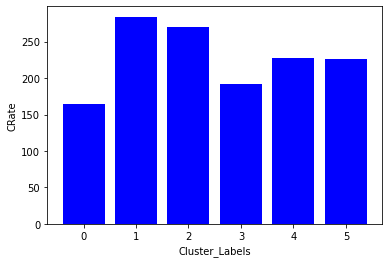

In [74]:
# Lets plot CRate vs Cluster_Labels.

plt.bar(Madrid_reg.Cluster_Labels, Madrid_reg.CRate,  color='blue')
plt.xlabel("Cluster_Labels")
plt.ylabel("CRate")
plt.show()

In [75]:
Madrid_reg.corr()

,PDensity,CRate,Cluster_Labels
PDensity,1.000000,0.012475,-0.273032
CRate,0.012475,1.000000,-0.193407
Cluster_Labels,-0.273032,-0.193407,1.000000


Sometimes we would like to know the significant of the correlation estimate.

P-value:

What is this P-value? The P-value is the probability value that the correlation between these two variables is statistically significant.

Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant.

By convention, when the

* p-value is < 0.001: we say there is strong evidence that the correlation is significant.
* the p-value is < 0.05: there is moderate evidence that the correlation is significant.
* the p-value is < 0.1: there is weak evidence that the correlation is significant.
* the p-value is > 0.1: there is no evidence that the correlation is significant.

In [76]:
# We can obtain this information using "stats" module in the "scipy" library.

from scipy import stats

In [77]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'PDensity' and 'CRate'.

pearson_coef, p_value = stats.pearsonr(Madrid_reg['PDensity'], Madrid_reg['CRate'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.012474723057334297  with a P-value of P = 0.9571999240984884


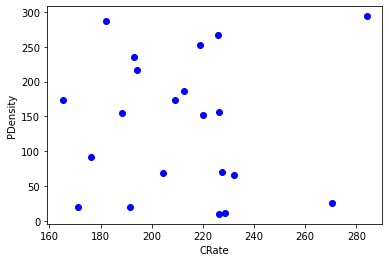

In [78]:
# Lets plot CRate vs PDensity, to see how linear is their relation:

plt.scatter(Madrid_reg.CRate, Madrid_reg.PDensity,  color='blue')
plt.xlabel("CRate")
plt.ylabel("PDensity")
plt.show()

In [79]:
import seaborn as sns

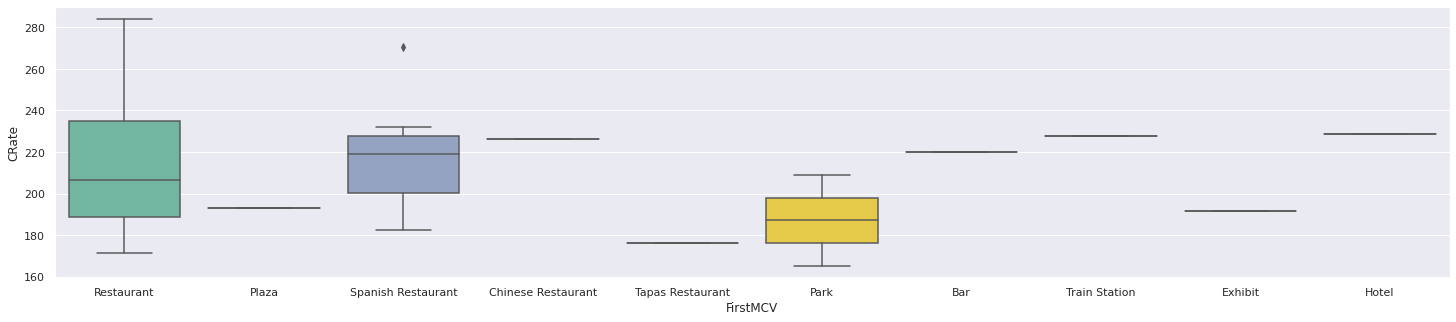

In [80]:
# Let's check how the FirstMCV and the CRtae look when plotted on a boxplot

sns.set(rc={'figure.figsize':(25,5)})

sns.boxplot(x="FirstMCV", y="CRate", palette="Set2", data=Madrid_reg)

(150.0, 300.0)

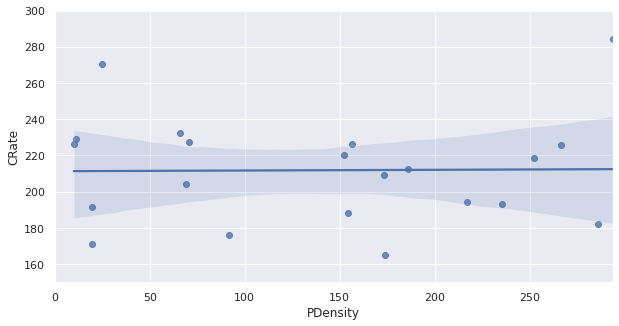

In [81]:
sns.set(rc={'figure.figsize':(10,5)})
sns.regplot(x="PDensity", y="CRate", data=Madrid_reg)
plt.xlim(0,)
plt.ylim(150,300)

#### Polynomial regressions

Sometimes, the trend of data is not really linear, and looks curvy. In this case we can use Polynomial regression methods. In fact, many different regressions exist that can be used to fit whatever the dataset looks like, such as quadratic, cubic, and so on, and it can go on and on to infinite degrees.

In essence, we can call all of these, polynomial regression, where the relationship between the independent variable x and the dependent variable y is modeled as an nth degree polynomial in x. Lets say you want to have a polynomial regression (let's make 2 degree polynomial):

𝑦 = 𝑏 + 𝑡ℎ𝑒𝑡𝑎1𝑥 + 𝑡ℎ𝑒𝑡𝑎2 𝑥2

Now, the question is: how we can fit our data on this equation while we have only x values, such as CRate? Well, we can create a few additional features: 1, 𝑥 , and 𝑥2 .

PolynomialFeatures() function in Scikit-learn library, drives a new feature sets from the original feature set. That is, a matrix will be generated consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, lets say the original feature set has only one feature, CRate. Now, if we select the degree of the polynomial to be 2, then it generates 3 features, degree=0, degree=1 and degree=2:

In [82]:
# Lets split our dataset into train and test sets, 80% of the entire data for training, and the 20% for testing. 
# We create a mask to select random rows using np.random.rand() function:

msk = np.random.rand(len(Madrid_merged)) < 0.8
train = Madrid_reg[msk]
test = Madrid_reg[~msk]

In [83]:
# Creating train and test dataset

In [107]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
train_x = np.asanyarray(train[['PDensity']])
train_y = np.asanyarray(train[['CRate']])

test_x = np.asanyarray(test[['PDensity']])
test_y = np.asanyarray(test[['CRate']])


poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

array([[1.00000000e+00, 2.52340000e+02, 6.36754756e+04],
       [1.00000000e+00, 2.16820000e+02, 4.70109124e+04],
       [1.00000000e+00, 1.56310000e+02, 2.44328161e+04],
       [1.00000000e+00, 2.86130000e+02, 8.18703769e+04],
       [1.00000000e+00, 2.93640000e+02, 8.62244496e+04],
       [1.00000000e+00, 2.51200000e+01, 6.31014400e+02],
       [1.00000000e+00, 1.73680000e+02, 3.01647424e+04],
       [1.00000000e+00, 1.52050000e+02, 2.31192025e+04],
       [1.00000000e+00, 1.54340000e+02, 2.38208356e+04],
       [1.00000000e+00, 1.86010000e+02, 3.45997201e+04],
       [1.00000000e+00, 7.06400000e+01, 4.99000960e+03],
       [1.00000000e+00, 1.98600000e+01, 3.94419600e+02],
       [1.00000000e+00, 1.98600000e+01, 3.94419600e+02],
       [1.00000000e+00, 6.92400000e+01, 4.79417760e+03],
       [1.00000000e+00, 1.11800000e+01, 1.24992400e+02]])

In [108]:
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)

# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.         -0.34592734  0.00126665]]
Intercept:  [224.53077233]


Text(0, 0.5, 'PDensity')

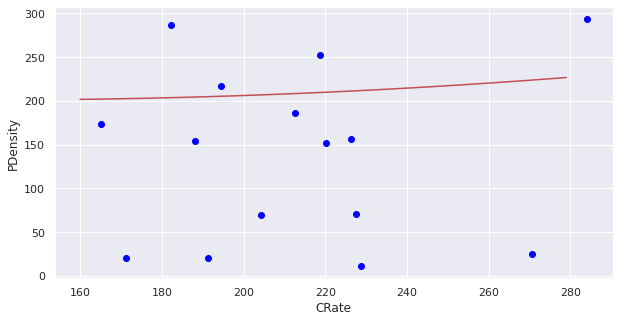

In [109]:
plt.scatter(train.CRate, train.PDensity,  color='blue')
XX = np.arange(160.0, 280.0, 1)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)
plt.plot(XX, yy, '-r' )
plt.xlabel("CRate")
plt.ylabel("PDensity")

In [110]:
from sklearn.metrics import r2_score

test_x_poly = poly.fit_transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

Mean absolute error: 14.56
Residual sum of squares (MSE): 307.46
R2-score: -3.90


The take away for R2 is

* An R2 of 1.0 is the best. It means you have no error in your regression.
* An R2 of 0 means your regression is no better than taking the mean value, i.e. you are not using any information from the other variables
* A Negative R2 means we are doing worse than the mean value. 